In [1]:
## default libraries
from glob import glob
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as spstats
import os, sys, logging, h5py
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import palettable.colorbrewer as cb
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statannotations.Annotator import Annotator
# import ipywidgets as widgets


#### My libraries
import bshap.core as bshap
import pyquant.genopheno as pyquant
import snpmatch
from pygenome import genome
import pygenome.plotting as  genome_plotting


### Few settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style="white", color_codes=True, font_scale = 1.25)
log = logging.getLogger(__name__)


### Global variables
context_colors = cb.qualitative.Set2_3.hex_colors
temp_color = {'T4': cb.sequential.Blues_6.hex_colors[3], "T16": cb.sequential.Oranges_6.hex_colors[3]}
marker_color = {  }
parent_color = {"6191": cb.diverging.BrBG_7.hex_colors[1], "6046": cb.diverging.BrBG_7.hex_colors[5]}
# parent_color = {'6046': cb.qualitative.Paired_6.hex_colors[0], '6191': cb.qualitative.Paired_6.hex_colors[5]}
geno_color = {'AA': cb.diverging.BrBG_6.hex_colors[4], 'BB': cb.diverging.BrBG_6.hex_colors[1], 'AB': cb.sequential.Greys_5.hex_colors[2]}


home_dir = "/users/rahul.pisupati/"
proj_dir = "/groups/nordborg/projects/"
# home_dir = "/vol/HOME/"
# proj_dir = "/projects/"

tair10 = genome.GenomeClass(home_dir +  "/TAiR10_ARABIDOPSIS/TAIR10_wholeGenome.fasta")
tair10.centro_start = np.array([14364752, 3602775, 12674550, 2919690, 11668616, 0, 0])
tair10.centro_end   = np.array([15750321, 3735247, 13674767, 4011692, 12082583, 0, 0])
tair10.centro_mid = ((tair10.centro_start + tair10.centro_end)/2).astype(int)


tair10.load_bed_ids_str(genes = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.protein_coding_genes.bed", gene_exon = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.protein_coding_gene_exons.bed", tes = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.transposable_elements.bed", tegene = home_dir + "/ARAPORT11/annotations/Araport11_GFF3_201606.transposable_element_genes.bed")
tair10.tes_cmt2_ids = pd.read_csv(proj_dir + "/cegs/rahul/013.alignMutants/CMT2_target_TEs.txt", header = None).iloc[:,0]
tair10.tes_rddm_ids = pd.read_csv(proj_dir + "/cegs/rahul/013.alignMutants/RdDM_target_TEs.txt", header = None).iloc[:,0]


tair10.genes.columns = ['chr','start','end','geneid','score','strand']
tair10.genes['gene_str'] = tair10.genes.iloc[:,[0,1,2]].astype(str).agg(','.join,1).values


plotting_along_genome = genome_plotting.PlottingGenomeWide(tair10)

def invLogit(x):
    return(1 / (1 + np.exp(-x)))

def logit(x):
    return(np.log((x/(1 - x))))

filtering out genome scaffolds less than 1000000


In [2]:
%%time
cross_data = pyquant.qtl_maps.GeneticMap( {'d1_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D1.csv", 'd2_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D2.csv" } )

cross_data.pheno = bshap.the1001g.ContextsHDF51001gTable( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/wmas_cds_genes/" )
cross_data.parent_ids = pyquant.parsers.split_ids(cross_data.pheno.cg.accessions).iloc[pd.Series(cross_data.pheno.cg.accessions).str.contains( "P_" ).values,:].sort_values( "dir_temp_plate" )



def get_temperature_effects(req_meths_dict, req_gene_ix, return_pheno = False, logit = True):
    """
    """
    ef_data = pd.DataFrame({"CG": req_meths_dict['CG'].iloc[req_gene_ix,:], "CHG": req_meths_dict['CHG'].iloc[req_gene_ix,:], "CHH": req_meths_dict['CHH'].iloc[req_gene_ix,:] })
    if logit:            
        ef_data = utils.logit( utils.transform_beta(ef_data) )
    ef_data['marker'] = cross_data.get_genotype_marker("d1_2020", cross_data.get_closest_marker("d1_2020", tair10.genes_str[req_gene_ix] )['marker_id'][0] ).reindex( ef_data.index )
    ef_data['temp'] = cross_data.ids_d1_2020['dir_temp'].copy().str.replace("D1_", "").reindex( ef_data.index )
    ef_data = ef_data.dropna()
    ef_data['cisxtemp'] = ef_data['marker'].astype("str") + "_" + ef_data['temp'].astype("str")
    if return_pheno:
        return(ef_data)
    ef_all_effects = pd.Series(utils.linear_model_tukey(ef_data))
    return(ef_all_effects)


perc_meths_folder = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/hdf5/allc_" 

combined_mcs = {}

## Check a single gene

# ef_gene_data['gene_str'] = 'Chr1,4877506,4879307' #"Chr5,19342405,19345127"
# cross_data.ids_d1_2020['genotype_at_gene'] = cross_data.ids_d1_2020['dir_temp'] + "_" + cross_data.get_genotype_marker("d1_2020", aragenes_closest_marker.loc[ef_gene_data['gene_str']][0])
# ef_gene_data['samples'] = cross_data.ids_d1_2020.groupby('genotype_at_gene').apply(lambda x: x.sample(n=20))
# ef_gene_data['meths'] = combinemeths.CombinedMethsTable( perc_meths_folder + ef_gene_data['samples'].index.get_level_values(1) + ".hdf5", file_ids =  ef_gene_data['samples'].index.get_level_values(1).values)

#### Check cytosines on entire chromosome but in parents
combined_mcs['samples'] = pyquant.parsers.split_ids( cross_data.parent_ids.index )
conv_rate = pd.read_csv(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/sample_conversion_rate_chrc.csv", index_col=0).groupby("sample_id").mean()
combined_mcs['samples'] = pd.merge(combined_mcs['samples'], conv_rate, right_index=True, left_index=True)


# combined_mcs['meths'] = combinemeths.CombinedMethsTable(file_paths = perc_meths_folder + cross_data.parent_ids.index + ".hdf5", file_ids =  cross_data.parent_ids.index.values )
# combined_mcs['mcs'] = combined_mcs['meths'].derive_most_common_positions( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/mcs_all_parents.hdf5", num_lines_with_info=10 )
combined_mcs['meths'] = bshap.combinemeths.EpiMutations(proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/mcs_all_parents.hdf5")

CPU times: user 354 ms, sys: 38 ms, total: 392 ms
Wall time: 737 ms



# Bimodal distribution for DNA methylation

In [21]:
%%time

ef_file_ix = np.where(pd.Series(combined_mcs['meths'].file_ids).str.contains("P_6046"))[0]
pos_ix = np.arange(2000000)


ef_meths = pd.DataFrame({'count': combined_mcs['meths'].__getattr__("mc_count", pos_ix)[:,ef_file_ix].sum(1), "total": combined_mcs['meths'].__getattr__("mc_total", pos_ix)[:,ef_file_ix].sum(1), 'context': combined_mcs['meths'].__getattr__("mc_class", pos_ix) })

In [30]:
ef_meths['permeths'] = bshap.stats.np_get_fraction(ef_meths['count'].values, ef_meths['total'].values, y_min=5  )

In [33]:
ef_meths['class'] = "CHH"
ef_meths.loc[ef_meths['context'].str.match("CG[ATGC]"), 'class'] = 'CG'
ef_meths.loc[ef_meths['context'].str.match("C[ATC]G"), 'class'] = 'CHG'

/tmp/ipykernel_22766/1179518433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ef_meths['class'][ef_meths['context'].str.match("CG[ATGC]")] = 'CG'
/tmp/ipykernel_22766/1179518433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ef_meths['class'][ef_meths['context'].str.match("C[ATC]G")] = 'CHG'


(0.0, 10.0)

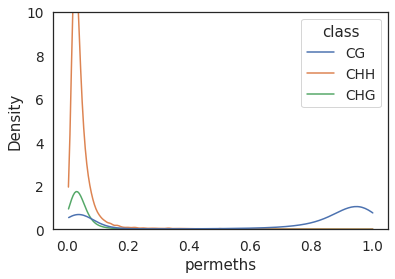

In [38]:
sns.kdeplot( data = ef_meths[ef_meths['permeths'] > 0], x= "permeths", hue = "class", cut = 0  )

plt.ylim(0,10)

# Defining gbM

In [4]:
3/223

0.013452914798206279

In [3]:
17 / 375

0.04533333333333334

In [2]:
26 / 108

0.24074074074074073

In [3]:
def hist_plot(x, axs, **kwargs):
    ## Square root transform the data to make it syymmetrical
    ## https://www.redalyc.org/pdf/2990/299023509004.pdf
    x = np.sqrt( (x - np.min(x)) / (np.max(x) - np.min(x)) )
    
    sns.histplot(x = x, binwidth=0.005, ax = axs,**kwargs )
    axs.set_yscale('log')
    
    # axs.plot((np.median(x), np.median(x)), (0, 3000), '.2')
    thres = np.mean(x) + (2 * np.std(x))
    axs.plot((thres, thres), (0, 3000), 'r--')
    
    return( np.where(x >= thres)[0] )
    # thres = np.mean(x) - (1 * np.std(x))
    # axs.plot((thres, thres), (0, 3000), 'r--')
    

In [4]:
%%time

## Calculate average TE like methylation on gene body exons.

# combined_mcs['avg_meths'] = cross_data.pheno.get_meths_req_gene(req_gene_ix= cross_data.pheno.get_filter_inds( tair10.genes_str ), count_thres=10)
combined_mcs['avg_meths'] = cross_data.pheno.group_sample_methylation( combined_mcs['samples']['geno_dir'], np.arange(len(cross_data.pheno.cg.start)), count_thres=10 )



combined_mcs['avg_meths']['mc'] = combined_mcs['avg_meths']['CG'].add_prefix("CG_")
for ef_c in ['CHG','CHH']:
    combined_mcs['avg_meths']['mc'] = pd.merge(combined_mcs['avg_meths']['mc'], combined_mcs['avg_meths'][ef_c].add_prefix(ef_c + "_"), right_index=True, left_index=True )
    
combined_mcs['avg_meths']['mc']['gene_str'] = cross_data.pheno.cg.get_bed_df(None).astype(str).agg(','.join,1)
combined_mcs['avg_meths']['mc'] = pd.merge(combined_mcs['avg_meths']['mc'], tair10.genes.loc[:,['geneid','gene_str']], left_on='gene_str', right_on='gene_str'  )

KeyboardInterrupt: 

In [5]:
combined_mcs['avg_meths']['CG'].mean(0)


KeyboardInterrupt



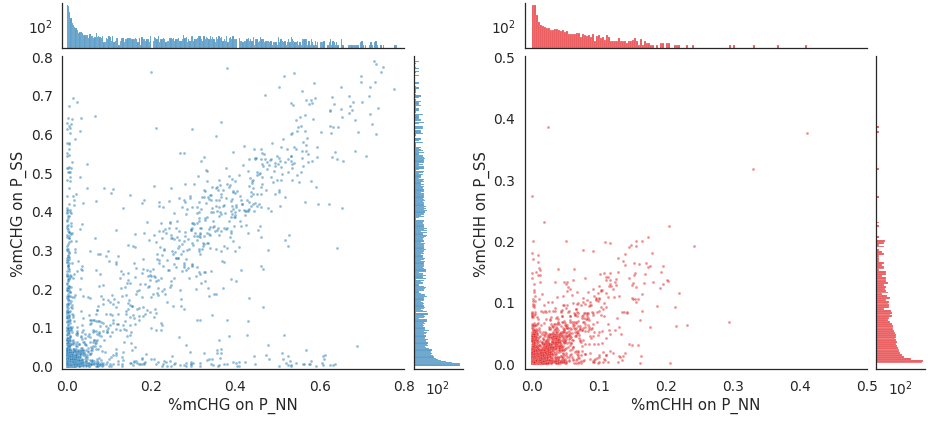

In [7]:
fig_args = dict(
    marginal_ticks=True,
    joint_kws={'s':8},
    alpha = 0.5,
    marginal_kws={'binwidth': 0.003}
)

# , color=reqcond['color'], 

g0 = sns.jointplot(data = combined_mcs['avg_meths']['mc'], x = 'CHG_P_6046', y = 'CHG_P_6191', color = cb.qualitative.Paired_6.hex_colors[1], **fig_args, xlim = (-0.01, 0.8), ylim = (-0.01, 0.8) )
g0.ax_marg_x.set_yscale('log')
g0.ax_marg_y.set_xscale('log')
g0.ax_joint.set_xlabel('%mCHG on P_NN')
g0.ax_joint.set_ylabel('%mCHG on P_SS')

g1 = sns.jointplot(data = combined_mcs['avg_meths']['mc'], x = 'CHH_P_6046', y = 'CHH_P_6191', color = cb.qualitative.Paired_6.hex_colors[5], **fig_args, xlim = (-0.01, 0.5), ylim = (-0.01, 0.5) )
g1.ax_marg_x.set_yscale('log')
g1.ax_marg_y.set_xscale('log')
g1.ax_joint.set_xlabel('%mCHH on P_NN')
g1.ax_joint.set_ylabel('%mCHH on P_SS')



fig = plt.figure(figsize=(13,6))
gs = gridspec.GridSpec(1, 2)

mg0 = bshap.plotting.SeabornFig2Grid(g0, fig, gs[0])
mg1 = bshap.plotting.SeabornFig2Grid(g1, fig, gs[1])



gs.tight_layout(fig)
#gs.update(top=0.7)

plt.show()

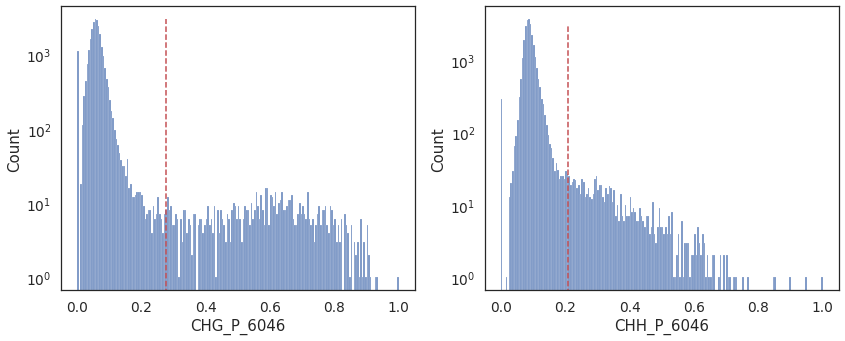

In [83]:
combined_mcs['avg_meths']['mc']['gbm_6046'] = True

fig, axs = plt.subplots(ncols=2, figsize = (12, 5))
ef_ix = hist_plot(combined_mcs['avg_meths']['mc']['CHG_P_6046'], axs.flat[0]  )
combined_mcs['avg_meths']['mc'].loc[ef_ix,'gbm_6046'] = False

ef_ix = hist_plot(combined_mcs['avg_meths']['mc']['CHH_P_6046'].dropna(), axs.flat[1]  )
combined_mcs['avg_meths']['mc'].loc[ef_ix,'gbm_6046'] = False


fig.tight_layout()
plt.show()

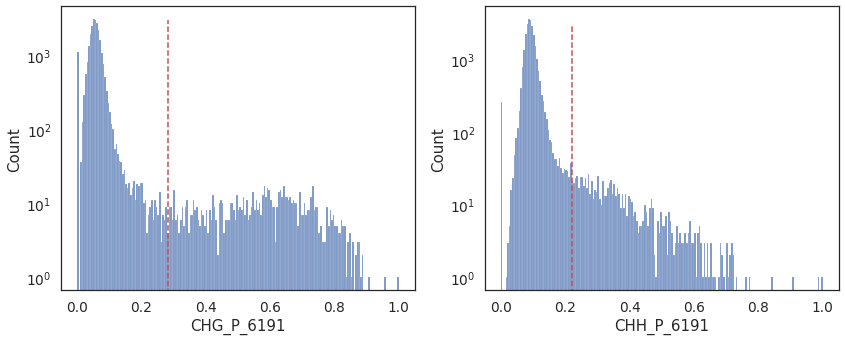

In [84]:
combined_mcs['avg_meths']['mc']['gbm_6191'] = True

fig, axs = plt.subplots(ncols=2, figsize = (12, 5))
ef_ix = hist_plot(combined_mcs['avg_meths']['mc']['CHG_P_6191'], axs.flat[0]  )
combined_mcs['avg_meths']['mc'].loc[ef_ix,'gbm_6191'] = False

ef_ix = hist_plot(combined_mcs['avg_meths']['mc']['CHH_P_6191'].dropna(), axs.flat[1]  )
combined_mcs['avg_meths']['mc'].loc[ef_ix,'gbm_6191'] = False

fig.tight_layout()
plt.show()

In [88]:
# AT5G10140 --- FLC gene


combined_mcs['avg_meths']['mc'].set_index('geneid').loc[['AT5G10140'],:]

CG_P_6046  CG_P_6191  CHG_P_6046  CHG_P_6191  CHH_P_6046  \
geneid                                                                
AT5G10140   0.056726   0.036073    0.001817    0.002951    0.002166   

           CHH_P_6191              gene_str  gbm_6046  gbm_6191  
geneid                                                           
AT5G10140    0.003126  Chr5,3173382,3179448      True      True

maybe we can estimate conversion rate from these numbers here. 




In [95]:
combined_mcs['avg_meths']['mc'].loc[ (combined_mcs['avg_meths']['mc']['gbm_6046'] & combined_mcs['avg_meths']['mc']['gbm_6191'])].to_csv("/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/araport_gbm_only_genes_6046_6191.csv")

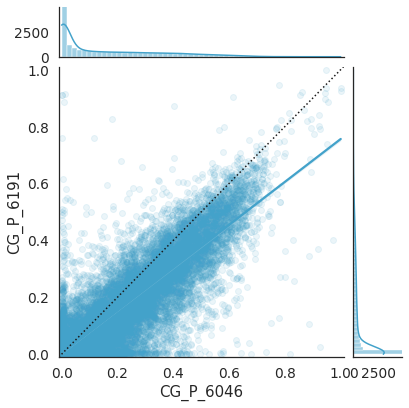

In [99]:
ef_data = combined_mcs['avg_meths']['mc'].loc[ (combined_mcs['avg_meths']['mc']['gbm_6046'] & combined_mcs['avg_meths']['mc']['gbm_6191'])].copy()

bshap.plotting.meths_jointplot(x = ef_data['CG_P_6046'], y = ef_data['CG_P_6191'], reqcond={"plt_limits": (-0.01, 1.01)})


# What is the nature of epi-mutation?


* are new cytosines being methylation (or)
* cytosines are methylated less? 
* compare this to change you see in north south

In [3]:
### Filtering the genes with only gene body methylation in parents

gbm_only_genes = pd.read_csv("/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/araport_gbm_only_genes_6046_6191.csv", index_col=0)
tair10.gene_exon['parent_id'] = tair10.gene_exon.iloc[:,3].str.split(":", expand = True).iloc[:,0].values
print("total number of genes: %s" % tair10.gene_exon['parent_id'].unique().shape[0] )
tair10.gene_exon = tair10.gene_exon[tair10.gene_exon['parent_id'].isin( gbm_only_genes['geneid'] )]
tair10.genes = tair10.genes[tair10.genes.iloc[:,3].isin( gbm_only_genes['geneid'] )]
print("number of genes with gbm: %s" % tair10.gene_exon['parent_id'].unique().shape[0] )

total number of genes: 27445
number of genes with gbm: 24841


In [4]:
#### Identifying CG DMCs using methylpy
import subprocess

out_processes = []
for ef_geno in ["P_6046", "P_6191"]:
    ef_data = cross_data.parent_ids[cross_data.parent_ids['genotype'] == ef_geno]
#     if os.path.isfile( "/scratch-cbe/users/rahul.pisupati/dmcs/" + ef_geno +  )
#     'DMC_' + ef_geno
    ef_cmd = "conda activate ~/.conda/envs/methylpy/ " 
    ef_cmd += " && LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/users/rahul.pisupati/.conda/envs/methylpy/lib "  ### libgsl error if not given
    ef_cmd += " && export LD_LIBRARY_PATH "
    ef_cmd += " && mkdir -p /scratch-cbe/users/rahul.pisupati/dmcs/" + ef_geno
    ef_cmd += " && cd /scratch-cbe/users/rahul.pisupati/dmcs/" + ef_geno 
    ef_cmd += " && methylpy DMRfind "
    ef_cmd += ' --chroms ' + pd.Series(tair10.chrs).str.cat(sep = " ")
    ef_cmd += ' --mc-type "CGN" --num-procs 8 --dmr-max-dist 1 --min-num-dms 0 --mc-max-dist 1 --sig-cutoff 0.05 '
    ef_cmd += " --allc-files " + (proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/allc/allc_" + ef_data.index + ".tsv.gz").str.cat(sep = " " )
    ef_cmd += " --sample-category " + ef_data['dir_temp'].str.cat(sep = " ") 
    ef_cmd += ' --samples ' +  ef_data.index.str.cat(sep = " ")
    ef_cmd += ' --output-prefix DMC_' + ef_geno
    out_processes.append(ef_cmd)
#     out_processes.append( subprocess.Popen( ef_cmd, shell=True, stdout=subprocess.PIPE, stderr = subprocess.PIPE) )

# for p in out_processes:
#     p.wait()

In [5]:
%%time

combined_mcs.update( combined_mcs['meths'].get_req_pos_ix_genome(req_bed_df_dict = {"gbm": tair10.gene_exon }, cache_file= proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/mcs_all_parents_cache_data.pandas.h5") )

combined_mcs['mcg_gbm_inds'] = np.intersect1d(combined_mcs['mcs_mcg_inds'], combined_mcs['mcs_gbm_inds'])

combined_mcs['mcg_gbm_bed'] = pd.DataFrame({"chr": combined_mcs['meths'].__getattr__("chr",combined_mcs['mcg_gbm_inds']), 'start': combined_mcs['meths'].__getattr__("start",combined_mcs['mcg_gbm_inds']) }, index = combined_mcs['mcg_gbm_inds'] )

CPU times: user 7.67 s, sys: 4.06 s, total: 11.7 s
Wall time: 15.8 s


In [6]:
%%time
het_regions = pd.DataFrame(dict(chr = ['Chr1','Chr2','Chr3'], start = [9600001,600001,19600001], end = [11000000,8400000,20200000]))
p = bshap.run_bedtools.intersect_positions_bed( het_regions, combined_mcs['mcg_gbm_bed'] )
het_rem_ix = np.setdiff1d( np.arange(combined_mcs['mcg_gbm_bed'].shape[0]), p )

CPU times: user 794 ms, sys: 279 ms, total: 1.07 s
Wall time: 1.07 s


In [7]:
%%time
combined_mcs['parent_inds'] = combined_mcs['samples'].reset_index().groupby('geno_dir').groups
combined_mcs['parent_temp_inds'] = combined_mcs['samples'].reset_index().groupby('dir_temp').groups

combined_mcs['mc_count'] = bshap.combinemeths.cache_pd_variable_to_file(var_key = "mc_count", cache_file = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/mcs_all_parents_cache_data.pandas.h5" )
if combined_mcs['mc_count'] is None:
    combined_mcs['mc_count'] = combined_mcs['meths'].__getattr__('mc_count', combined_mcs['mcg_gbm_inds'] )
    bshap.combinemeths.cache_pd_variable_to_file(var_key = "mc_count", cache_file = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/mcs_all_parents_cache_data.pandas.h5", input_variable = pd.DataFrame(combined_mcs['mc_count']), mode = "a")
else:
    combined_mcs['mc_count'] = np.array(combined_mcs['mc_count'])

combined_mcs['mc_total'] = bshap.combinemeths.cache_pd_variable_to_file(var_key = "mc_total", cache_file = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/mcs_all_parents_cache_data.pandas.h5" )
if combined_mcs['mc_total'] is None:
    combined_mcs['mc_total'] = combined_mcs['meths'].__getattr__('mc_total', combined_mcs['mcg_gbm_inds'] )
    bshap.combinemeths.cache_pd_variable_to_file(var_key = "mc_total", cache_file = proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/mcs_all_parents_cache_data.pandas.h5", input_variable = pd.DataFrame(combined_mcs['mc_total']), mode = "a")
else:
    combined_mcs['mc_total'] = np.array(combined_mcs['mc_total'])


CPU times: user 2.72 s, sys: 2.83 s, total: 5.55 s
Wall time: 7.88 s


In [8]:
%%time
combined_mcs['devs'] = bshap.combinemeths.CalculateEpimutations(combined_mcs['mc_count'], combined_mcs['mc_total'], combined_mcs['parent_inds'], params={'prop_y_min': 5, 'max_meth_for_gain': 0.45, 'min_meth_for_loss': 0.55, 'mc_total_min': 3, 'conv_rate': 0.03} )

combined_mcs['devs_cats'] = bshap.combinemeths.CalculateEpimutations(combined_mcs['mc_count'], combined_mcs['mc_total'], combined_mcs['parent_temp_inds'], params={'prop_y_min': 5, 'max_meth_for_gain': 0.45, 'min_meth_for_loss': 0.55, 'mc_total_min': 3, 'conv_rate': 0.03} )
combined_mcs['devs'].mc_meths = pd.merge(combined_mcs['devs'].mc_meths, combined_mcs['devs_cats'].mc_meths, right_index=True, left_index=True)

combined_mcs['devs'].deviations = combined_mcs['devs'].calculate_gain_loss_for_homozygotes()

assuming all populations are homozygous


CPU times: user 19 s, sys: 15.5 s, total: 34.5 s
Wall time: 34.6 s


In [8]:
combined_mcs['samples'].reset_index().groupby('dir_temp').count()['temp']

dir_temp
6046_T16     7
6046_T4     16
6191_T16     9
6191_T4     16
Name: temp, dtype: int64

In [36]:
ef_data.shape

(650595, 4)

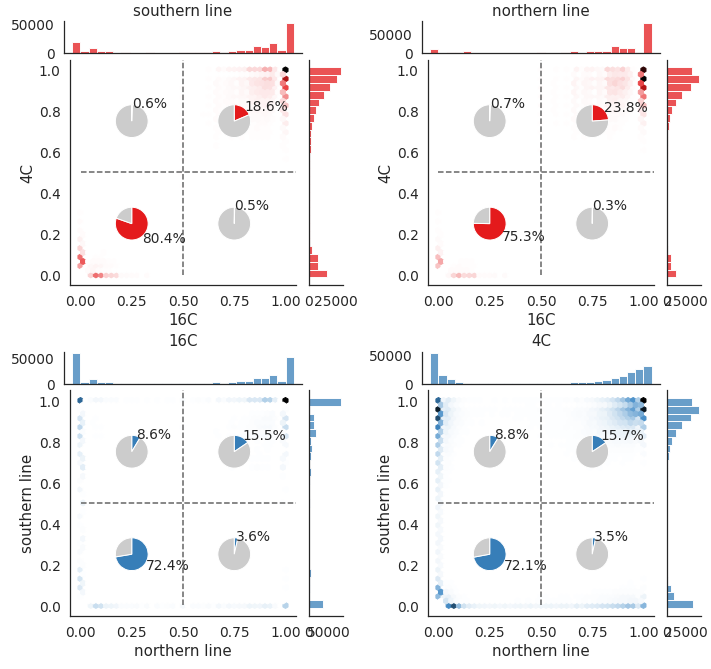

In [35]:
common_reqcond = {"annotate": False, "size": 40, "kind": "hex", 'min_sum': 0.05,"color": cb.qualitative.Set1_6.hex_colors[0]}
pie_options = dict(xlim=(0,2), ylim=(0,2), center = 0.5, xpie = (0.25,0.75), ypie = (0.25, 0.75), pie_rad = 0.08 ) 


ef_data = combined_mcs["devs_cats"].mc_meths.iloc[het_rem_ix,:].loc[:,['6191_T16', '6191_T4','6046_T16', '6046_T4']].dropna()

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)

axes = {}


p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "16C", "ylab": "4C"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
p.ax_marg_x.set_title("southern line")
axes[1] = bshap.plotting.SeabornFig2Grid(p, fig, gs[0])


p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,2], y = ef_data.iloc[:,3], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "16C", "ylab": "4C"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,2], y = ef_data.iloc[:,3], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
p.ax_marg_x.set_title("northern line")
axes[2] = bshap.plotting.SeabornFig2Grid(p, fig, gs[1])



common_reqcond['color'] = cb.qualitative.Set1_6.hex_colors[1]

p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "northern line", "ylab": "southern line"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,0], y = ef_data.iloc[:,2], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
p.ax_marg_x.set_title("16C")
axes[3] = bshap.plotting.SeabornFig2Grid(p, fig, gs[2])


p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,1], y = ef_data.iloc[:,3], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "northern line", "ylab": "southern line"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,1], y = ef_data.iloc[:,3], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
p.ax_marg_x.set_title("4C")
axes[4] = bshap.plotting.SeabornFig2Grid(p, fig, gs[3])



gs.tight_layout(fig)
gs.update(top=0.9)

plt.savefig("mcg_parents.pdf", dpi = 300)

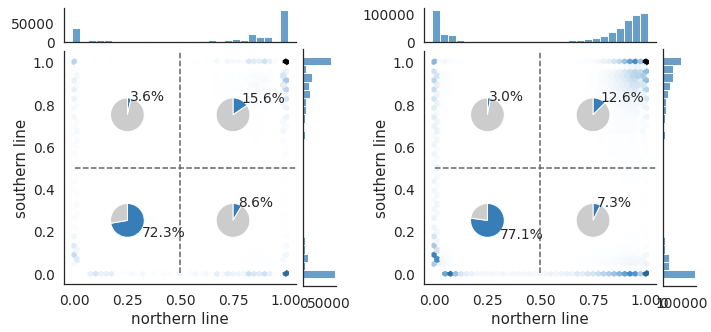

In [15]:
common_reqcond = {"annotate": False, "size": 40, "kind": "hex", 'min_sum': 0.05, "color": cb.qualitative.Set1_6.hex_colors[1]}
pie_options = dict(xlim=(0,2), ylim=(0,2), center = 0.5, xpie = (0.25,0.75), ypie = (0.25, 0.75), pie_rad = 0.08 ) 



fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2)

axes = {}


ef_data = combined_mcs["devs_cats"].mc_meths.loc[:,['6046_T16', '6191_T16']].dropna()
p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "northern line", "ylab": "southern line"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,[0,1]].dropna().iloc[:,0], y = ef_data.iloc[:,[0,1]].dropna().iloc[:,1], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
axes[1] = bshap.plotting.SeabornFig2Grid(p, fig, gs[0])


ef_data = combined_mcs["devs_cats"].mc_meths.loc[:,['6046_T4', '6191_T4']].dropna()
p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "northern line", "ylab": "southern line"}, min_sum = common_reqcond['min_sum'])
bshap.plotting._quadrant_plot_yolk(x = ef_data.iloc[:,[0,1]].dropna().iloc[:,0], y = ef_data.iloc[:,[0,1]].dropna().iloc[:,1], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
axes[2] = bshap.plotting.SeabornFig2Grid(p, fig, gs[1])




gs.tight_layout(fig)
gs.update(top=0.9)

plt.savefig("mcg_P_NS.pdf", dpi = 300)
plt.show()


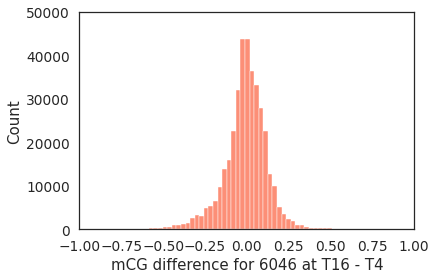

In [10]:
ef_data = combined_mcs['mcs_df_cats']['permeths_subpop'].loc[:,['6046_T16','6046_T4']].dropna()
ef_data = ef_data[ef_data.sum(axis = 1) > 0.001]

p = sns.histplot(ef_data.iloc[:,0] - ef_data.iloc[:,1], color = cb.sequential.Reds_5.hex_colors[2], bins = 70 )
plt.ylim(0,50000)
plt.xlim(-1,1)

plt.xlabel("mCG difference for 6046 at T16 - T4")

plt.show()

In [11]:
from fisher import pvalue_npy
def perform_fisher_two_sample(df_meths, sample_x, sample_y):
    x_counts = df_meths['mc_count_' + sample_x].to_numpy(np.uint)
    x_n_counts = (df_meths['mc_total_' + sample_x] - x_counts).to_numpy(np.uint)
    y_counts = df_meths['mc_count_' + sample_y].to_numpy(np.uint)
    y_n_counts = (df_meths['mc_total_' + sample_y] - y_counts).to_numpy(np.uint)
    pval = pvalue_npy(x_counts, x_n_counts, y_counts, y_n_counts)[2]
    return(pval)


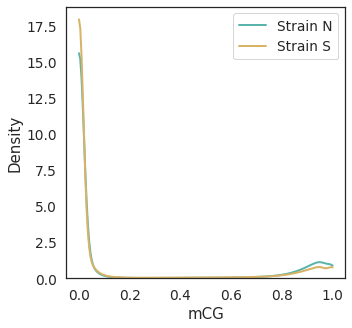

In [20]:
ef_data = combined_mcs['devs'].mc_meths.loc[:,['P_6046', 'P_6191']].dropna()


fig, axs = plt.subplots(figsize = (5, 5))

sns.kdeplot( x = ef_data.iloc[:,0], cut = 0, color=geno_color['AA'], ax = axs, label = "Strain N", lw = 2 )
sns.kdeplot( x = ef_data.iloc[:,1], cut = 0, color=geno_color['BB'], ax = axs, label = "Strain S", lw = 2 )

plt.legend()
axs.set_xlabel("mCG")

plt.show()

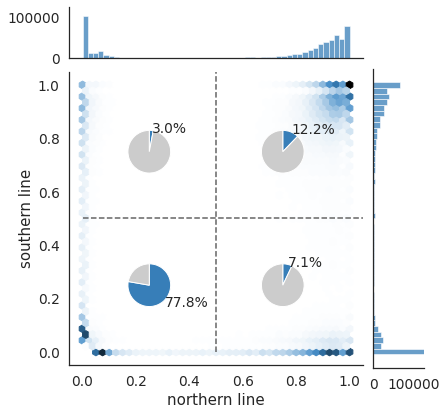

In [40]:
ef_data = combined_mcs['devs'].mc_meths.loc[:,['P_6046', 'P_6191', 'inherit_0_P_6046', 'inherit_1_P_6046', 'inherit_0_P_6191', 'inherit_1_P_6191' ]].dropna()

p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {**common_reqcond, "color": common_reqcond['color'], "xlab": "northern line", "ylab": "southern line"}, min_sum = common_reqcond['min_sum'])
_quadrant_plot_yolk(x = ef_data.iloc[:,[0,1]].dropna().iloc[:,0], y = ef_data.iloc[:,[0,1]].dropna().iloc[:,1], axs=p.ax_joint, plt_options={**pie_options,"color": common_reqcond['color']} )
# axes[1] = bshap.plotting.SeabornFig2Grid(p, fig, gs[0])


213178
109868
39682


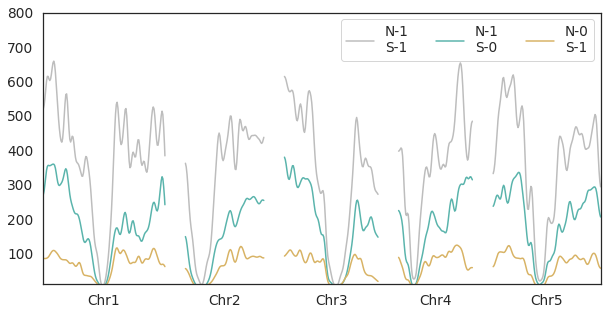

In [55]:
ef_data = ef_data = pd.merge(combined_mcs['mcg_gbm_bed'].reset_index(), combined_mcs['devs'].mc_meths.loc[:,['P_6046', 'P_6191', 'inherit_0_P_6046', 'inherit_1_P_6046', 'inherit_0_P_6191', 'inherit_1_P_6191' ]], left_index=True, right_index=True).dropna()
a_ef_data = ef_data[ef_data['inherit_1_P_6046'].astype(bool) & ef_data['inherit_1_P_6191'].astype(bool)]
n_ef_data = ef_data[ef_data['inherit_1_P_6046'].astype(bool) & ef_data['inherit_0_P_6191'].astype(bool)]
s_ef_data = ef_data[ef_data['inherit_0_P_6046'].astype(bool) & ef_data['inherit_1_P_6191'].astype(bool)]


print(a_ef_data.shape[0])
print(n_ef_data.shape[0])
print(s_ef_data.shape[0])

fig, axs = plt.subplots(figsize = (10,5))


plotting_along_genome.density_line_plot_positions( a_ef_data.loc[:,['chr','start']], plt_options={'line': True, 'nsmooth': 10, 'window_size': 200000, 'ylabel': "", 'xlabel': "", 'gap': 5000000, 'ylim': (10,800), 'color': "#bdbdbd" }, axs=axs ) 

plotting_along_genome.density_line_plot_positions( n_ef_data.loc[:,['chr','start']], plt_options={'line': True, 'nsmooth': 10, 'window_size': 200000, 'ylabel': "", 'xlabel': "", 'gap': 5000000, 'ylim': (10,800), 'color': geno_color['AA'] }, axs=axs ) 
plotting_along_genome.density_line_plot_positions( s_ef_data.loc[:,['chr','start']], plt_options={'line': True, 'nsmooth': 10, 'window_size': 200000, 'ylabel': "", 'xlabel': "", 'gap': 5000000, 'ylim': (10,800), 'color': geno_color['BB'] }, axs=axs ) 



axs.legend(handles = [
    matplotlib.lines.Line2D([0], [0], color="#bdbdbd", linestyle = '-', label = 'N-1\nS-1'),
    matplotlib.lines.Line2D([0], [0], color=geno_color['AA'], linestyle = '-', label = 'N-1\nS-0'),
    matplotlib.lines.Line2D([0], [0], color=geno_color['BB'], linestyle = '-', label = 'N-0\nS-1')
], ncol = 3)


plt.show()

In [8]:
100 - 77.8

22.200000000000003

In [9]:
3 / 22.2

0.13513513513513514

In [10]:
7.1 / 22.2

0.31981981981981983

In [34]:
(ef_data['inherit_1_P_6046'].astype(bool) |  ef_data['inherit_1_P_6191'].astype(bool)).sum() / ef_data.shape[0]

0.1883510616510304

In [35]:
(ef_data['inherit_1_P_6046'].astype(bool) & ef_data['inherit_0_P_6191'].astype(bool)).sum() / ef_data.shape[0]

0.0483899169908649

In [36]:
(ef_data['inherit_0_P_6046'].astype(bool) & ef_data['inherit_1_P_6191'].astype(bool)).sum() / ef_data.shape[0]

0.017477415498885034

In [37]:
3.6 + 15.6 + 8.6 

27.799999999999997

In [18]:
x = perform_fisher_two_sample(combined_mcs["devs_cats"].mc_meths, "6046_T16", "6046_T4"  )
np.where(x < 0.01)[0].shape[0] / combined_mcs["devs_cats"].mc_meths.shape[0]

0.0014142945065250977

In [19]:
x = perform_fisher_two_sample(combined_mcs["devs_cats"].mc_meths, "6191_T16", "6191_T4"  )
np.where(x < 0.01)[0].shape[0] / combined_mcs["devs_cats"].mc_meths.shape[0]

0.0016227961833307515

In [20]:
x = perform_fisher_two_sample(combined_mcs["devs_cats"].mc_meths, "6046_T16", "6191_T16"  )
np.where(x < 0.01)[0].shape[0] / combined_mcs["devs_cats"].mc_meths.shape[0]

0.04486847228560543

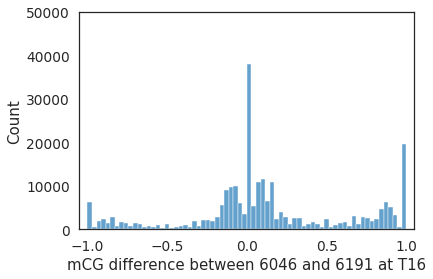

In [7]:
ef_data = combined_mcs['mcs_df_cats']['permeths_subpop'].loc[:,['6046_T16','6191_T16']].dropna()
ef_data = ef_data[ef_data.sum(axis = 1) > 0.001]


p = sns.histplot(ef_data.iloc[:,0] - ef_data.iloc[:,1], color = cb.sequential.Blues_5.hex_colors[3], bins = 70 )
plt.ylim(0,50000)
plt.xlim(-1.05,1.05)

plt.xlabel("mCG difference between 6046 and 6191 at T16")

plt.show()

## mCGs in TEs

In [36]:
%%time

combined_mcs.update( combined_mcs['meths'].get_req_pos_ix_genome(req_bed_df_dict = {"tes": tair10.tes, "tegene": tair10.tegene}, cache_file= proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/cache_data/mcs_all_parents_cache_data.pandas.h5") )


req_mc_data = {} 
req_mc_data['cg_data_ix'] = np.intersect1d(combined_mcs['mcs_mcg_inds'].values, combined_mcs['mcs_tegene_inds'].values )

req_mc_data.update( combined_mcs['meths'].calculate_per_meths_per_population(combined_mcs['parent_temp_inds'], req_mc_data['cg_data_ix']  ) )

CPU times: user 2.02 s, sys: 23.3 s, total: 25.4 s
Wall time: 25.3 s


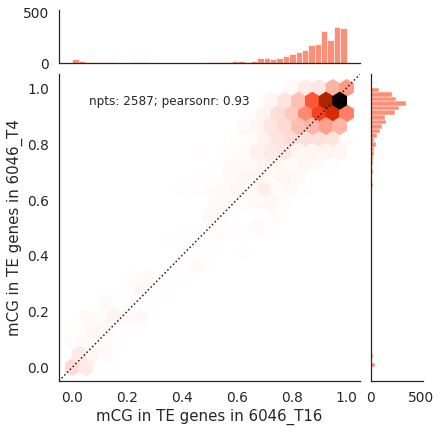

In [44]:
ef_data = req_mc_data['permeths_subpop'].loc[:,['6046_T16', '6046_T4']].dropna()

p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0].values, y = ef_data.iloc[:,1].values, reqcond = {"annotate": True, "kind": "hex", "color": cb.sequential.Reds_4.hex_colors[2], "size": 20}, min_sum = 0.01)

p.ax_joint.set_xlabel( "mCG in TE genes in 6046_T16" )
p.ax_joint.set_ylabel( "mCG in TE genes in 6046_T4"  )

plt.show()

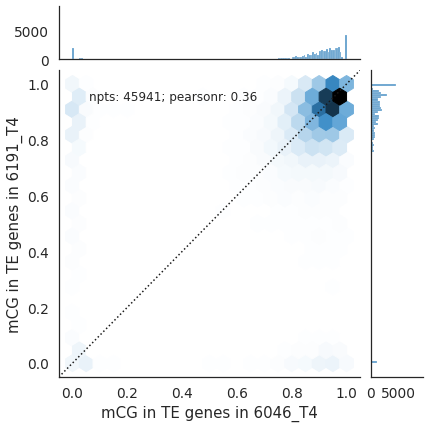

In [41]:
ef_data = req_mc_data['permeths_subpop'].loc[:,['6046_T4', '6191_T4']].dropna()

p = bshap.plotting.meths_jointplot(x = ef_data.iloc[:,0].values, y = ef_data.iloc[:,1].values, reqcond = {"annotate": True, "kind": "hex", "color": cb.sequential.Blues_5.hex_colors[3], "size": 20}, min_sum = 0.01)

p.ax_joint.set_xlabel( "mCG in TE genes in 6046_T4" )
p.ax_joint.set_ylabel( "mCG in TE genes in 6191_T4"  )

plt.show()

## Distribution of gain and loss across genome
**Summary**

* mCGs differences between North and South is due to new sites being methylted
* This is different to changes we see with temperature.
* We definitely need to understand more about the nature of **epimutations**. What is the model for epimutations happening?


One need to check/ tesst

* Rule out it is an experimental artifact. More data, replication. I do have bunch of F2s to test.
* What fraction of individuals do you see the epi-mutation (considering the error in bs-seq etc.)? 
* Test the independence between individuals and methylation state at each site. A binomial test with p
* Looking this across genes or regions. 

In [9]:
%%time
combined_mcs['sample_deviation'] = pd.merge(combined_mcs['samples'], combined_mcs['devs'].deviations.set_index( combined_mcs['samples'].index ), left_index=True, right_index=True )
combined_mcs['sample_deviation'] = combined_mcs['sample_deviation'][combined_mcs['sample_deviation']['mc_total_0'] > 100]
combined_mcs['sample_deviation'] = combined_mcs['sample_deviation'][combined_mcs['sample_deviation']['mc_total_1'] > 5000]

# model = ols('deviation_0 ~ conv_rate', data=combined_mcs['sample_deviation']).fit()
# print(sm.stats.anova_lm(model, typ=2))
# combined_mcs['sample_deviation']['resid_0'] = model.resid



# combined_mcs['deviation_per_windows_500kb'] = combined_mcs['samples'].copy()

# for ef_window in tair10.iter_positions_in_windows(combined_mcs['mcg_gbm_bed'], 500000):
#     ef_windows_str = ef_window[0] + "," + str(ef_window[1][0]) + "," + str(ef_window[1][1])
# #     print(ef_window[0])
#     if len(ef_window[2]) > 0:
#         ef_window_deviations = bshap.combinemeths.calculate_deviations_per_populations(mc_count=combined_mcs['mc_count'][ef_window[2],:], mc_total=combined_mcs['mc_total'][ef_window[2],:], sub_populations=combined_mcs['parent_inds'], params_meths={'prop_y_min': 25, 'max_meth_for_gain': 0.45, 'min_meth_for_loss': 0.55, 'mc_total_min': 3, 'conv_rate': 0.04}  )['deviations']
#         combined_mcs['deviation_per_windows_500kb'] = pd.merge(combined_mcs['deviation_per_windows_500kb'], ef_window_deviations.set_index( combined_mcs['meths'].file_ids ).add_prefix("region_" + ef_windows_str + "_"), right_index=True, left_index=True )
# combined_mcs['deviation_per_windows_500kb'].to_csv("cache_data/epimutation_rates_parents_500Kb.csv")

combined_mcs['deviation_per_windows_500kb'] = pd.read_csv("cache_data/epimutation_rates_parents_500Kb.csv", index_col=0)

combined_mcs['deviation_0_500kb_windows'] = combined_mcs['deviation_per_windows_500kb'].loc[:,combined_mcs['deviation_per_windows_500kb'].columns.str.contains("[0-9]_deviation_0")]
combined_mcs['deviation_0_500kb_windows'].columns = pd.Series(combined_mcs['deviation_0_500kb_windows'].columns.str.replace("region_", "").str.replace("_deviation_0", ""))
# combined_mcs['deviation_0_500kb_windows'] = combined_mcs['deviation_0_500kb_windows'][combined_mcs['deviation_0_500kb_windows'].isna().sum(1) < 10]

combined_mcs['deviation_0_500kb_windows'] = combined_mcs['deviation_0_500kb_windows'][combined_mcs['deviation_per_windows_500kb'].loc[:,combined_mcs['deviation_per_windows_500kb'].columns.str.contains("mc_total_0")].max(1) > 2500]


combined_mcs['deviation_1_500kb_windows'] = combined_mcs['deviation_per_windows_500kb'].loc[:,combined_mcs['deviation_per_windows_500kb'].columns.str.contains("[0-9]_deviation_1")]
combined_mcs['deviation_1_500kb_windows'].columns = pd.Series(combined_mcs['deviation_1_500kb_windows'].columns.str.replace("region_", "").str.replace("_deviation_1", ""))
combined_mcs['deviation_1_500kb_windows'] = combined_mcs['deviation_1_500kb_windows'][combined_mcs['deviation_1_500kb_windows'].isna().sum(1) < 10]

combined_mcs['deviation_1_500kb_windows'] = combined_mcs['deviation_1_500kb_windows'][combined_mcs['deviation_per_windows_500kb'].loc[:,combined_mcs['deviation_per_windows_500kb'].columns.str.contains("mc_total_1")].mean(1) > 80]


CPU times: user 488 ms, sys: 200 ms, total: 687 ms
Wall time: 1.27 s


<timed exec>:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


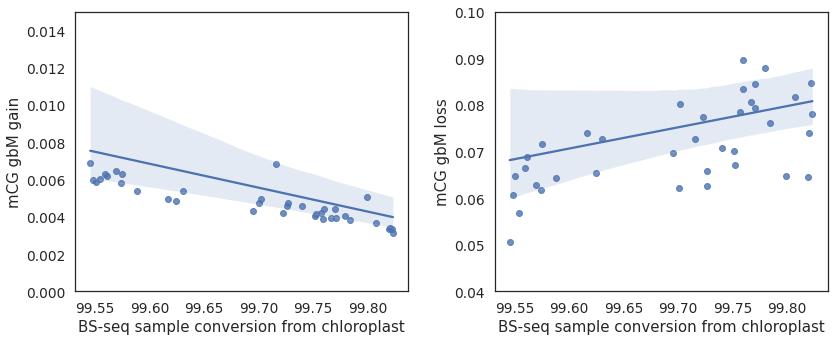

In [66]:
fig, axes = plt.subplots(ncols=2, nrows = 1, figsize=(12, 5), sharex = False )

# sns.scatterplot( data = ef_data, y = "deviation_0", x = 100 - ef_data["conv_rate"], hue = "dir_temp", ax=axes[0] )
sns.regplot( data = combined_mcs['sample_deviation'], y = "deviation_0", x = 100 - combined_mcs['sample_deviation']["conv_rate"],  ax=axes[0] )
axes[0].set_ylabel("mCG gbM gain")
axes[0].set_xlabel("BS-seq sample conversion from chloroplast")

axes[0].set_ylim(0, 0.015)


# sns.scatterplot( data = ef_data, y = "deviation_1", x = 100 - ef_data["conv_rate"], hue = "dir_temp", ax=axes[1] )
sns.regplot( data = combined_mcs['sample_deviation'], y = "deviation_1", x = 100 - combined_mcs['sample_deviation']["conv_rate"],  ax=axes[1] )
axes[1].set_ylabel("mCG gbM loss")
axes[1].set_xlabel("BS-seq sample conversion from chloroplast")

axes[1].set_ylim(0.04, 0.1)

plt.tight_layout()

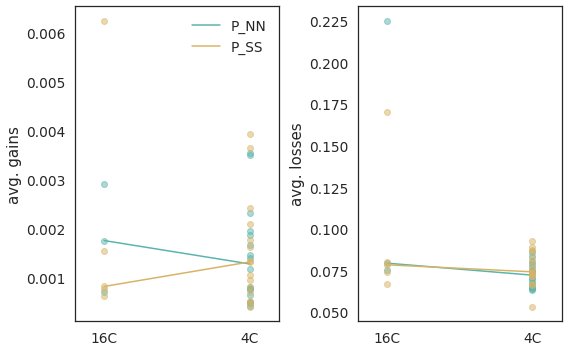

In [53]:
def reaction_plot(axs, pts_t16, pts_t4, color, **kwargs):
    axs.plot( np.repeat(0, pts_t16.shape[0]), pts_t16, 'o', color = color, alpha = 0.5  )
    axs.plot( np.repeat(1, pts_t4.shape[0]), pts_t4, 'o', color = color, alpha = 0.5 )
    axs.plot( (0, 1), (pts_t16.median(), pts_t4.median()), '-', color = color, **kwargs )

    
    
ef_grps = combined_mcs['sample_deviation'].groupby('dir_temp').groups


fig, axes = plt.subplots(ncols=2, figsize=(8, 5))


reaction_plot( axes.flat[0], combined_mcs['sample_deviation'].loc[ef_grps['6046_T16'], 'deviation_0'], combined_mcs['sample_deviation'].loc[ef_grps['6046_T4'], 'deviation_0'], geno_color['AA'], label = 'P_NN' )
reaction_plot( axes.flat[0], combined_mcs['sample_deviation'].loc[ef_grps['6191_T16'], 'deviation_0'], combined_mcs['sample_deviation'].loc[ef_grps['6191_T4'], 'deviation_0'], geno_color['BB'], label = 'P_SS' )
axes.flat[0].set
axes.flat[0].legend(frameon = False, ncol = 1)
axes.flat[0].set_xlim((-0.2, 1.2))
# ax.set_ylim((0.0003, 0.00171))
# axes.flat[0].set_ylim((0.15, 0.4))
axes.flat[0].set_xticks([0, 1])
axes.flat[0].set_xticklabels(["16C", "4C"])
axes.flat[0].set_ylabel( "avg. gains" )



reaction_plot( axes.flat[1], combined_mcs['sample_deviation'].loc[ef_grps['6046_T16'], 'deviation_1'], combined_mcs['sample_deviation'].loc[ef_grps['6046_T4'], 'deviation_1'], geno_color['AA'] )
reaction_plot( axes.flat[1], combined_mcs['sample_deviation'].loc[ef_grps['6191_T16'], 'deviation_1'], combined_mcs['sample_deviation'].loc[ef_grps['6191_T4'], 'deviation_1'], geno_color['BB'] )
axes.flat[1].set_xlim((-0.2, 1.2))
axes.flat[1].set_xticks([0, 1])
axes.flat[1].set_xticklabels(["16C", "4C"])
axes.flat[1].set_ylabel( "avg. losses" )


plt.tight_layout()

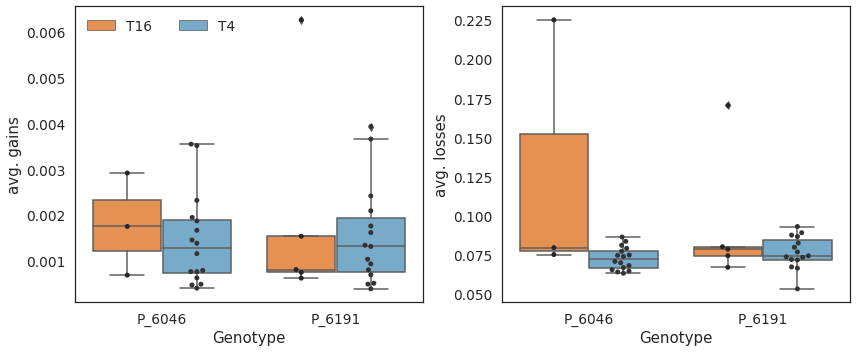

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "deviation_0", x = "geno_dir", palette=temp_color, ax=axes[0], order=['P_6046','P_6191']) 
sns.swarmplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "deviation_0", x = "geno_dir", dodge=True, color=".2", ax = axes[0], order=['P_6046','P_6191'] )
axes[0].set_ylabel("avg. gains")
axes[0].set_xlabel("Genotype")
# axes[0].set_title("mCG gain")


sns.boxplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "deviation_1", x = "geno_dir", palette=temp_color, ax=axes[1], order=['P_6046','P_6191']) 
sns.swarmplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "deviation_1", x = "geno_dir", dodge=True, color=".2", ax = axes[1] )
axes[1].set_ylabel("avg. losses")
# axes[1].set_ticks((0,1), ('P_NN'))
axes[1].set_xlabel("Genotype")
# axes[1].set_title("mCG loss")


handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend(handles[:2], labels[:2], title = "", frameon = False, ncol = 2)
axes[1].get_legend().remove()
# axes[1].legend(handles[:2], labels[:2])

plt.tight_layout()

In [98]:
# model = ols('deviation_0 ~ direction', data=combined_mcs['sample_deviation']).fit()
# print(sm.stats.anova_lm(model, typ=3))

# print("\nTemperature between alleles at T16")
print(sm.stats.multicomp.pairwise_tukeyhsd( combined_mcs['sample_deviation']['deviation_0'].values, combined_mcs['sample_deviation']['direction'].values ))


print(sm.stats.multicomp.pairwise_tukeyhsd( combined_mcs['sample_deviation']['deviation_1'].values, combined_mcs['sample_deviation']['direction'].values ))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  6046   6191   0.0005 0.2243 -0.0003 0.0013  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  6046   6191  -0.0095 0.4772 -0.0363 0.0172  False
---------------------------------------------------


In [99]:

pyquant.stats.bootstrap(combined_mcs['sample_deviation']['deviation_0'].loc[combined_mcs['sample_deviation'].groupby("direction").groups['6046']], combined_mcs['sample_deviation']['deviation_0'].loc[combined_mcs['sample_deviation'].groupby("direction").groups['6191']]  )


(0.21289,
 {'avg_metric': 0.0015659630560066447,
  'metric_ci_lb': 0.0012099267327812335,
  'metric_ci_ub': 0.001939960785740615},
 {'avg_metric': 0.002056731973723253,
  'metric_ci_lb': 0.0015714373762319512,
  'metric_ci_ub': 0.0025947709106651593})

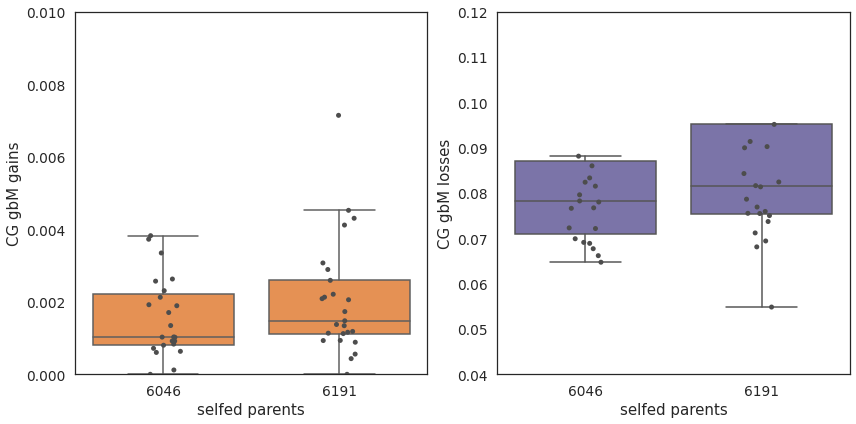

In [97]:
fig, axs = plt.subplots(ncols=2, figsize = (12, 6))

sns.boxplot(data = combined_mcs['sample_deviation'], x = 'direction', y = 'deviation_0', fliersize=0, ax = axs.flat[0], color=cb.sequential.YlOrRd_4.hex_colors[2])
sns.stripplot(data = combined_mcs['sample_deviation'], x = 'direction', y = 'deviation_0', color=".3", ax = axs.flat[0])
axs.flat[0].set_ylabel("CG gbM gains")
axs.flat[0].set_xlabel("selfed parents")
axs.flat[0].set_ylim((0, 0.01))


sns.boxplot(data = combined_mcs['sample_deviation'], x = 'direction', y = 'deviation_1', fliersize=0, ax = axs.flat[1], color=cb.sequential.Purples_3.hex_colors[2])
sns.stripplot(data = combined_mcs['sample_deviation'], x = 'direction', y = 'deviation_1', color=".3", ax = axs.flat[1])
axs.flat[1].set_ylabel("CG gbM losses")
axs.flat[1].set_xlabel("selfed parents")
axs.flat[1].set_ylim((0.04, 0.12))

plt.tight_layout()

plt.show()

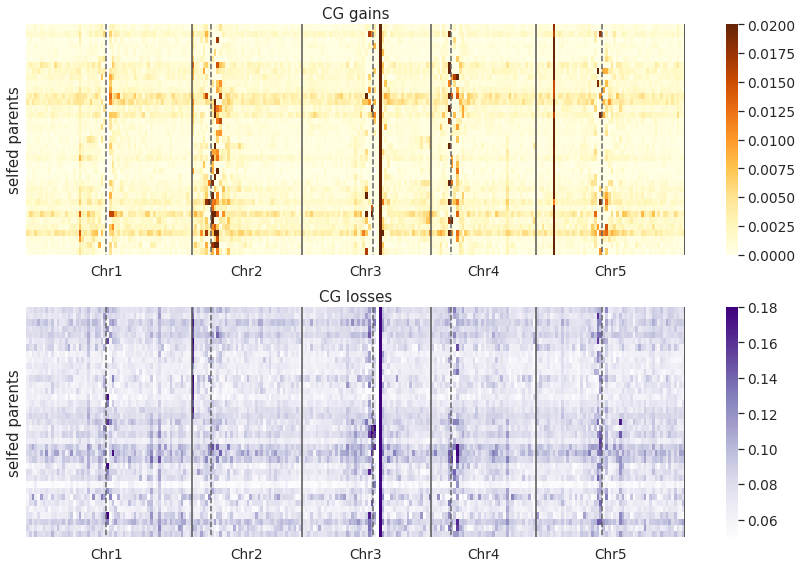

In [19]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize=(12, 8), sharex = False )


plotting_along_genome.generate_heatmap_genomewide(combined_mcs['deviation_0_500kb_windows'], axs=axes.flat[0], plt_options= {"cmap": "YlOrBr", "lims": (0, 0.02), "title": "CG gains", "ylabel": "selfed parents"} )


plotting_along_genome.generate_heatmap_genomewide( combined_mcs['deviation_1_500kb_windows'], axs=axes.flat[1], plt_options= {"cmap": "Purples", "lims": (0.05, 0.18), "title": "CG losses", "ylabel": "selfed parents"} )

plt.tight_layout()
plt.show()

In [127]:
%%time

combined_mcs['test_parent_windows'] = pd.DataFrame()

for ef_row in np.intersect1d(combined_mcs['deviation_0_500kb_windows'].columns, combined_mcs['deviation_1_500kb_windows'].columns):
    ef_model_0 = sm.stats.multicomp.pairwise_tukeyhsd(combined_mcs['deviation_0_500kb_windows'].loc[:,ef_row], combined_mcs['samples']['direction'].reindex(combined_mcs['deviation_0_500kb_windows'].index) )
    ef_model_1 = sm.stats.multicomp.pairwise_tukeyhsd(combined_mcs['deviation_1_500kb_windows'].loc[:,ef_row], combined_mcs['samples']['direction'].reindex(combined_mcs['deviation_1_500kb_windows'].index) )
    
    combined_mcs['test_parent_windows'].loc[ef_row, "meandiff_0"] = ef_model_0.meandiffs[0]
    combined_mcs['test_parent_windows'].loc[ef_row, "pval_0"] = ef_model_0.pvalues[0]
    combined_mcs['test_parent_windows'].loc[ef_row, "meandiff_1"] = ef_model_1.meandiffs[0]
    combined_mcs['test_parent_windows'].loc[ef_row, "pval_1"] = ef_model_1.pvalues[0]
    
combined_mcs['test_parent_windows']['xind'] = tair10.get_genomewide_inds( pd.Series(combined_mcs['test_parent_windows'].index) )
combined_mcs['test_parent_windows'] = combined_mcs['test_parent_windows'].sort_values('xind')


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
CPU times: user 7.93 s, sys: 3.64 ms, total: 7.93 s
Wall time: 7.91 s


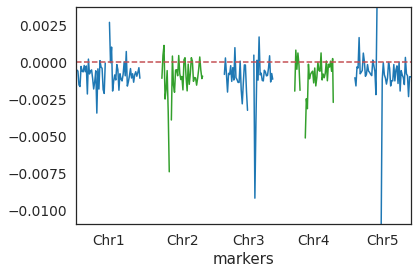

In [128]:


p = plotting_along_genome.manhattan_plot(x_ind=combined_mcs['test_parent_windows']['xind'], y_ind = -combined_mcs['test_parent_windows']['meandiff_0'], plt_options={"line": True}  )

p.plot(p.get_xbound(), (0, 0), 'r--'  )


# plt.ylim((0, 5))

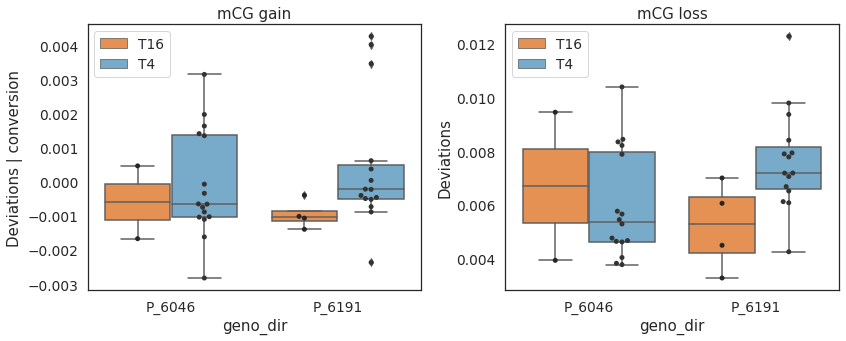

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "resid_0", x = "geno_dir", palette=temp_color, ax=axes[0]) 
sns.swarmplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "resid_0", x = "geno_dir", dodge=True, color=".2", ax = axes[0] )
axes[0].set_ylabel("Deviations | conversion")
axes[0].set_title("mCG gain")


sns.boxplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "deviation_1", x = "geno_dir", palette=temp_color, ax=axes[1]) 
sns.swarmplot( data = combined_mcs['sample_deviation'], hue = "temp", y = "deviation_1", x = "geno_dir", dodge=True, color=".2", ax = axes[1] )
axes[1].set_ylabel("Deviations")
axes[1].set_title("mCG loss")



handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend(handles[:2], labels[:2])
axes[1].legend(handles[:2], labels[:2])

plt.tight_layout()

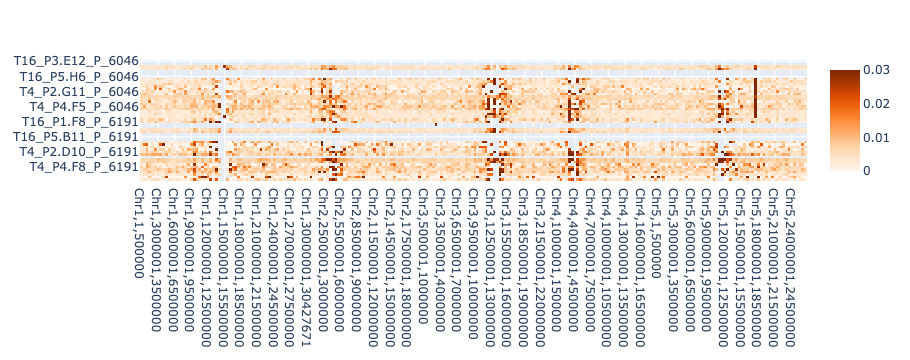

In [6]:
import pandas as pd
import plotly.express as px

ef_data = pd.read_csv("cache_data/epimutation_rates_parents_500Kb.csv", index_col=0)
ef_data = ef_data[ef_data.index.str.startswith("dev_0")].T.astype(float)
ef_data.columns = pd.Series(ef_data.columns.str.replace("dev_0_", ""))


fig = px.imshow(ef_data, aspect="auto", color_continuous_scale='Oranges', zmin=0, zmax=0.03)
fig.show()

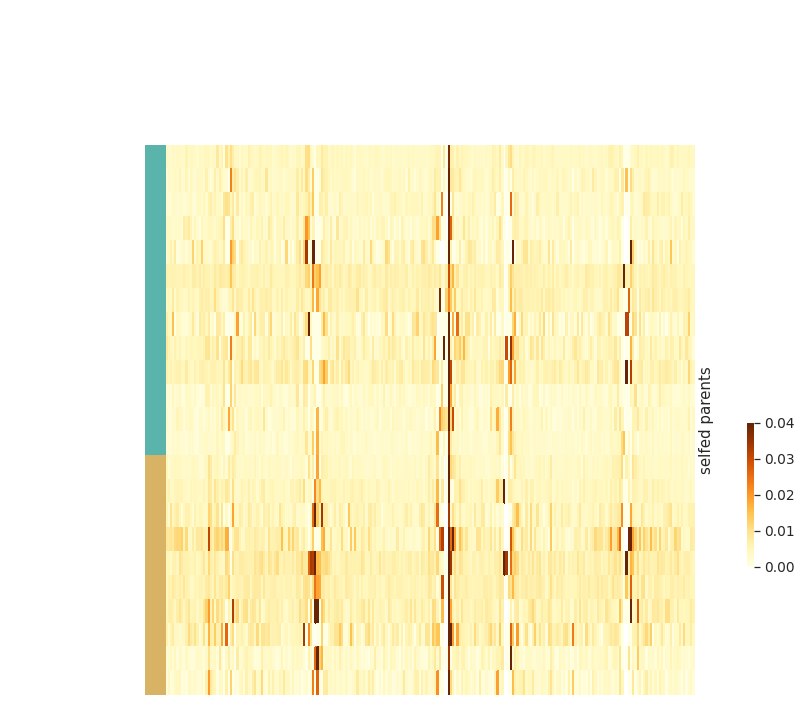

In [15]:
ef_data = combined_mcs['deviation_per_windows_500kb'][combined_mcs['deviation_per_windows_500kb'].index.str.startswith("dev_0")].T.astype(float)
ef_data.columns = tair10.get_genomewide_inds( pd.Series(ef_data.columns.str.replace("dev_0_", "")) )
# ef_data = ef_data.dropna(how = "all")
ef_data = ef_data[ef_data.isna().sum(1) < 10]
ef_data = ef_data.dropna(how = "all").T.dropna(how = "all").T

p = sns.clustermap(ef_data, col_cluster=False, row_cluster=False, cmap = "YlOrBr", metric="canberra", vmax = 0.04, vmin = 0, row_colors= pd.Series(parent_color).loc[combined_mcs['samples'].reindex(ef_data.index)['direction']].values, yticklabels=0,xticklabels=0,cbar_pos=(1.05, .2, .01, .2)  )
p.ax_heatmap.set_ylabel("selfed parents")

# plt.tight_layout()
plt.show()

## GC content vs CG gbM gain and loss

In [148]:
%%time

combined_mcs['gc_vs_deviation'] = pd.DataFrame(index = combined_mcs['deviation_per_windows_500kb'].index[pd.Series(combined_mcs['deviation_per_windows_500kb'].index).str.startswith( "dev_0" )].str.replace("dev_0_", "") )
combined_mcs['gc_vs_deviation']['gc_content'] = pd.Series(combined_mcs['gc_vs_deviation'].index).apply( tair10.getGC ).values


ef_data = combined_mcs['deviation_per_windows_500kb'][combined_mcs['deviation_per_windows_500kb'].index.str.startswith("dev_0")].T.astype(float)
ef_data.columns = pd.Series(ef_data.columns.str.replace("dev_0_", "")) #tair10.get_genomewide_inds( 
combined_mcs['gc_vs_deviation']['deviation_0'] = ef_data.mean(0)

ef_data = combined_mcs['deviation_per_windows_500kb'][combined_mcs['deviation_per_windows_500kb'].index.str.startswith("dev_1")].T.astype(float)
ef_data.columns = pd.Series(ef_data.columns.str.replace("dev_1_", "")) #tair10.get_genomewide_inds( 
combined_mcs['gc_vs_deviation']['deviation_1'] = ef_data.mean(0)

CPU times: user 9.29 s, sys: 24.3 ms, total: 9.31 s
Wall time: 9.31 s


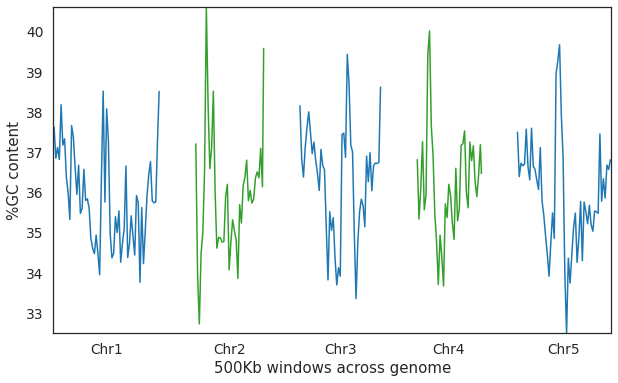

In [170]:
fig, ax = plt.subplots(figsize = (10, 6))

plotting_along_genome.manhattan_plot(x_ind=tair10.get_genomewide_inds( pd.Series(combined_mcs['gc_vs_deviation'].index) ), y_ind= combined_mcs['gc_vs_deviation']['gc_content'].values, plt_options={'lims': (32, 41), "line": True}, axs=ax)

ax.set_ylabel("%GC content")
ax.set_xlabel("500Kb windows across genome")

plt.show()

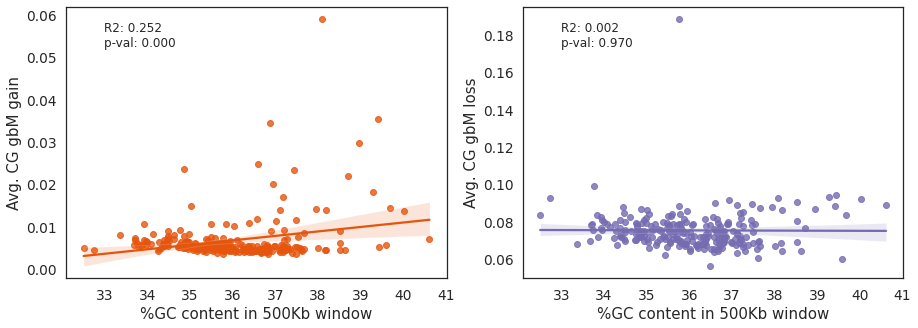

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# ef_data = ef_data[ef_data.index.str.startswith("T4") & ef_data.index.str.contains("P_6191")].mean(0)

lin_stat = spstats.linregress(combined_mcs['gc_vs_deviation'].dropna()['gc_content'], combined_mcs['gc_vs_deviation'].dropna()['deviation_0'])

sns.regplot(data = combined_mcs['gc_vs_deviation'], x = 'gc_content', y= 'deviation_0', ax=axes.flat[0], color=cb.sequential.Oranges_5.hex_colors[3] )
axes.flat[0].set_ylabel( "Avg. CG gbM gain" )
axes.flat[0].set_xlabel( "%GC content in 500Kb window" )
plt.text(0.1, 0.8, "R2: %.3f\np-val: %.3f\n" %(lin_stat.rvalue, lin_stat.pvalue), transform = axes.flat[0].transAxes, size = 12 )

lin_stat = spstats.linregress(combined_mcs['gc_vs_deviation'].dropna()['gc_content'], combined_mcs['gc_vs_deviation'].dropna()['deviation_1'])

sns.regplot(data = combined_mcs['gc_vs_deviation'], x = 'gc_content', y= 'deviation_1', ax=axes.flat[1], color=cb.sequential.Purples_5.hex_colors[3] )
axes.flat[1].set_ylabel( "Avg. CG gbM loss" )
axes.flat[1].set_xlabel( "%GC content in 500Kb window" )
plt.text(0.1, 0.8, "R2: %.3f\np-val: %.3f\n" %(lin_stat.rvalue, lin_stat.pvalue), transform = axes.flat[1].transAxes, size = 12 )


# plt.tight_layout()

plt.show()

## Epimutation signatures

Do gains and losses occur on specific context

In [10]:
%%time

combined_mcs['permeths_subpop']['mc_class'] = combined_mcs['meths'].__getattr__("mc_class", combined_mcs['permeths_subpop'].index.values )
cg_classes = combined_mcs['permeths_subpop'].reset_index().groupby('mc_class').groups
combined_mcs['epi_signatures'] = combined_mcs['samples'].copy()

for ef_cg_context in combined_mcs['permeths_subpop'].reset_index().groupby("mc_class"):
    ef_deviation = bshap.combinemeths.calculate_deviations_per_populations(combined_mcs['mc_count'][ef_cg_context[1].index.values,:], combined_mcs['mc_total'][ef_cg_context[1].index.values,:], combined_mcs['parent_inds'])['deviations']
    combined_mcs['epi_signatures'].loc[:,'deviation_0_' + ef_cg_context[0]] = ef_deviation['deviation_0'].values
    combined_mcs['epi_signatures'].loc[:,'deviation_1_' + ef_cg_context[0]] = ef_deviation['deviation_1'].values

CPU times: user 20.3 s, sys: 11.6 s, total: 31.8 s
Wall time: 32 s


CGT vs. CGC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.934e-01 U_stat=9.740e+02
CGA vs. CGC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.097e-01 U_stat=1.039e+03
CGA vs. CGT: Mann-Whitney-Wilcoxon test two-sided, P_val:4.266e-03 U_stat=7.615e+02
CGT vs. CGC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.083e-03 U_stat=1.520e+03
CGA vs. CGC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.679e-01 U_stat=1.146e+03


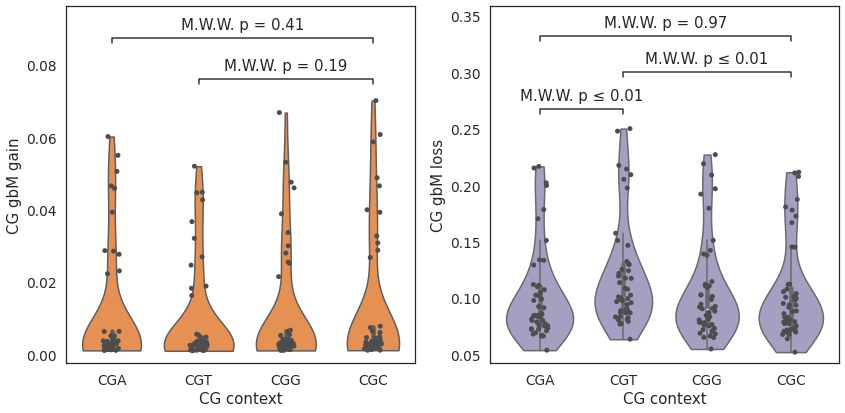

In [32]:
configuration = {
    'test':'Mann-Whitney',
    'comparisons_correction':None,
    'text_format':'star',
    "text_format":"simple", 
    "text_offset":6
}


fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))

ef_data = combined_mcs['epi_signatures'].loc[:,combined_mcs['epi_signatures'].columns.str.startswith("deviation_0")]
ef_data.columns = ef_data.columns.str.replace("deviation_0_", "")
ef_data = pd.melt(ef_data).dropna()


fig_args = {
    "data": ef_data, 
    "y": "value",
    "x": "variable",
    "order": ['CGA', 'CGT', 'CGG', 'CGC'],
    "ax": axs.flat[0]
}
sns.violinplot(**fig_args, cut = 0, color=cb.sequential.Oranges_5.hex_colors[2],fliersize=0)

sns.stripplot(**fig_args, dodge=True, palette=[".3"] * 4, jitter=True)

axs.flat[0].set_ylabel( "CG gbM gain" )
axs.flat[0].set_xlabel( "CG context" )
# axs.flat[0].set_ylim( (-0.001, 0.02) )
annotator = Annotator(**fig_args, pairs = [('CGC', 'CGA'), ('CGC', 'CGT')], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()


ef_data = combined_mcs['epi_signatures'].loc[:,combined_mcs['epi_signatures'].columns.str.startswith("deviation_1")]
ef_data.columns = ef_data.columns.str.replace("deviation_1_", "")
ef_data = pd.melt(ef_data).dropna()

fig_args = {
    "data": ef_data, 
    "y": "value",
    "x": "variable",
    "order": ['CGA', 'CGT', 'CGG', 'CGC'],
    'ax':axs.flat[1]
}
sns.violinplot(**fig_args, cut = 0, color=cb.sequential.Purples_5.hex_colors[2], fliersize=0)
sns.stripplot(**fig_args, dodge=True, palette=[".3"] * 4, jitter=True  )
annotator = Annotator(**fig_args, pairs = [('CGC', 'CGA'), ('CGC', 'CGT'), ('CGA', 'CGT')], plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()
axs.flat[1].set_ylabel( "CG gbM loss" )
axs.flat[1].set_xlabel( "CG context" )


fig.tight_layout()
plt.show()

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   CGA    CGC   0.0007   0.9 -0.0031 0.0044  False
   CGA    CGG   0.0005   0.9 -0.0032 0.0043  False
   CGA    CGT   0.0001   0.9 -0.0036 0.0038  False
   CGC    CGG  -0.0001   0.9 -0.0039 0.0036  False
   CGC    CGT  -0.0006   0.9 -0.0043 0.0031  False
   CGG    CGT  -0.0005   0.9 -0.0042 0.0033  False
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper reject
--------------------------------------------------
     0      1  -0.0003 0.7814 -0.0026 0.002  False
--------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   CGA    CGC   0.0043    0.9 -0.0127 0.0214  False
   CGA    CGG   0.0023   

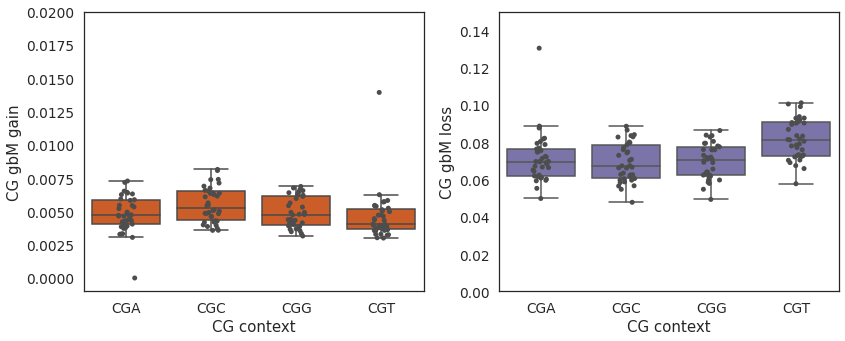

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))


ef_data = combined_mcs['epi_signatures'].loc[:,combined_mcs['epi_signatures'].columns.str.startswith("deviation_0")]
ef_data.columns = ef_data.columns.str.replace("deviation_0_", "")
ef_data = pd.melt(ef_data).dropna()

# print( sm.stats.anova_lm( ols('value ~ variable', data = ef_data ).fit() ) )
print(sm.stats.multicomp.pairwise_tukeyhsd( ef_data['value'].values, ef_data['variable'].values ))
print(sm.stats.multicomp.pairwise_tukeyhsd( ef_data['value'].values, np.array(ef_data['variable'] == "CGT").astype(int) ))

sns.boxplot(data = ef_data, x = "variable", y = "value", color=cb.sequential.Oranges_5.hex_colors[3],ax=axes.flat[0], fliersize=0)
sns.stripplot(data = ef_data, x = "variable", y = "value", dodge=True, palette=[".3"] * 4, jitter=True, ax=axes.flat[0])

# sns.swarmplot(data = ef_data, x = "variable", y = "value", color='.5',ax=axes.flat[0])
axes.flat[0].set_ylabel( "CG gbM gain" )
axes.flat[0].set_xlabel( "CG context" )
axes.flat[0].set_ylim( (-0.001, 0.02) )
# plt.text(0.1, 0.8, "R2: %.3f\np-val: %.3f\n" %(lin_stat.rvalue, lin_stat.pvalue), transform = axes.flat[0].transAxes, size = 12 )



ef_data = combined_mcs['epi_signatures'].loc[:,combined_mcs['epi_signatures'].columns.str.startswith("deviation_1")]
ef_data.columns = ef_data.columns.str.replace("deviation_1_", "")
ef_data = pd.melt(ef_data).dropna()
# print( sm.stats.anova_lm( ols('value ~ variable', data = ef_data ).fit() ) )
print(sm.stats.multicomp.pairwise_tukeyhsd( ef_data['value'].values, ef_data['variable'].values ))
print(sm.stats.multicomp.pairwise_tukeyhsd( ef_data['value'].values, np.array(ef_data['variable'] == "CGT").astype(int) ))

sns.boxplot(data = ef_data, x = "variable", y = "value", color=cb.sequential.Purples_5.hex_colors[3],ax=axes.flat[1], fliersize=0)
sns.stripplot(data = ef_data, x = "variable", y = "value", dodge=True, palette=[".3"] * 4, jitter=True, ax=axes.flat[1])
# sns.swarmplot(data = ef_data, x = "variable", y = "value", color='.5',ax=axes.flat[1])
axes.flat[1].set_ylabel( "CG gbM loss" )
axes.flat[1].set_xlabel( "CG context" )
axes.flat[1].set_ylim( (0, 0.15) )
# plt.text(0.1, 0.8, "R2: %.3f\np-val: %.3f\n" %(lin_stat.rvalue, lin_stat.pvalue), transform = axes.flat[1].transAxes, size = 12 )


fig.tight_layout()

plt.show()

## nonCG change near the gain or loss

In [17]:
combined_mcs['devs'].mc_meths

mc_count_P_6046  mc_total_P_6046  P_6046  mc_count_P_6191  \
0                    0.0             31.0    0.00              0.0   
1                    0.0             17.0    0.00              0.0   
2                    0.0             23.0    0.00              0.0   
3                    0.0             18.0    0.00              0.0   
4                    0.0             28.0    0.00              0.0   
...                  ...              ...     ...              ...   
2388465              0.0             31.0    0.00              0.0   
2388466              1.0             20.0    0.05              0.0   
2388467              0.0             30.0    0.00              0.0   
2388468              0.0             18.0    0.00              0.0   
2388469              0.0             29.0    0.00              0.0   

         mc_total_P_6191  P_6191  mc_count_6046_T16  mc_total_6046_T16  \
0                   24.0     0.0                0.0                4.0   
1                   22.0     0.0                0.0                2.0   
2                   18.0     0.0                0.0                2.0   
3                   16.0     0.0                0.0                3.0   
4                   17.0     0.0                0.0                2.0   
...                  ...     ...                ...                ...   
2388465             28.0     0.0                0.0                9.0   
2388466             27.0     0.0                0.0                4.0   
2388467             30.0     0.0                0.0                9.0   
2388468             28.0     0.0                0.0                4.0   
2388469             29.0     0.0                0.0                9.0   

         6046_T16  mc_count_6046_T4  ...  mc_count_6191_T16  \
0             NaN               0.0  ...                0.0   
1             NaN               0.0  ...                0.0   
2             NaN               0.0  ...                0.0   
3             NaN               0.0  ...                0.0   
4             NaN               0.0  ...                0.0   
...           ...               ...  ...                ...   
2388465       0.0               0.0  ...                0.0   
2388466       NaN               1.0  ...                0.0   
2388467       0.0               0.0  ...                0.0   
2388468       NaN               0.0  ...                0.0   
2388469       0.0               0.0  ...                0.0   

         mc_total_6191_T16  6191_T16  mc_count_6191_T4  mc_total_6191_T4  \
0                      3.0       NaN               0.0              21.0   
1                      5.0       NaN               0.0              17.0   
2                      4.0       NaN               0.0              14.0   
3                      2.0       NaN               0.0              14.0   
4                      4.0       NaN               0.0              13.0   
...                    ...       ...               ...               ...   
2388465                6.0       0.0               0.0              22.0   
2388466               10.0       0.0               0.0              17.0   
2388467                8.0       0.0               0.0              22.0   
2388468               11.0       0.0               0.0              17.0   
2388469                9.0       0.0               0.0              20.0   

         6191_T4  inherit_0_P_6046  inherit_1_P_6046  inherit_0_P_6191  \
0            0.0                 1                 0                 1   
1            0.0                 1                 0                 1   
2            0.0                 1                 0                 1   
3            0.0                 1                 0                 1   
4            0.0                 1                 0                 1   
...          ...               ...               ...               ...   
2388465      0.0                 1                 0                 1   
2388466      0.0 

## Histone marks and CG gbM gain and loss


Looking at the gene clusters made by Bhagyshree based on chromatin states.

* 1: House keeping
* 2: Expressed with H2AZ and low CG
* 3: Intron less with H2AZ GB
* 4: Bivalent (active + repressive marks)
* 5,6,7: Polycomb
* 8: Genes with H2AW (heterochromatic)

In [84]:
%%time

newSetPCG = pd.read_csv( "/groups/nordborg/projects/cegs/rahul/011.states.bhagyshree/002.GeneClusters/newSetPCG_all.bed", sep = "\t", header=None )

combined_mcs['deviation_in_chromatin_state'] = combined_mcs['samples'].copy()

combined_mcs['mcg_gbm_bed']['end'] = combined_mcs['mcg_gbm_bed']['start'] + 1
ef_intersect_bed = bshap.run_bedtools.get_intersect_bed_ix( reference_bed=newSetPCG, query_bed=combined_mcs['mcg_gbm_bed'], just_names=False )

CPU times: user 23.2 s, sys: 826 ms, total: 24 s
Wall time: 33.9 s


In [85]:
%%time

for ef in newSetPCG.groupby( 6 ):
    ef_query_ix = ef_intersect_bed[np.isin(ef_intersect_bed['ref_ix'], ef[1].index.values)]['query_ix']
    ef_deviations = bshap.combinemeths.calculate_deviations_per_populations(combined_mcs['mc_count'][ef_query_ix,:], combined_mcs['mc_total'][ef_query_ix,:], combined_mcs['parent_inds'] )
    ef_deviations['deviations'].index = combined_mcs['meths'].file_ids[ef_deviations['deviations'].index.values]
    combined_mcs['deviation_in_chromatin_state'] = pd.merge(combined_mcs['deviation_in_chromatin_state'], ef_deviations['deviations'].loc[:,["deviation_0", "deviation_1", "mc_total_0", "mc_total_1"]].rename(lambda x: x + ":" + ef[0], axis = "columns"), left_index=True, right_index=True)
    
combined_mcs['deviation_in_chromatin_state']['clr_parent'] = pd.Series( parent_color ).loc[combined_mcs['deviation_in_chromatin_state']['direction']].values
combined_mcs['deviation_in_chromatin_state']['clr_temperature'] = pd.Series( temp_color ).loc[combined_mcs['deviation_in_chromatin_state']['temp']].values

CPU times: user 33.2 s, sys: 12.8 s, total: 46 s
Wall time: 46 s


In [66]:
for ef in newSetPCG.groupby( 6 ):
    ef_query_ix = ef_intersect_bed[np.isin(ef_intersect_bed['ref_ix'], ef[1].index.values)]['query_ix']
    print(ef[0])
    print(( combined_mcs["mcs_df_cats"]['permeths_subpop'].iloc[ef_query_ix]['6046_T16'] - combined_mcs["mcs_df_cats"]['permeths_subpop'].iloc[ef_query_ix]['6191_T16'] ).describe().loc[['mean', 'std']])

nSetPCG_1
mean    0.067972
std     0.361564
dtype: float64
nSetPCG_2
mean    0.029619
std     0.242633
dtype: float64
nSetPCG_3
mean    0.007327
std     0.131215
dtype: float64
nSetPCG_4
mean    0.067576
std     0.369280
dtype: float64
nSetPCG_5
mean    0.007171
std     0.165619
dtype: float64
nSetPCG_6
mean    0.034780
std     0.260607
dtype: float64
nSetPCG_7
mean    0.008967
std     0.164343
dtype: float64
nSetPCG_8
mean   -0.031756
std     0.351942
dtype: float64


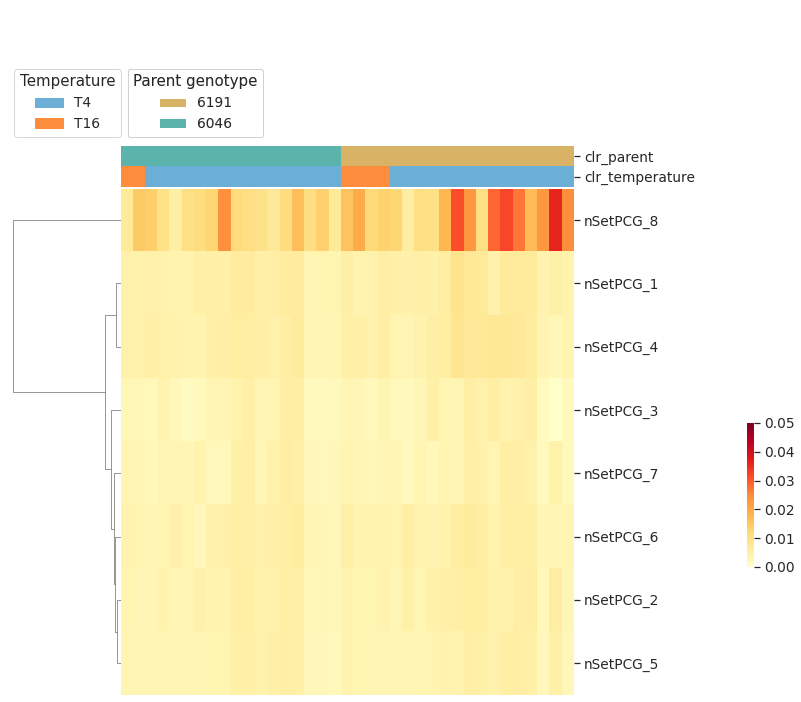

In [145]:
ef_data = combined_mcs['deviation_in_chromatin_state'].copy()
ef_data = ef_data.loc[:,ef_data.columns.str.startswith("deviation_0")]
ef_data = ef_data[ef_data.isna().mean(1) < 0.5]
ef_data.columns = ef_data.columns.str.replace("deviation_0:", "")


p1 = sns.clustermap( ef_data.dropna().T, cmap = "YlOrRd", col_cluster=False, xticklabels = False, vmin = 0, vmax = 0.05, method='ward', col_colors = combined_mcs['deviation_in_chromatin_state'].loc[ef_data.index, ['clr_parent', 'clr_temperature']], cbar_pos=(1.05, .2, .01, .2) )

l1 = p1.ax_heatmap.legend( [mpatches.Patch(color = ef[1]) for ef in pd.Series(temp_color).iteritems()], pd.Series(temp_color).index.values, bbox_to_anchor=(-0.25,1.25),loc="upper left", title = "Temperature" )

l2 = p1.ax_heatmap.legend( [mpatches.Patch(facecolor = ef[1]) for ef in pd.Series(parent_color).iteritems()], pd.Series(parent_color).index.values, title='Parent genotype', bbox_to_anchor=(0,1.25),loc="upper left" )


p1.ax_heatmap.add_artist(l1)
p1.ax_heatmap.add_artist(l2)

plt.show()

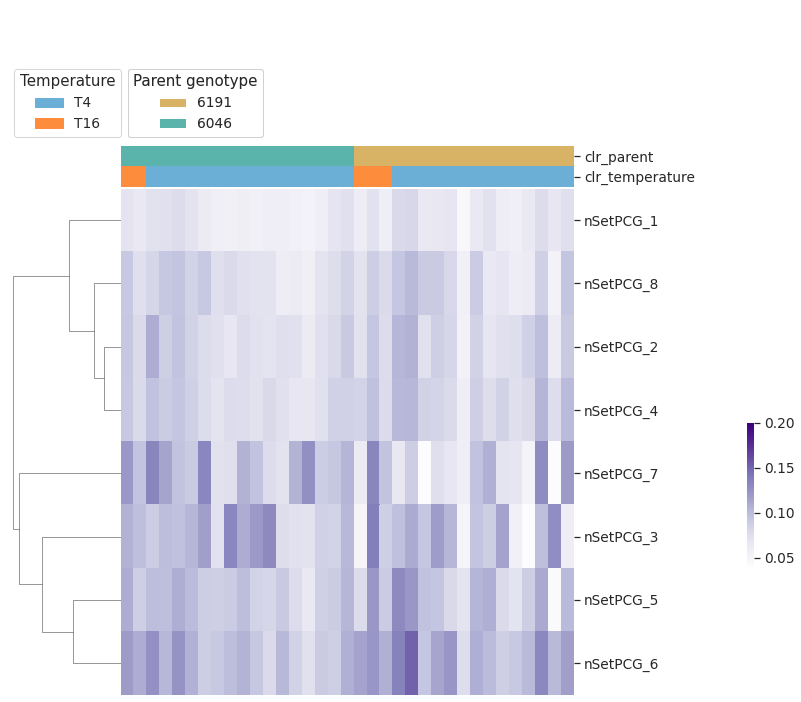

In [144]:
ef_data = combined_mcs['deviation_in_chromatin_state'].copy()
ef_data = ef_data.loc[:,ef_data.columns.str.startswith("deviation_1")]
ef_data = ef_data[ef_data.isna().mean(1) < 0.5]
ef_data.columns = ef_data.columns.str.replace("deviation_1:", "")


p1 = sns.clustermap( ef_data.dropna().T, cmap = "Purples", col_cluster=False, xticklabels = False, vmin = 0.04, vmax = 0.2, method='ward', col_colors = combined_mcs['deviation_in_chromatin_state'].loc[ef_data.index, ['clr_parent', 'clr_temperature']], cbar_pos=(1.05, .2, .01, .2))

l1 = p1.ax_heatmap.legend( [mpatches.Patch(color = ef[1]) for ef in pd.Series(temp_color).iteritems()], pd.Series(temp_color).index.values, bbox_to_anchor=(-0.25,1.25),loc="upper left", title = "Temperature" )

l2 = p1.ax_heatmap.legend( [mpatches.Patch(facecolor = ef[1]) for ef in pd.Series(parent_color).iteritems()], pd.Series(parent_color).index.values, title='Parent genotype', bbox_to_anchor=(0,1.25),loc="upper left" )


p1.ax_heatmap.add_artist(l1)
p1.ax_heatmap.add_artist(l2)

plt.show()

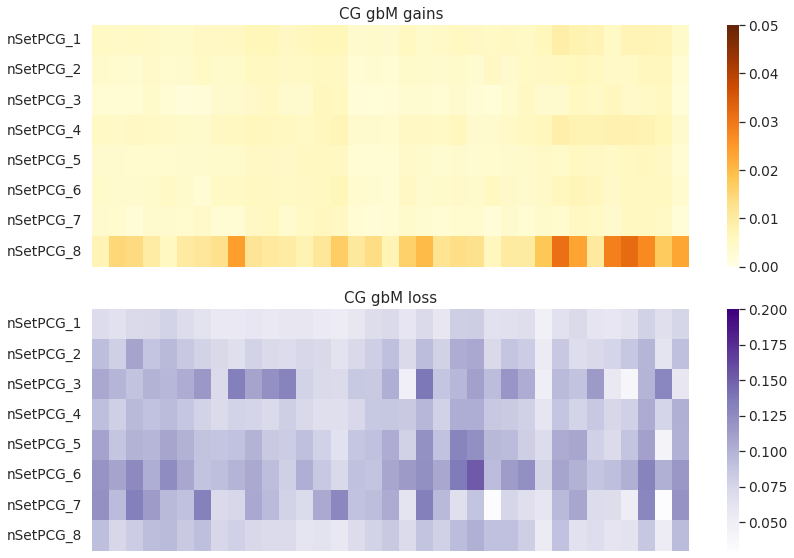

In [99]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize=(12, 8), sharex = True )

ef_data = combined_mcs['deviation_in_chromatin_state'].copy()
ef_data = ef_data.loc[:,ef_data.columns.str.startswith("deviation_0")]
ef_data.columns = ef_data.columns.str.replace("deviation_0:", "")

sns.heatmap( ef_data.dropna().T, cmap = "YlOrBr", xticklabels=False, ax=axes[0], vmin=0, vmax = 0.05)
axes[0].set_title("CG gbM gains")


ef_data = combined_mcs['deviation_in_chromatin_state'].copy()
ef_data = ef_data.loc[:,ef_data.columns.str.startswith("deviation_1")]
ef_data.columns = ef_data.columns.str.replace("deviation_1:", "")

sns.heatmap( ef_data.dropna().T, cmap = "Purples", xticklabels=False, ax = axes[1], vmin=0.03, vmax = 0.2 )
axes[1].set_title("CG gbM loss")

plt.tight_layout()
plt.show()

## Do sites next to a methylated cytosine have higher epimutation rates?

In [35]:
mcs_bed = pd.merge(combined_mcs['mcg_gbm_bed'].reset_index(drop = True), combined_mcs['devs'].mc_meths, left_index=True, right_index=True)

In [43]:
mcs_gain

chr     start  mc_count_P_6046  mc_total_P_6046  P_6046  \
0        Chr1      3673              0.0             31.0    0.00   
1        Chr1      3674              0.0             17.0    0.00   
2        Chr1      3697              0.0             23.0    0.00   
3        Chr1      3698              0.0             18.0    0.00   
4        Chr1      3707              0.0             28.0    0.00   
...       ...       ...              ...              ...     ...   
2388465  Chr5  26970553              0.0             31.0    0.00   
2388466  Chr5  26970565              1.0             20.0    0.05   
2388467  Chr5  26970566              0.0             30.0    0.00   
2388468  Chr5  26970574              0.0             18.0    0.00   
2388469  Chr5  26970575              0.0             29.0    0.00   

         mc_count_P_6191  mc_total_P_6191  P_6191  mc_count_6046_T16  \
0                    0.0             24.0     0.0                0.0   
1                    0.0             22.0     0.0                0.0   
2                    0.0             18.0     0.0                0.0   
3                    0.0             16.0     0.0                0.0   
4                    0.0             17.0     0.0                0.0   
...                  ...              ...     ...                ...   
2388465              0.0             28.0     0.0                0.0   
2388466              0.0             27.0     0.0                0.0   
2388467              0.0             30.0     0.0                0.0   
2388468              0.0             28.0     0.0                0.0   
2388469              0.0             29.0     0.0                0.0   

         mc_total_6046_T16  ...  mc_count_6191_T16  mc_total_6191_T16  \
0                      4.0  ...                0.0                3.0   
1                      2.0  ...                0.0                5.0   
2                      2.0  ...                0.0                4.0   
3                      3.0  ...                0.0                2.0   
4                      2.0  ...                0.0                4.0   
...                    ...  ...                ...                ...   
2388465                9.0  ...                0.0                6.0   
2388466                4.0  ...                0.0               10.0   
2388467                9.0  ...                0.0                8.0   
2388468                4.0  ...                0.0               11.0   
2388469                9.0  ...                0.0                9.0   

         6191_T16  mc_count_6191_T4  mc_total_6191_T4  6191_T4  \
0             NaN               0.0              21.0      0.0   
1             NaN               0.0              17.0      0.0   
2             NaN               0.0              14.0      0.0   
3             NaN               0.0              14.0      0.0   
4             NaN               0.0              13.0      0.0   
...           ...               ...               ...      ...   
2388465       0.0               0.0              22.0      0.0   
2388466       0.0               0.0              17.0      0.0   
2388467       0.0               0.0              22.0      0.0   
2388468       0.0               0.0              17.0      0.0   
2388469       0.0               0.0              20.0      0.0   

         inherit_0_P_6046  inherit_1_P_6046  inherit_0_P_6191  \
0                       1                 0                 1   
1                       1                 0                 1   
2                       1                 0                 1   
3                       1                 0                 1   
4                       1                 0                 1   
...                   ...               ...               ...   
2388465                 1                 0                 1   
2388466                 1                 0                 1   
2388467                 1                 0                 1

In [55]:
mcs_gain = mcs_bed[mcs_bed['inherit_0_P_6046'].astype(bool)].head(200000)
mcs_methylated = mcs_bed.loc[mcs_bed['inherit_1_P_6046'].astype(bool), "start"].head(100000)

In [35]:
%%time
req_mc_data = {}
req_mc_data['mc_data'] = pd.merge(combined_mcs['mcg_gbm_bed'], combined_mcs['permeths_subpop'], left_index=True, right_index=True  )
req_mc_data['mc_data'] = req_mc_data['mc_data'][req_mc_data['mc_data']['chr'] == 'Chr1']
req_mc_data['mc_data'] = req_mc_data['mc_data'][req_mc_data['mc_data']['start'] <= 2000000]  ## only taking first 2Mb in chr1, else the number of calculations are larger than 64bit 

CPU times: user 495 ms, sys: 209 ms, total: 704 ms
Wall time: 702 ms


In [36]:
%%time

ef_mc_permeths = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_0_P_6046'] == 1].loc[:,['start','P_6046']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_1_P_6046'] == 1].loc[:,['start','P_6046']].reset_index(drop = True)

req_mc_data['stat_pivot_mcg'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 17.4 s, sys: 11.3 s, total: 28.7 s
Wall time: 28.7 s


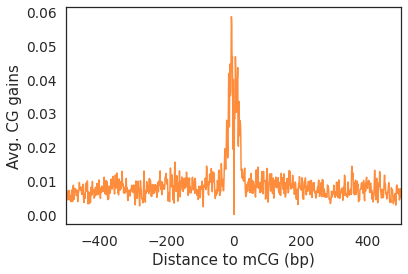

In [43]:
p = sns.lineplot(x = req_mc_data['stat_pivot_mcg'].index, y = req_mc_data['stat_pivot_mcg'].iloc[:,0].values, color = cb.sequential.YlOrRd_5.hex_colors[2])

# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg'].index, y =  pyquant.qtl_maps.smooth_sum(req_mc_data['stat_pivot_mcg'][('P_6046',  'mean')], 3))

p.set_xlabel("Distance to mCG (bp)")
p.set_ylabel("Avg. CG gains")

p.set_xlim((-500,500))

plt.show()

In [37]:
%%time

ef_mc_permeths = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_1_P_6046'] == 1].loc[:,['start','P_6046']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_1_P_6046'] == 1].loc[:,['start','P_6046']].reset_index(drop = True)

req_mc_data['stat_pivot_mcg_loses'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 3.03 s, sys: 1.76 s, total: 4.79 s
Wall time: 4.78 s


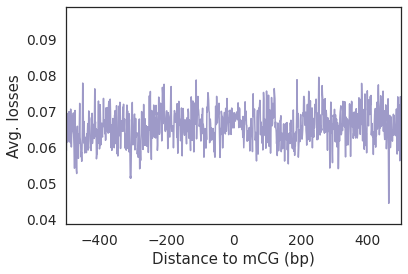

In [50]:
# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_loses'].index, y = 1 - req_mc_data['stat_pivot_mcg_loses'].iloc[:,0].values, color = cb.sequential.Purples_5.hex_colors[2])

p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_loses'].index, y =  pyquant.qtl_maps.smooth_sum(1 - req_mc_data['stat_pivot_mcg_loses'].iloc[:,0].values, 0), color = cb.sequential.Purples_5.hex_colors[2])

p.set_xlabel("Distance to mCG (bp)")
p.set_ylabel("Avg. losses")

p.set_xlim((-500,500))

plt.show()

In [38]:
%%time

ef_mc_permeths = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_0_P_6191'] == 1].loc[:,['start','P_6191']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_data'][(req_mc_data['mc_data']['inherit_1_P_6191'] == 1)].loc[:,['start','P_6191']].reset_index(drop = True)

# & (req_mc_data['mc_data']['inherit_1_P_6046'] == 1)

req_mc_data['stat_pivot_mcg_gain_6191'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 13.8 s, sys: 6.4 s, total: 20.2 s
Wall time: 20.2 s


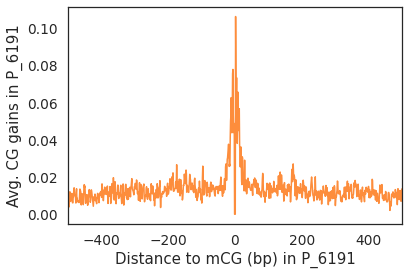

In [44]:
p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_gain_6191'].index, y = req_mc_data['stat_pivot_mcg_gain_6191'].iloc[:,0].values, color = cb.sequential.YlOrRd_5.hex_colors[2])

# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_gain_6191'].index, y =  pyquant.qtl_maps.smooth_sum( req_mc_data['stat_pivot_mcg_gain_6191'].iloc[:,0].values, 10), color = cb.sequential.YlOrRd_5.hex_colors[2])

p.set_xlabel("Distance to mCG (bp) in P_6191")
p.set_ylabel("Avg. CG gains in P_6191")

p.set_xlim((-500,500))
# p.set_ylim((0,0.1))

plt.show()

In [39]:
%%time

ef_mc_permeths = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_1_P_6191'] == 1].loc[:,['start','P_6191']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_data'][(req_mc_data['mc_data']['inherit_1_P_6191'] == 1)].loc[:,['start','P_6191']].reset_index(drop = True)

# & (req_mc_data['mc_data']['inherit_1_P_6046'] == 1)

req_mc_data['stat_pivot_mcg_losses_6191'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 1.57 s, sys: 894 ms, total: 2.47 s
Wall time: 2.47 s


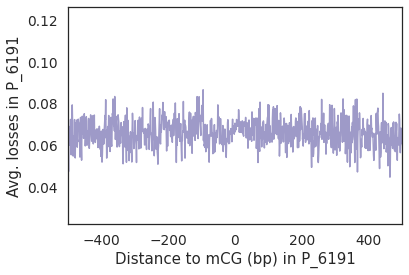

In [60]:
p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_losses_6191'].index, y = 1 - req_mc_data['stat_pivot_mcg_losses_6191'].iloc[:,0].values, color = cb.sequential.Purples_5.hex_colors[2])

# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_gain_6191'].index, y =  pyquant.qtl_maps.smooth_sum( req_mc_data['stat_pivot_mcg_gain_6191'].iloc[:,0].values, 10), color = cb.sequential.YlOrRd_5.hex_colors[2])

p.set_xlabel("Distance to mCG (bp) in P_6191")
p.set_ylabel("Avg. losses in P_6191")

p.set_xlim((-500,500))
# p.set_ylim((0,0.1))

plt.show()

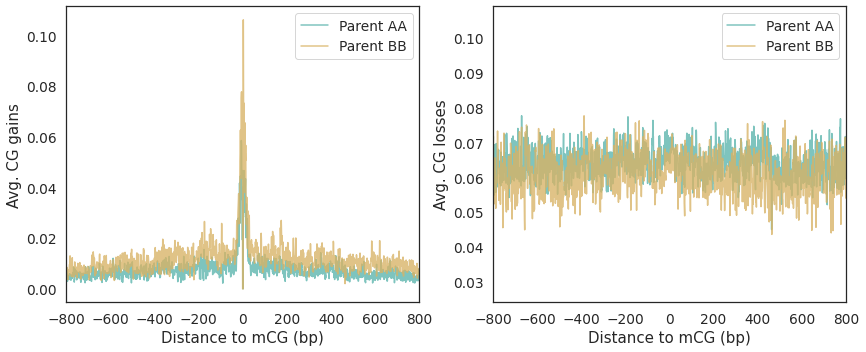

In [42]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5))

alpha_val = 0.78

sns.lineplot(x = req_mc_data['stat_pivot_mcg'].index, y = pyquant.utils.smooth_sum(req_mc_data['stat_pivot_mcg'].iloc[:,0], 0), color = parent_color['6046'], ax = axs.flat[0], label="Parent AA", alpha  = alpha_val)

sns.lineplot(x = req_mc_data['stat_pivot_mcg_gain_6191'].index, y = pyquant.utils.smooth_sum(req_mc_data['stat_pivot_mcg_gain_6191'].iloc[:,0], 0), color = parent_color['6191'], ax = axs.flat[0], label="Parent BB", alpha  = alpha_val)

# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg'].index, y =  pyquant.qtl_maps.smooth_sum(req_mc_data['stat_pivot_mcg'][('P_6046',  'mean')], 3))

axs.flat[0].set_xlabel("Distance to mCG (bp)")
axs.flat[0].set_ylabel("Avg. CG gains")

axs.flat[0].set_xlim((-800,800))



sns.lineplot(x = req_mc_data['stat_pivot_mcg_loses'].index, y = pyquant.utils.smooth_sum(1 - req_mc_data['stat_pivot_mcg_loses'].iloc[:,0], 0), color = parent_color['6046'], ax = axs.flat[1], label="Parent AA", alpha  = alpha_val)

sns.lineplot(x = req_mc_data['stat_pivot_mcg_losses_6191'].index, y = pyquant.utils.smooth_sum(1 - req_mc_data['stat_pivot_mcg_losses_6191'].iloc[:,0], 0), color = parent_color['6191'], ax = axs.flat[1], label="Parent BB", alpha  = alpha_val)

# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg'].index, y =  pyquant.qtl_maps.smooth_sum(req_mc_data['stat_pivot_mcg'][('P_6046',  'mean')], 3))

axs.flat[1].set_xlabel("Distance to mCG (bp)")
axs.flat[1].set_ylabel("Avg. CG losses")

axs.flat[1].set_xlim((-800,800))


fig.tight_layout()

plt.show()

In [87]:
%%time

ef_mc_permeths = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_0_P_6191'] == 1].loc[:,['start','P_6191']].dropna().reset_index(drop = True)  
### Only looking at the unmethylated cytosines at first
ef_mc_pos = req_mc_data['mc_data'][(req_mc_data['mc_data']['inherit_0_P_6191'] == 1) & (req_mc_data['mc_data']['inherit_1_P_6046'] == 1)].loc[:,['start','P_6191']].reset_index(drop = True)

req_mc_data['stat_pivot_mcg_gain_dmc_6191'] = bshap.stats.pivot_mCs_required_bed(ef_mc_permeths, ef_mc_pos, min_bp=5000  )

CPU times: user 1.63 s, sys: 1.28 s, total: 2.91 s
Wall time: 2.9 s


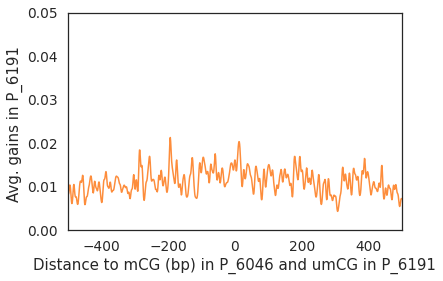

In [99]:
# p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_gain_dmc_6191'].index, y = req_mc_data['stat_pivot_mcg_gain_dmc_6191'].iloc[:,0].values, color = cb.sequential.YlOrRd_5.hex_colors[2])

p = sns.lineplot(x = req_mc_data['stat_pivot_mcg_gain_dmc_6191'].index, y =  pyquant.qtl_maps.smooth_sum( req_mc_data['stat_pivot_mcg_gain_dmc_6191'].iloc[:,0].values, 10), color = cb.sequential.YlOrRd_5.hex_colors[2])

p.set_xlabel("Distance to mCG (bp) in P_6046 and umCG in P_6191")
p.set_ylabel("Avg. gains in P_6191 ")

p.set_xlim((-500,500))
p.set_ylim((0,0.05))

plt.show()

In [ ]:
%%time

req_mc_data['umc_permeths'] = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_0_P_6191'] == 1].loc[:,['start','P_6191']].dropna().reset_index(drop = True)
req_mc_data['inherit_1_p6046'] = req_mc_data['mc_data'][req_mc_data['mc_data']['inherit_1_P_6046'] == 1].loc[:,['start','P_6046']].reset_index(drop = True)

# req_mc_data['pivot_mcg'] = req_mc_data['umc_permeths'].loc[np.tile(req_mc_data['umc_permeths'].index.values, req_mc_data['inherit_1_p6046'].shape[0])].reset_index(drop = True) 
# #### np.tile and np.repeat are both different
# req_mc_data['pivot_mcg']['start'] = req_mc_data['pivot_mcg']['start'].values - req_mc_data['inherit_1_p6046']['start'].loc[ np.repeat(req_mc_data['inherit_1_p6046'].index.values,  req_mc_data['umc_permeths'].shape[0]) ].values


# req_mc_data['pivot_mcg'] = req_mc_data['pivot_mcg'][np.abs(req_mc_data['pivot_mcg']['start']) < 5000]

# req_mc_data['stat_pivot_mcg'] = req_mc_data['pivot_mcg'].groupby( "start" ).describe()


# req_mc_data['mc_data'][(req_mc_data['mc_data']['inherit_0_P_6046'] == 1) & (req_mc_data['mc_data']['inherit_0_P_6191'] == 1)]#.loc[:,['start','P_6046']]#.dropna().reset_index(drop = True)

## What are the deviations in sites which are differentially methylated?

In [25]:
%%time

combined_mcs['devs'].mc_meths['DMC'] = 0
combined_mcs['devs'].mc_meths.loc[combined_mcs['devs'].mc_meths.loc[:,["inherit_0_P_6046", 'inherit_1_P_6191']].sum(1) == 2,'DMC'] = 1
combined_mcs['devs'].mc_meths.loc[combined_mcs['devs'].mc_meths.loc[:,["inherit_1_P_6046", 'inherit_0_P_6191']].sum(1) == 2,'DMC'] = 1




# ef_dmc_bed = combined_mcs['meths'].get_bed_pos_ix( combined_mcs['permeths_subpop'].index.values[combined_mcs['permeths_subpop']['DMC'].astype(bool) ], updown = 20)
# combined_mcs['permeths_subpop']['close_to_dmc'] = 0
# combined_mcs['permeths_subpop']['close_to_dmc'].iloc[bshap.run_bedtools.intersect_positions_bed(reference_bed=ef_dmc_bed, query_bed = combined_mcs['meths'].get_bed_pos_ix( combined_mcs['permeths_subpop'].index.values ).iloc[:,[0,1]] )] = 1



CPU times: user 147 ms, sys: 231 ms, total: 378 ms
Wall time: 369 ms


In [27]:
combined_mcs['devs'].mc_meths.columns

Index(['mc_count_P_6046', 'mc_total_P_6046', 'P_6046', 'mc_count_P_6191',
       'mc_total_P_6191', 'P_6191', 'inherit_0_P_6046', 'inherit_1_P_6046',
       'inherit_0_P_6191', 'inherit_1_P_6191', 'mc_count_6046_T16',
       'mc_total_6046_T16', '6046_T16', 'mc_count_6046_T4', 'mc_total_6046_T4',
       '6046_T4', 'mc_count_6191_T16', 'mc_total_6191_T16', '6191_T16',
       'mc_count_6191_T4', 'mc_total_6191_T4', '6191_T4', 'DMC'],
      dtype='object')

<AxesSubplot:xlabel='6046_T16', ylabel='Density'>

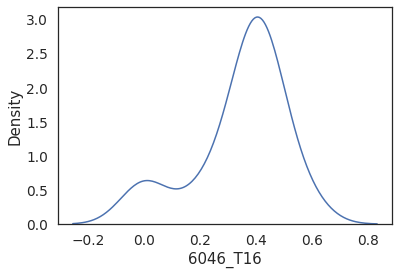

In [ ]:
sns.kdeplot(data = combined_mcs['devs'].mc_meths.iloc[np.where((combined_mcs['devs'].mc_meths['inherit_0_P_6046'] == 1) & (combined_mcs['devs'].mc_meths['DMC'] == 0))[0],:], x = '6046_T16')

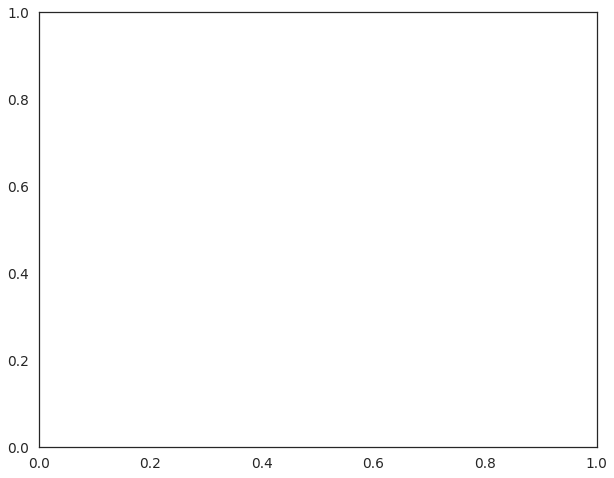

In [56]:
fig, axs = plt.subplots(figsize = (10,8))
# kde_plot_mc_meths(combined_mcs['devs'].mc_meths, np.where((combined_mcs['devs'].mc_meths['inherit_0_P_6046'] == 1) & (combined_mcs['devs'].mc_meths['DMC'] == 1))[0], '6046_T16', axs, color=cb.qualitative.Accent_5.hex_colors[4],  label = "6046_T16 DMC"  )

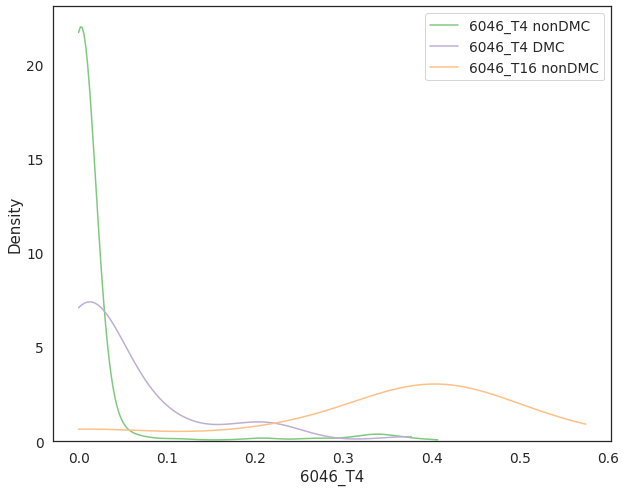

In [45]:
fig, axs = plt.subplots(figsize = (10,8))

def kde_plot_mc_meths(data, filter_pos_ix, col_name, axs, **kwargs):
    sns.kdeplot(data = data.iloc[filter_pos_ix,:], x = col_name, ax=axs, cut = 0, **kwargs)
    

    
kde_plot_mc_meths(combined_mcs['devs'].mc_meths, np.where((combined_mcs['devs'].mc_meths['inherit_0_P_6046'] == 1) & (combined_mcs['devs'].mc_meths['DMC'] == 0))[0], '6046_T4', axs, color=cb.qualitative.Accent_5.hex_colors[0],  label = "6046_T4 nonDMC"  )

kde_plot_mc_meths(combined_mcs['devs'].mc_meths, np.where((combined_mcs['devs'].mc_meths['inherit_0_P_6046'] == 1) & (combined_mcs['devs'].mc_meths['DMC'] == 1))[0],'6046_T4', axs, color=cb.qualitative.Accent_5.hex_colors[1],  label = "6046_T4 DMC"  )

kde_plot_mc_meths(combined_mcs['devs'].mc_meths, np.where((combined_mcs['devs'].mc_meths['inherit_0_P_6046'] == 1) & (combined_mcs['devs'].mc_meths['DMC'] == 0))[0], '6046_T16', axs, color=cb.qualitative.Accent_5.hex_colors[2],  label = "6046_T16 nonDMC"  )

kde_plot_mc_meths(combined_mcs['devs'].mc_meths, np.where((combined_mcs['devs'].mc_meths['inherit_0_P_6046'] == 1) & (combined_mcs['devs'].mc_meths['DMC'] == 1))[0], '6046_T16', axs, color=cb.qualitative.Accent_5.hex_colors[3],  label = "6046_T16 DMC"  )


# sns.kdeplot(data = combined_mcs['devs'].mc_meths[combined_mcs['devs'].mc_meths.loc[:,['inherit_0_P_6046','DMC']].sum(1) == 2 ], x = '6046_T4', ax=axs, color=cb.qualitative.Accent_5.hex_colors[1], label = "6046_T4 DMC")

# sns.kdeplot(data = combined_mcs['devs'].mc_meths[combined_mcs['devs'].mc_meths.loc[:,['inherit_0_P_6046','DMC']].sum(1) == 1 ], x = '6046_T4', ax=axs, color=cb.qualitative.Accent_5.hex_colors[0],  label = "inherit_0_P_6046")

# sns.kdeplot(data = combined_mcs['devs'].mc_meths[combined_mcs['devs'].mc_meths.loc[:,['inherit_0_P_6046','DMC']].sum(1) == 1 ], x = '6191_T4', ax=axs, color=cb.qualitative.Accent_5.hex_colors[1], label = "inherit_0_P_6191")


plt.legend()

In [25]:
%%time
req_mc_data = {}
req_mc_data['sample'] = combined_mcs['samples'].reindex( combined_mcs['meths'].file_ids ).reset_index()
req_mc_data['num_dmc'] = combined_mcs['permeths_subpop']['close_to_dmc'].sum()

req_mc_data['dmc_ix'] = combined_mcs['permeths_subpop']['close_to_dmc'].astype(bool).values
ef_devs = bshap.combinemeths.calculate_deviations_per_populations(combined_mcs['mc_count'][req_mc_data['dmc_ix'],:], combined_mcs['mc_total'][req_mc_data['dmc_ix'],:], combined_mcs['parent_inds'], params_meths={'prop_y_min': 25, 'max_meth_for_gain': 0.45, 'min_meth_for_loss': 0.55, 'mc_total_min': 3, 'conv_rate': 0.04}  )['deviations']
ef_devs.loc[ef_devs['mc_total_0'] < 10000, 'deviation_0'] = np.nan
ef_devs.loc[ef_devs['mc_total_1'] < 10000, 'deviation_1'] = np.nan
req_mc_data['sample'] = pd.merge(req_mc_data['sample'], ef_devs.add_suffix("_dmc"), left_index=True, right_index=True)


req_mc_data['no_dmc_ix'] = np.sort( np.random.choice( np.where(~combined_mcs['permeths_subpop']['close_to_dmc'].astype(bool))[0], req_mc_data['num_dmc'] ) )
req_mc_data['dmc_ix'] = combined_mcs['permeths_subpop']['close_to_dmc'].astype(bool).values
ef_devs = bshap.combinemeths.calculate_deviations_per_populations(combined_mcs['mc_count'][req_mc_data['no_dmc_ix'], :], combined_mcs['mc_total'][req_mc_data['no_dmc_ix'], :], combined_mcs['parent_inds'], params_meths={'prop_y_min': 25, 'max_meth_for_gain': 0.45, 'min_meth_for_loss': 0.55, 'mc_total_min': 3, 'conv_rate': 0.04}  )['deviations']
ef_devs.loc[ef_devs['mc_total_0'] < 10000, 'deviation_0'] = np.nan
ef_devs.loc[ef_devs['mc_total_1'] < 10000, 'deviation_1'] = np.nan
req_mc_data['sample'] = pd.merge(req_mc_data['sample'], ef_devs.add_suffix("_nodmc"), left_index=True, right_index=True)

CPU times: user 4.71 s, sys: 1.78 s, total: 6.49 s
Wall time: 6.49 s


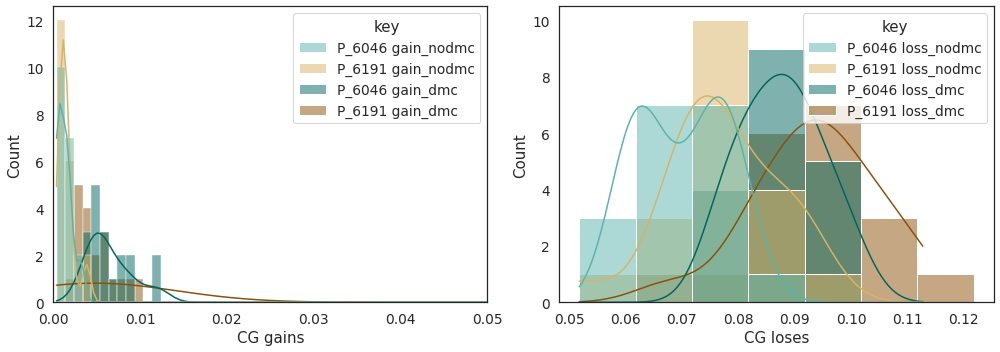

In [36]:
ef_data = pd.melt(req_mc_data['sample'], id_vars=['geno_dir'],value_vars=['deviation_0_nodmc', 'deviation_0_dmc', 'deviation_1_nodmc', 'deviation_1_dmc'] )
ef_data['variable'] = ef_data['variable'].str.replace("deviation_0", "gain").str.replace("deviation_1", "loss")
ef_data['key'] = ef_data['geno_dir'] + " " + ef_data['variable']


fig, axs = plt.subplots(ncols=2, figsize=(14, 5))


fig_args = {
    "data": ef_data[ef_data['variable'].str.startswith("gain")],
    "ax": axs.flat[0],
    "binwidth": 0.001,
    "palette": {
        "P_6046 gain_nodmc": cb.diverging.BrBG_7.hex_colors[5],
        "P_6046 gain_dmc": cb.diverging.BrBG_7.hex_colors[6],
        "P_6191 gain_nodmc": cb.diverging.BrBG_7.hex_colors[1],
        "P_6191 gain_dmc": cb.diverging.BrBG_7.hex_colors[0]
    }
}
sns.histplot(**fig_args, x = "value", hue = "key", kde = True)
axs.flat[0].set_xlabel("CG gains")
axs.flat[0].set_xlim((0, 0.05))
# axs.flat[0].legend()


fig_args = {
    "data": ef_data[ef_data['variable'].str.startswith("loss")],
    "ax": axs.flat[1],
    "binwidth": 0.01,
    "palette": {
        "P_6046 loss_nodmc": cb.diverging.BrBG_7.hex_colors[5],
        "P_6046 loss_dmc": cb.diverging.BrBG_7.hex_colors[6],
        "P_6191 loss_nodmc": cb.diverging.BrBG_7.hex_colors[1],
        "P_6191 loss_dmc": cb.diverging.BrBG_7.hex_colors[0]
    }
}
sns.histplot(**fig_args, x = "value", hue = "key", kde = True)
axs.flat[1].set_xlabel("CG loses")
# axs.flat[1].set_xlim((0, 0.05))
# axs.flat[1].legend()


fig.tight_layout()

plt.show()

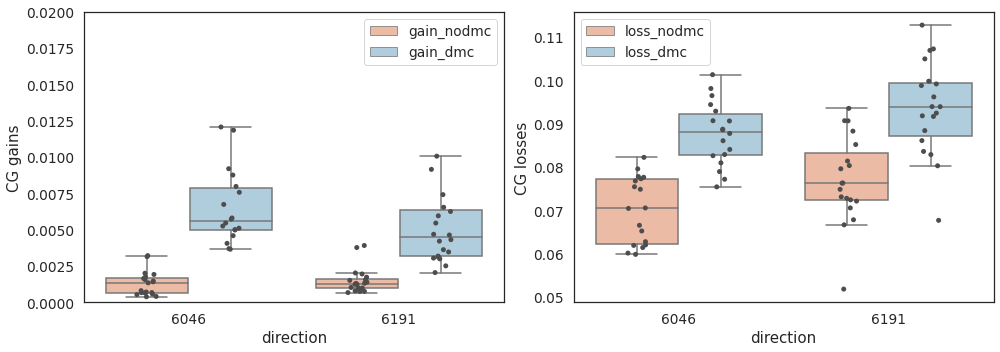

In [38]:
ef_data = pd.melt(req_mc_data['sample'], id_vars=['direction'],value_vars=['deviation_0_nodmc', 'deviation_0_dmc', 'deviation_1_nodmc', 'deviation_1_dmc'] )
ef_data['variable'] = ef_data['variable'].str.replace("deviation_0", "gain").str.replace("deviation_1", "loss")
ef_data['key'] = ef_data['direction'] + " " + ef_data['variable']


fig, axs = plt.subplots(ncols=2, figsize=(14, 5))


fig_args = {
    "data": ef_data[ef_data['variable'].str.startswith("gain")],
    "ax": axs.flat[0],
    "x": "direction", 
    "hue": "variable",
    "y": "value"
}
sns.boxplot(**fig_args, fliersize=0, palette="RdBu" )
sns.stripplot(**fig_args, dodge=True, palette=[".3"] * 4 )
axs.flat[0].set_ylabel("CG gains")
axs.flat[0].set_ylim((0, 0.02))
handles, labels = axs.flat[0].get_legend_handles_labels()
axs.flat[0].legend(handles[0:2], labels[0:2])


fig_args = {
    "data": ef_data[ef_data['variable'].str.startswith("loss")],
    "ax": axs.flat[1],
    "x": "direction", 
    "hue": "variable",
    "y": "value"
}
sns.boxplot(**fig_args, fliersize=0, palette="RdBu" )
sns.stripplot(**fig_args, dodge=True, palette=[".3"] * 4 )
axs.flat[1].set_ylabel("CG losses")
# # axs.flat[1].set_xlim((0, 0.05))
handles, labels = axs.flat[1].get_legend_handles_labels()
axs.flat[1].legend(handles[0:2], labels[0:2])


fig.tight_layout()

plt.show()

## Is there autocorrelaton in CG gain and loss sites?

In [9]:
auto_corr = pd.DataFrame( index = np.arange(300), columns=['inherit_0', 'inherit_1']  )
for ef in auto_corr.index.values:
    auto_corr.loc[ef, "inherit_0"] = combined_mcs['permeths_subpop'].loc[combined_mcs['permeths_subpop']['inherit_0_P_6046'].astype(bool), "P_6046"].autocorr(lag=ef)
    auto_corr.loc[ef, "inherit_1"] = combined_mcs['permeths_subpop'].loc[combined_mcs['permeths_subpop']['inherit_1_P_6046'].astype(bool), "P_6046"].autocorr(lag=ef)

In [25]:
pd.Series(combined_mcs['mcg_gbm_bed']['start'][1:].values - combined_mcs['mcg_gbm_bed']['start'][:-1].values).describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

count    2.570363e+06
mean     1.049148e+01
std      2.933279e+04
min     -3.042415e+07
5%       1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+01
80%      2.800000e+01
95%      1.310000e+02
max      7.039910e+05
dtype: float64

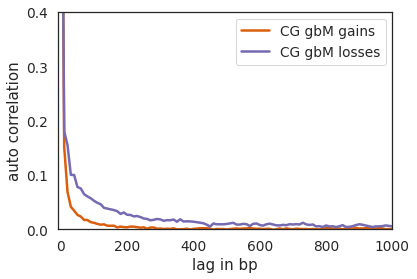

In [42]:

sns.lineplot(x = auto_corr.index.values * 10, y = auto_corr['inherit_0'].values, color = cb.sequential.YlOrBr_5.hex_colors[3], linewidth=2.5, label = "CG gbM gains" )
sns.lineplot(x = auto_corr.index.values * 10, y = auto_corr['inherit_1'].values, color = cb.sequential.Purples_5.hex_colors[3], linewidth=2.5, label = "CG gbM losses" )
plt.ylim((0, 0.4))
plt.xlim((-10, 1000))
plt.xlabel("lag in bp")
plt.ylabel("auto correlation")
plt.legend()

# ARCHIVE

In [27]:
pyqstats.bootstrap(combined_mcs['sample_deviation'].loc[combined_mcs['sample_deviation']['geno_dir'] == "P_6046", "deviation_0"], combined_mcs['sample_deviation'].loc[combined_mcs['sample_deviation']['geno_dir'] == "P_6191", "deviation_0"] )

(0.0597,
 {'avg_metric': 0.003694196009718322,
  'metric_ci_lb': 0.003052429008371899,
  'metric_ci_ub': 0.004378513277714552},
 {'avg_metric': 0.004945595538211062,
  'metric_ci_lb': 0.004193983341939659,
  'metric_ci_ub': 0.005785013383284971})

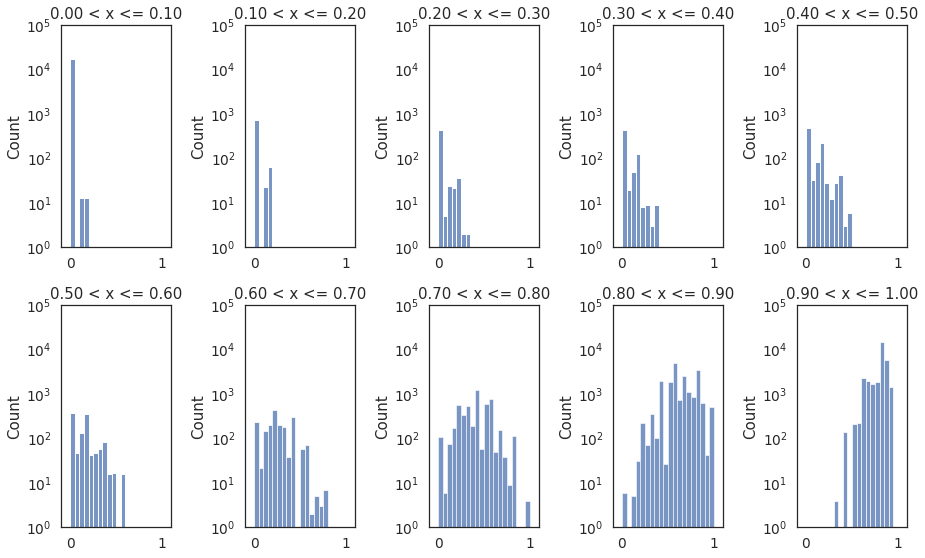

CPU times: user 5.66 s, sys: 273 ms, total: 5.93 s
Wall time: 5.66 s


In [230]:
%%time


ef_bins = np.linspace(0.001,1,11)

fig, axes = plt.subplots(figsize=(13,8), ncols=5, nrows=2)

for e_bin_ix, ax in zip(np.arange(1, ef_bins.shape[0]), axes.flat):
#     print("%.2f <= x < %.2f" % (ef_bins[e_bin_ix-1], ef_bins[e_bin_ix]) )
    ef_data = (req_permeth['pooled_6046_T4'] > ef_bins[e_bin_ix-1]) & (req_permeth['pooled_6046_T4'] <= ef_bins[e_bin_ix])
#     snpmatch.snpmatch.np_get_fraction( req_count[ef_data,:].flatten(), req_total[ef_data,:].flatten(), y_min = 4)
    sns.histplot( req_permeth.loc[ef_data]['fracInd_fixed_6046_T4'], ax = ax, binwidth = 0.05 ) 
    ax.set_xlabel("")
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlim((-0.1, 1.1))
    ax.set_ylim((1, 10**5))
    ax.set_title("%.2f < x <= %.2f" % (ef_bins[e_bin_ix-1], ef_bins[e_bin_ix]))

plt.tight_layout()
plt.show()

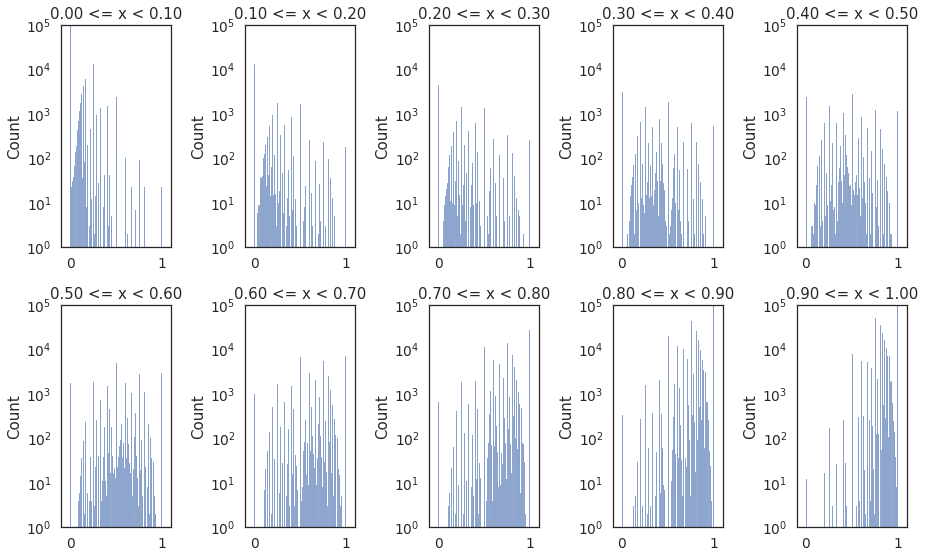

CPU times: user 28.6 s, sys: 4.89 s, total: 33.4 s
Wall time: 30 s


In [16]:
%%time


ef_bins = np.linspace(0,1,11)

fig, axes = plt.subplots(figsize=(13,8), ncols=5, nrows=2)

for e_bin_ix, ax in zip(np.arange(1, ef_bins.shape[0]), axes.flat):
#     print("%.2f <= x < %.2f" % (ef_bins[e_bin_ix-1], ef_bins[e_bin_ix]) )
    ef_data = (req_permeth['pooled_6046_T4'] >= ef_bins[e_bin_ix-1]) & (req_permeth['pooled_6046_T4'] < ef_bins[e_bin_ix])
#     snpmatch.snpmatch.np_get_fraction( req_count[ef_data,:].flatten(), req_total[ef_data,:].flatten(), y_min = 4)
    sns.histplot( req_meths[np.where(ef_data)[0],:][:,np.where(combined_mcs['samples']['dir_temp'] == "6046_T4")[0]].flatten(), ax = ax, binwidth = 0.01 ) 
    ax.set_yscale('log', nonposy='clip')
    ax.set_ylim((1, 10**5))
    ax.set_xlim((-0.1, 1.1))
    ax.set_title("%.2f <= x < %.2f" % (ef_bins[e_bin_ix-1], ef_bins[e_bin_ix]))

plt.tight_layout()
plt.show()

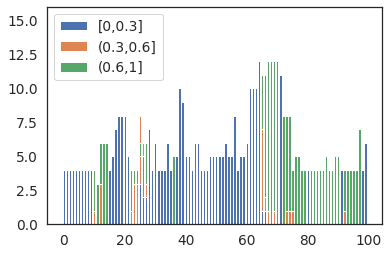

CPU times: user 741 ms, sys: 2.3 ms, total: 743 ms
Wall time: 739 ms


In [149]:
%%time
ef_data = pd.DataFrame( req_meths[:,np.where(combined_mcs['samples']['dir_temp'] == "6046_T4")[0]] ).iloc[0:50000,:]
ef_data = ef_data.loc[(~pd.isna(ef_data)).sum(axis =1) > 3]

ef_data = ef_data.apply(lambda x: pd.cut(x, bins = [0, 0.33, 0.66, 1], include_lowest=True).value_counts(), axis=1 )


fig, ax = plt.subplots()

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,0].values[0:100], label="[0,0.3]")

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,1].values[0:100], bottom=ef_data.iloc[:,0].values[0:100],label="(0.3,0.6]")

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,2].values[0:100], bottom=ef_data.iloc[:,1].values[0:100],label="(0.6,1]")


ax.set_ylim((0, 16))

# ax.plot( np.arange(ef_data.shape[0]), 1 - smooth_sum(snpmatch.snpmatch.np_get_fraction( ef_data.iloc[:,0].values, ef_data.sum(1).values, y_min = 3), n_times=0), 'r-'  )
# ax.set_xlim((0, 100))

plt.legend()
plt.show()

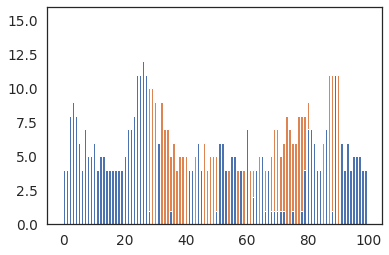

CPU times: user 18.9 s, sys: 325 ms, total: 19.2 s
Wall time: 19.2 s


In [147]:
%%time
ef_data = pd.DataFrame( req_meths[:,np.where(combined_mcs['samples']['dir_temp'] == "6191_T4")[0]] ).iloc[0:50000,:]
ef_data = ef_data.loc[(~pd.isna(ef_data)).sum(axis =1) > 3]

ef_data = ef_data.apply(lambda x: pd.cut(x, bins = [0, 0.5, 1], include_lowest=True).value_counts(), axis=1 )


fig, ax = plt.subplots()

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,0].values[0:100], label="[0,0.5]")

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,1].values[0:100], bottom=ef_data.iloc[:,0].values[0:100],label="(0.5,1]")


ax.set_ylim((0, 16))

# ax.plot( np.arange(ef_data.shape[0]), 1 - smooth_sum(snpmatch.snpmatch.np_get_fraction( ef_data.iloc[:,0].values, ef_data.sum(1).values, y_min = 3), n_times=0), 'r-'  )
# ax.set_xlim((0, 100))

plt.show()

In [134]:
def smooth_sum(arr, n_times= 100):
    arr = np.array(arr, dtype = float)
    for e_ind in np.arange(n_times):
        arr = np.insert(arr, 0, arr[0])
        arr = np.append(arr, arr[-1] )
        arr = sp.signal.convolve( arr, [0.25,0.5,0.25], mode = "same" )[1:-1]
#         arr = sp.signal.convolve( arr, [0.25,0.5,0.25] )[1:-1]
    return(arr)

(0.0, 100.0)

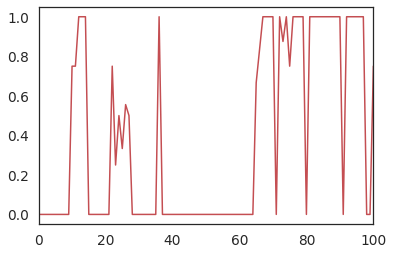

In [141]:
fig, ax = plt.subplots()

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,0].values[0:100], 0.35, label="[0,0.5]")

ax.bar(np.arange(ef_data.shape[0])[0:100], ef_data.iloc[:,1].values[0:100], 0.35, bottom=ef_data.iloc[:,0].values[0:100],label="(0.5,1]")

# ax.plot( np.arange(ef_data.shape[0]), 1 - smooth_sum(snpmatch.snpmatch.np_get_fraction( ef_data.iloc[:,0].values, ef_data.sum(1).values, y_min = 3), n_times=0), 'r-'  )

# ax.set_xlim((0, 100))



In [55]:
def truncated_Poisson(mu, min_value, size):
    temp_size = size
    while True:
        temp_size *= 2
        temp = sp.stats.poisson.rvs(mu, size=temp_size)
        truncated = temp[temp >= min_value]
        if len(truncated) >= size:
            return truncated[:size]

def bs_treated_sp(appr_meth, avg_cov, min_cov, n_iter = 1000):
    real_methylation = sp.random.normal(appr_meth, 0.01)
    if real_methylation < 0:
        real_methylation = 0
    if real_methylation > 1:
        real_methylation = 1
    if type(avg_cov) is int:
        bs_total = truncated_Poisson(avg_cov, min_cov, n_iter)
    elif type(avg_cov) is np.ndarray:
        bs_total = avg_cov
        n_iter = avg_cov.shape[0]
    bs_count = np.zeros(0)
    for n_i in range(n_iter):
        bs_count = np.append(bs_count, sp.random.binomial(bs_total[n_i], real_methylation, 1)[0] )
    bs_permeth = snpmatch.snpmatch.np_get_fraction(bs_count, bs_total, y_min = min_cov - 1)
    return(bs_permeth)

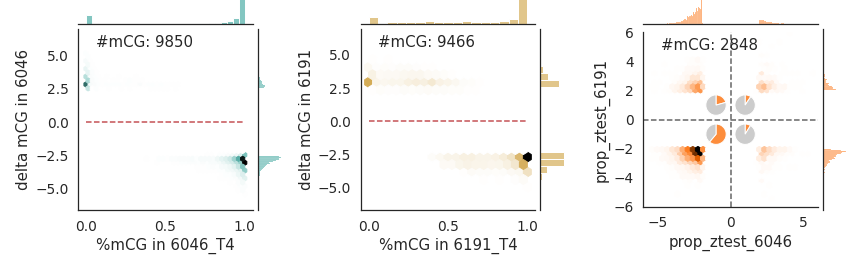

In [229]:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 3)

axes = {}

ef_data = combined_mcs['mcs_prop_test'].copy()
ef_data = ef_data.loc[:,['permeth_6046_T16','permeth_6046_T4','prop_ztest_6046','prop_pval_6046']].dropna()
ef_data = ef_data[ef_data['prop_pval_6046'] <= 0.01]
p1 = sns.jointplot(x = ef_data.iloc[:,1],y = ef_data.iloc[:,2], kind = "hex", color = cb.diverging.BrBG_7.hex_colors[5] )
p1.ax_joint.plot( (0, 1), (0, 0), 'r--' )
p1.ax_joint.set_xlabel( "%mCG in 6046_T4" )
p1.ax_joint.set_ylabel( "delta mCG in 6046" )

plt.text(0.1, 0.9, "#mCG: %s" % ef_data.shape[0], transform=p1.ax_joint.transAxes, size = 15 )
axes[0] = plotting.SeabornFig2Grid(p1, fig, gs[0])


ef_data = combined_mcs['mcs_prop_test'].copy()
# ef_data = ef_data.loc[:,['prop_ztest_6191','permeth_6191_T4', 'prop_pval_6191']].dropna()
ef_data = ef_data.loc[:,['permeth_6191_T16','permeth_6191_T4','prop_ztest_6191','prop_pval_6191']].dropna()
ef_data = ef_data[ef_data['prop_pval_6191'] <= 0.01]
p2 = sns.jointplot(x = ef_data.iloc[:,1],y = ef_data.iloc[:,2], kind = "hex", color = cb.diverging.BrBG_7.hex_colors[1] )
p2.ax_joint.plot( (0, 1), (0, 0), 'r--' )
p2.ax_joint.set_xlabel( "%mCG in 6191_T4" )
p2.ax_joint.set_ylabel( "delta mCG in 6191" )

plt.text(0.1, 0.9, "#mCG: %s" % ef_data.shape[0], transform=p2.ax_joint.transAxes, size = 15 )
axes[1] = plotting.SeabornFig2Grid(p2, fig, gs[1])


ef_data = combined_mcs['mcs_prop_test'].copy()
ef_data = ef_data.loc[(ef_data['prop_pval_6046'] <= 0.05) & (ef_data['prop_pval_6191'] <= 0.05)]
p3 = plotting.quadrant_plot( ef_data['prop_ztest_6046'], ef_data['prop_ztest_6191'], plt_limits={"xlim": 6, "ylim": 6, 'xpie': 1, 'ypie': 1, 'pie_rad': 0.7}, plt_options= {'color': cb.sequential.Oranges_5.hex_colors[2], 'annotation': "#mCG: %s"}, kind = "hex")
axes[1] = plotting.SeabornFig2Grid(p3, fig, gs[2])

gs.tight_layout(fig)

#gs.update(top=0.7)

plt.show()

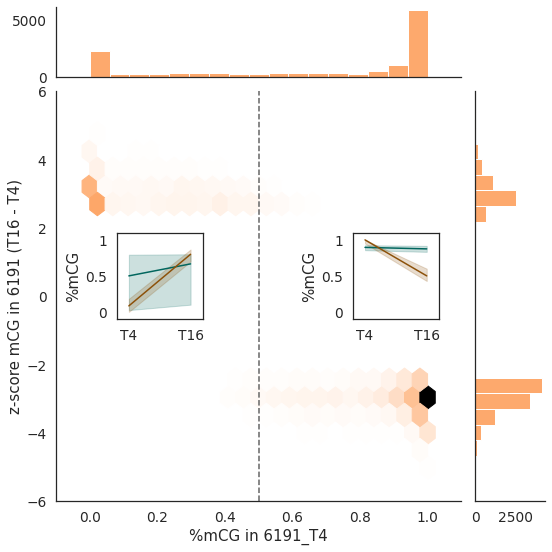

In [213]:
ef_data = combined_mcs['mcs_prop_test'].copy()
ef_data = ef_data.loc[:,['prop_ztest_6191','permeth_6191_T4', "permeth_6191_T16", 'permeth_6046_T4', 'permeth_6046_T16', 'prop_pval_6191']]
ef_data = ef_data[ef_data['prop_pval_6191'] < 0.01]

ci_ints = pd.Series( [0.4, 0.5, 0.6], index = ["40%", "50%", "60%"] )

p1 = sns.jointplot(x = ef_data['permeth_6191_T4'],y = ef_data['prop_ztest_6191'], kind = "hex", marginal_ticks=True, height=8, color= cb.sequential.Oranges_5.hex_colors[2],xlim=(-0.1, 1.1), ylim=(-6, 6)  )
# p1.ax_joint.plot( (0, 1), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3] )
p1.ax_joint.plot( (0.5, 0.5), (-6, 6), '--', color = cb.sequential.Greys_5.hex_colors[3] )
p1.ax_joint.set_xlabel( "%mCG in 6191_T4" )
p1.ax_joint.set_ylabel( "z-score mCG in 6191 (T16 - T4)" )
# plt.text(0.1, 0.9, "#mCG: %s" % ef_data.shape[0], transform=p1.ax_joint.transAxes, size = 15 )


left, bottom, width, height = [0.63, 0.42, 0.15, 0.15]
ax2 = p1.fig.add_axes([left, bottom, width, height])

ef_data_des = ef_data[ef_data['prop_ztest_6191'] < -1.5].describe(percentiles = ci_ints.values)
ax2.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6046_T4', 'permeth_6046_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6], label = "6046")
ax2.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6046_T4', 'permeth_6046_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6046_T4', 'permeth_6046_T16']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )
ax2.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6191_T4', 'permeth_6191_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0], label = "6191")
ax2.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6191_T4', 'permeth_6191_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6191_T4', 'permeth_6191_T16']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )
ax2.set_xlim((-0.2, 1.2))
ax2.set_ylim((-0.1, 1.1))
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["T4", "T16"])
ax2.set_yticks([0, 0.5, 1])
ax2.set_yticklabels(["0", "0.5", "1"])
ax2.set_ylabel( "%mCG" )


left, bottom, width, height = [0.22, 0.42, 0.15, 0.15]
ax3 = p1.fig.add_axes([left, bottom, width, height])

ef_data_des = ef_data[ef_data['prop_ztest_6191'] > 1.5].describe(percentiles = ci_ints.values)
ax3.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6046_T4', 'permeth_6046_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6], label = "6046")
ax3.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6046_T4', 'permeth_6046_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6046_T4', 'permeth_6046_T16']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )
ax3.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6191_T4', 'permeth_6191_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0], label = "6191")
ax3.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6191_T4', 'permeth_6191_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6191_T4', 'permeth_6191_T16']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )
ax3.set_xlim((-0.2, 1.2))
ax3.set_ylim((-0.1, 1.1))
ax3.set_xticks([0, 1])
ax3.set_xticklabels(["T4", "T16"])
ax3.set_yticks([0, 0.5, 1])
ax3.set_yticklabels(["0", "0.5", "1"])
ax3.set_ylabel( "%mCG" )


plt.show()


So the sites which have more methylation at T4 are already partly methylated.

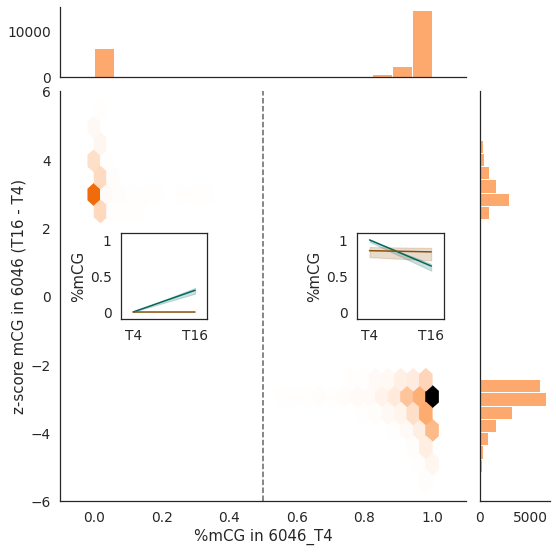

In [214]:
ef_data = combined_mcs['mcs_prop_test'].copy()
ef_data = ef_data.loc[:,['prop_ztest_6046', 'prop_pval_6046','permeth_6191_T4', "permeth_6191_T16", 'permeth_6046_T4', 'permeth_6046_T16']]
ef_data = ef_data[ef_data['prop_pval_6046'] < 0.01]

ci_ints = pd.Series( [0.4, 0.5, 0.6], index = ["40%", "50%", "60%"] )


p1 = sns.jointplot(x = ef_data['permeth_6046_T4'],y = ef_data['prop_ztest_6046'], kind = "hex", marginal_ticks=True, height=8, color= cb.sequential.Oranges_5.hex_colors[2], xlim=(-0.1, 1.1), ylim=(-6, 6) )
# p1.ax_joint.plot( (0, 1), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3] )
p1.ax_joint.plot( (0.5, 0.5), (-6, 6), '--', color = cb.sequential.Greys_5.hex_colors[3] )
p1.ax_joint.set_xlabel( "%mCG in 6046_T4" )
p1.ax_joint.set_ylabel( "z-score mCG in 6046 (T16 - T4)" )
# plt.text(0.1, 0.9, "#mCG: %s" % ef_data.shape[0], transform=p1.ax_joint.transAxes, size = 15 )


left, bottom, width, height = [0.63, 0.42, 0.15, 0.15]
ax2 = p1.fig.add_axes([left, bottom, width, height])

ef_data_des = ef_data[ef_data['prop_ztest_6046'] < -1.5].describe(percentiles = ci_ints.values)
ax2.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6046_T4', 'permeth_6046_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6], label = "6046")
ax2.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6046_T4', 'permeth_6046_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6046_T4', 'permeth_6046_T16']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )
ax2.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6191_T4', 'permeth_6191_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0], label = "6191")
ax2.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6191_T4', 'permeth_6191_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6191_T4', 'permeth_6191_T16']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )
ax2.set_xlim((-0.2, 1.2))
ax2.set_ylim((-0.1, 1.1))
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["T4", "T16"])
ax2.set_yticks([0, 0.5, 1])
ax2.set_yticklabels(["0", "0.5", "1"])
ax2.set_ylabel( "%mCG" )


left, bottom, width, height = [0.22, 0.42, 0.15, 0.15]
ax3 = p1.fig.add_axes([left, bottom, width, height])

ef_data_des = ef_data[ef_data['prop_ztest_6046'] > 1.5].describe(percentiles = ci_ints.values)
ax3.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6046_T4', 'permeth_6046_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[6], label = "6046")
ax3.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6046_T4', 'permeth_6046_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6046_T4', 'permeth_6046_T16']].values, color = cb.diverging.BrBG_7.hex_colors[6], alpha = 0.2, interpolate = True )
ax3.plot( (0, 1), ef_data_des.loc[ci_ints.index[1], ['permeth_6191_T4', 'permeth_6191_T16']].values, '-', color = cb.diverging.BrBG_7.hex_colors[0], label = "6191")
ax3.fill_between( [0, 1], ef_data_des.loc[ci_ints.index[0], ['permeth_6191_T4', 'permeth_6191_T16']].values, ef_data_des.loc[ci_ints.index[2], ['permeth_6191_T4', 'permeth_6191_T16']].values, color = cb.diverging.BrBG_7.hex_colors[0], alpha = 0.2, interpolate = True )
ax3.set_xlim((-0.2, 1.2))
ax3.set_ylim((-0.1, 1.1))
ax3.set_xticks([0, 1])
ax3.set_xticklabels(["T4", "T16"])
ax3.set_yticks([0, 0.5, 1])
ax3.set_yticklabels(["0", "0.5", "1"])
ax3.set_ylabel( "%mCG" )


plt.show()

# Methylation patterns vs Temperature

In [ ]:
req_meths = cross_data.pheno.get_meths_req_gene(req_gene_ix= cross_data.pheno.get_filter_inds( tair10.genes_str ), count_thres=10)
req_meths_parents = cross_data.pheno.group_sample_methylation( cross_data.parent_ids['dir_temp'], filter_pos_ix = cross_data.pheno.get_filter_inds( tair10.genes_str ) )

for ef_context in ["CG", "CHG", "CHH"]:
    req_meths_parents[ef_context].index = tair10.genes_str
    req_meths_parents[ef_context]['DMR_6046'] = req_meths_parents[ef_context]['6046_T16'] - req_meths_parents[ef_context]['6046_T4']
    req_meths_parents[ef_context]['DMR_T16'] = req_meths_parents[ef_context]['6046_T16'] - req_meths_parents[ef_context]['6191_T16']
    req_meths_parents[ef_context]['DMR_T4'] = req_meths_parents[ef_context]['6046_T4'] - req_meths_parents[ef_context]['6191_T4']
    req_meths_parents[ef_context].columns = req_meths_parents[ef_context].columns + "." + ef_context


# cross_data_temp_effects = pd.read_csv( "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/effects_aragenes/noLogit//araport.genes.temp.cis.effects.raw.csv", index_col = 0, header=None )
# cross_data_temp_effects.columns = get_temperature_effects( req_meths, 0).index.values
# cross_data_temp_effects.to_csv( "/groups/nordborg/projects/epiclines/005.manu.crosses.2020/004.design_resolved/effects_aragenes/noLogit/araport.genes.temp.cis.effects.csv" )

cross_data_temp_effects = pd.read_csv( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/effects_aragenes/araport.genes.temp.cis.effects.csv", index_col = 0 )

cross_data_temp_effects_noLogit = pd.read_csv( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/effects_aragenes/noLogit/araport.genes.temp.cis.effects.csv", index_col = 0 )


        
# req_meths['stats_CHG'] = req_meths['CHG'].T.describe().T.set_index(tair10.genes_str)
# req_meths['stats_CHH'] = req_meths['CHH'].T.describe().T.set_index(tair10.genes_str)
# req_meths['stats_CHG'].columns =  pd.Series(['count_', 'mean_', 'std_','min_', '25%_', '50%_','75%_', 'max_']) + "mCHG"
# req_meths['stats_CHH'].columns = pd.Series(['count_', 'mean_', 'std_','min_', '25%_', '50%_','75%_', 'max_']) + "mCHH"
# req_meths['stats_nonCG'] = req_meths['stats_CHG'].merge( req_meths['stats_CHH'], left_index=True, right_index=True )
# req_meths['stats_nonCG'].loc[(req_meths['stats_nonCG']['75%_mCHG'] < 0.005) & ( req_meths['stats_nonCG']['75%_mCHH'] < 0.005)].to_csv( "cache_data/araport.genes.onlygbM_crosses.csv" )

req_meths['stats_nonCG'] = pd.read_csv( "cache_data/araport.genes.onlygbM_crosses.csv", index_col= 0)
cross_data_temp_effects['gbmOnly'] = cross_data_temp_effects.index.isin( req_meths['stats_nonCG'].index )


cg_gbm_corr_lat = pd.read_csv("cache_data/araport.genes.lat.clines.csv", index_col = 0)
cross_data_temp_effects['clinal_corr'] = cg_gbm_corr_lat['corr']
cross_data_temp_effects['clinal_corr_pval'] = cg_gbm_corr_lat['pval']

cross_data_temp_effects_noLogit['clinal_corr'] = cg_gbm_corr_lat['corr']
cross_data_temp_effects_noLogit['clinal_corr_pval'] = cg_gbm_corr_lat['pval']


cross_data_temp_effects = pd.merge( cross_data_temp_effects, req_meths_parents['CG'], right_index=True, left_index=True)

# gbm_env_effect = pd.read_csv("cache_data/araport.genes.temp.cis.effects.csv", index_col = 0, sep = "\t")
# cross_data_temp_effects = pd.merge(cross_data_temp_effects, gbm_env_effect, left_index=True, right_index=True)

# for ef_c in cross_data_temp_effects.columns:
#     if pd.Series(ef_c).str.startswith( "eff_" )[0]:
#         cross_data_temp_effects[ef_c] = invLogit(0.5 + cross_data_temp_effects[ef_c]) - invLogit(0.5)
#     elif pd.Series(ef_c).str.startswith( "pval_" )[0]:
#         cross_data_temp_effects[ef_c] = -np.log10(cross_data_temp_effects[ef_c])

# gbm_env_effect_parents = pd.read_csv("cache_data/araport.genes.temp.effects.parents.csv", index_col = 0, sep = "\t")
# req_meths_parents['CG'] = pd.merge(req_meths_parents['CG'], gbm_env_effect_parents, left_index=True, right_index=True, how = "left")

cross_data_temp_effects['araport.id'] = tair10.genes.set_index( tair10.genes_str ).loc[ cross_data_temp_effects.index, 3 ].values
cross_data_temp_effects_noLogit['araport.id'] = tair10.genes.set_index( tair10.genes_str ).loc[ cross_data_temp_effects_noLogit.index, 3 ].values

chromatin_gene_cls = pd.read_csv( proj_dir + "/cegs/rahul/011.states.bhagyshree/002.GeneClusters/newSetPCG_all.bed", header = None, sep = "\t")
cross_data_temp_effects['ChromatinSetPCG'] = chromatin_gene_cls.set_index( 3 ).reindex( cross_data_temp_effects['araport.id'] )[6].values

cross_data_temp_effects_noLogit['ChromatinSetPCG'] = chromatin_gene_cls.set_index( 3 ).reindex( cross_data_temp_effects_noLogit['araport.id'] )[6].values


genes_h2az_chip = pd.read_csv( proj_dir + "/cegs//rahul/011.states.bhagyshree/003.CHIP/gene_avgs/Araport11_genes_h2az_chip_RY.bed", header = None, sep = "\t" )
cross_data_temp_effects['h2az.chip'] = genes_h2az_chip.set_index( 3 ).reindex( cross_data_temp_effects['araport.id'] )[7].values
cross_data_temp_effects_noLogit['h2az.chip'] = genes_h2az_chip.set_index( 3 ).reindex( cross_data_temp_effects_noLogit['araport.id'] )[7].values

Make sure provided array is sorted based on chromosome position


In [5]:
# cross_data_temp_effects['eff_temp_diff.trans.CG'] = invLogit(cross_data_temp_effects['meths_mean.CG'] + cross_data_temp_effects['eff_temp_diff.CG']) - invLogit(cross_data_temp_effects['meths_mean.CG'])
# cross_data_temp_effects['eff_temp.AA_diff.CG'] = invLogit(cross_data_temp_effects['meths_AA_T16.mean.CG'] + cross_data_temp_effects['eff_temp.AA_diff.CG']) - invLogit(cross_data_temp_effects['meths_AA_T16.mean.CG'])
# cross_data_temp_effects['eff_temp.BB_diff.CG'] = invLogit(cross_data_temp_effects['meths_BB_T16.mean.CG'] + cross_data_temp_effects['eff_temp.BB_diff.CG']) - invLogit(cross_data_temp_effects['meths_BB_T16.mean.CG'])


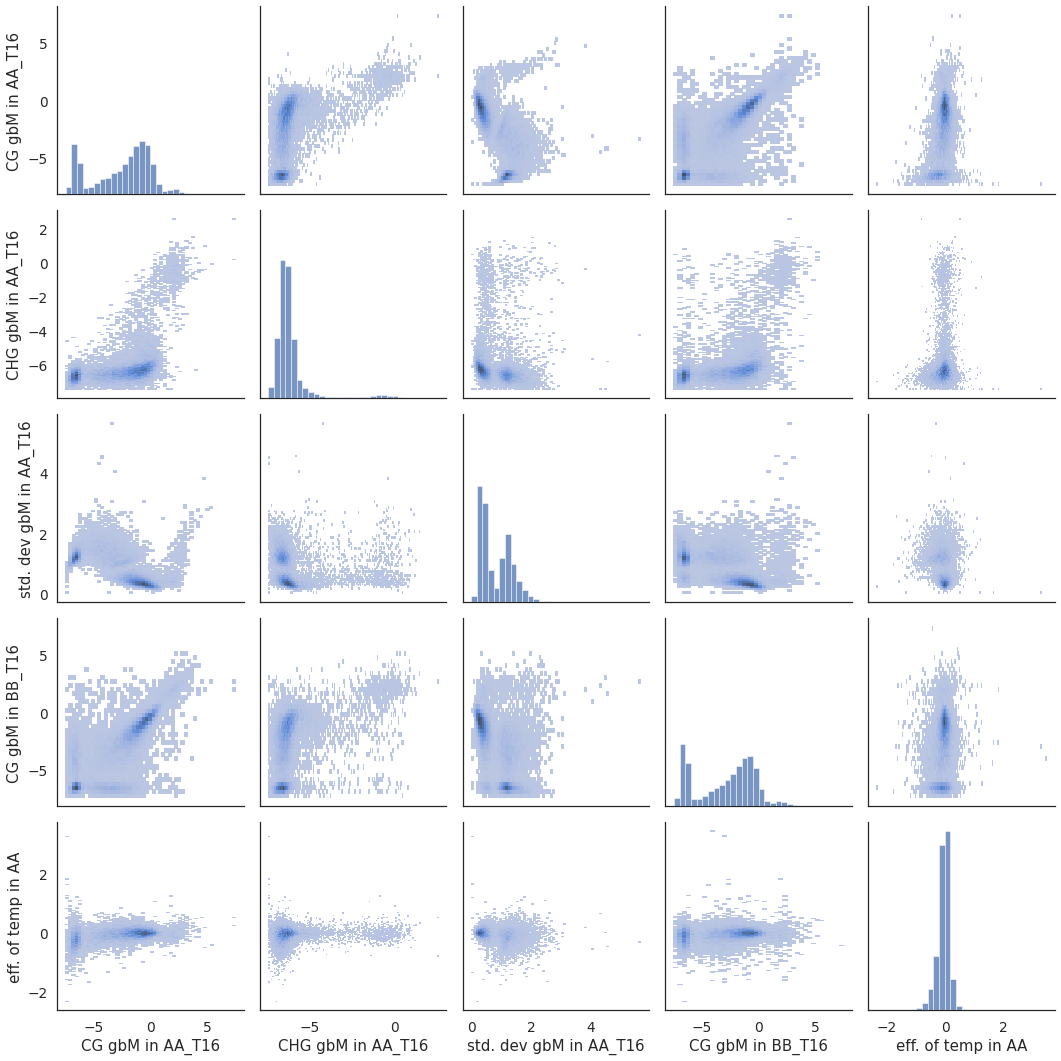

In [117]:
vars_to_plot = ["meths_AA_T16.mean.CG", "meths_AA_T16.mean.CHG", "meths_AA_T16.std.CG", "meths_BB_T16.mean.CG", "eff_temp.AA_diff"]
ef_data = cross_data_temp_effects.loc[:,vars_to_plot]
# ef_data.iloc[:,0] = utils.logit( utils.transform_beta(ef_data.iloc[:,0]) )
ef_data.columns = ["CG gbM in AA_T16", "CHG gbM in AA_T16", "std. dev gbM in AA_T16", "CG gbM in BB_T16", "eff. of temp in AA" ]


sns.pairplot(data = ef_data, kind = "hist", height=3, corner=False, diag_kws=dict(bins=30))

plt.tight_layout()

# plt.savefig("meths.F2s.pdf")
plt.show()

In [173]:
%%time
import sklearn.cluster as skcluster
from sklearn import mixture as skmixture

cross_data_temp_effects['cl_meths_AA'] = pd.NA

# kmeans = KMeans( n_clusters=4, random_state=0 ).fit( cross_data_temp_effects.loc[:,['meths_mean.CG', 'meths_mean.CHG']]  )
# cluster_2 = DBSCAN(eps=0.25, min_samples=10).fit(cross_data_temp_effects.loc[:,['meths_mean.CG', 'meths_mean.CHG']])
# pd.Series(cluster_2.labels_).value_counts()
ef_data = cross_data_temp_effects.loc[:,['meths_AA_T16.mean.CG', 'meths_AA_T16.mean.CHG']].dropna()
cluster_2 = skmixture.GaussianMixture(2, covariance_type = "spherical", random_state=1,means_init=[[-6.7, -6.7], [-3, -6]] ).fit( ef_data )
cross_data_temp_effects.loc[ef_data.index, 'cl_meths_AA'] = cluster_2.predict( ef_data )

ef_data = cross_data_temp_effects.loc[:,['meths_AA_T16.mean.CG', 'meths_AA_T16.mean.CHG', 'cl_meths_AA']].dropna()
ef_data = ef_data[ ef_data['cl_meths_AA'] == 0 ].iloc[:,[0,1]]
cluster_2 = skmixture.GaussianMixture(2, covariance_type = "spherical", random_state = 1, means_init=[[-1, -6.7], [-1, -4]]).fit( ef_data )
cross_data_temp_effects.loc[ef_data.index, 'cl_meths_AA'] = cluster_2.predict( ef_data ) + 2



# ef_data = cross_data_temp_effects.loc[:,['meths_BB_T16.mean.CG', 'meths_BB_T16.mean.CHG']].dropna()
# cluster_2 = skmixture.GaussianMixture(4, covariance_type = "spherical").fit( ef_data )
# cross_data_temp_effects['cl_meths_BB'] = pd.Series(cluster_2.predict( ef_data ), index = ef_data.index)

CPU times: user 4.79 s, sys: 3.92 s, total: 8.71 s
Wall time: 380 ms


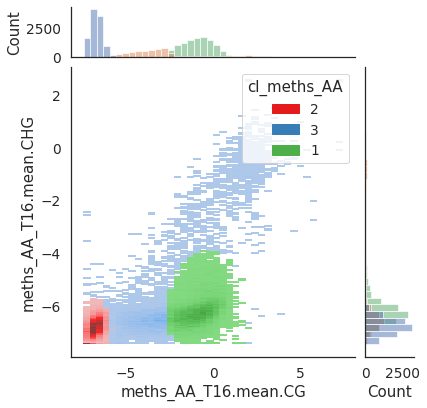

In [174]:
sns.jointplot(data = cross_data_temp_effects, x = 'meths_AA_T16.mean.CG', y = 'meths_AA_T16.mean.CHG', hue = 'cl_meths_AA', kind = "hist", palette = "Set1", marginal_ticks=True, marginal_kws={'bins': 40})
plt.show()

ChromatinSetPCG
nSetPCG_1   -0.007883
nSetPCG_2   -0.017863
nSetPCG_3   -0.014553
nSetPCG_4   -0.011361
nSetPCG_5    0.008706
nSetPCG_6    0.012020
nSetPCG_7    0.012688
nSetPCG_8   -0.083648
Name: eff_temp_diff.CG, dtype: float64


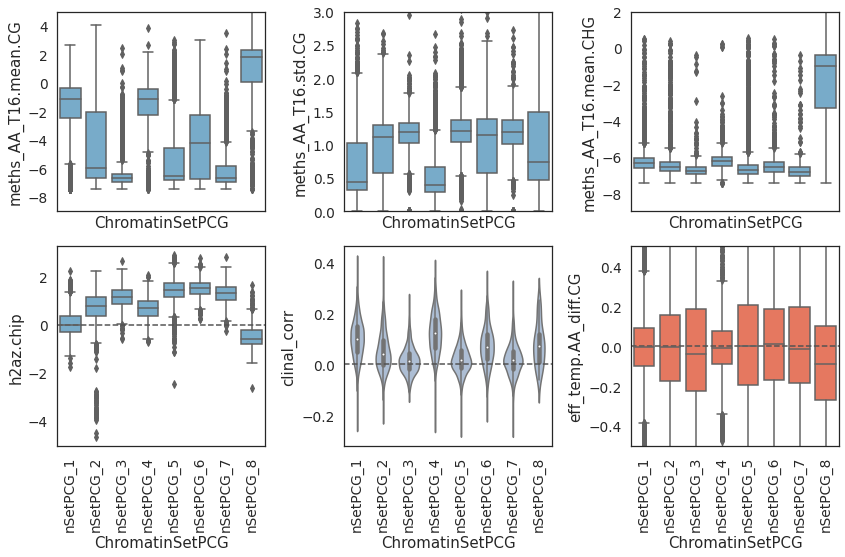

In [167]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True)

p1 = sns.boxplot( data = cross_data_temp_effects.sort_values("ChromatinSetPCG"), x = "ChromatinSetPCG", y = 'meths_AA_T16.mean.CG', color = cb.sequential.Blues_5.hex_colors[2], ax=axes[0,0] )
p1.set_ylim([-9, 5])


p2 = sns.boxplot( data = cross_data_temp_effects.sort_values("ChromatinSetPCG"), x = "ChromatinSetPCG", y = 'meths_AA_T16.std.CG', color = cb.sequential.Blues_5.hex_colors[2],ax=axes[0,1] )
p2.set_ylim([0,3])


p3 = sns.boxplot( data = cross_data_temp_effects.sort_values("ChromatinSetPCG"), x = "ChromatinSetPCG", y = 'meths_AA_T16.mean.CHG', color = cb.sequential.Blues_5.hex_colors[2], ax=axes[0,2] )
p3.set_ylim([-9, 2])


p4 = sns.boxplot( data = cross_data_temp_effects.sort_values("ChromatinSetPCG"), x = "ChromatinSetPCG", y = 'h2az.chip', color = cb.sequential.Blues_5.hex_colors[2], ax = axes[1, 0] )
p4.plot((-0.5, 7.5), (0, 0), '--', color = "#525252" )
plt.setp(p4.axes.get_xticklabels(), ha="center", rotation=90)


p5 = sns.violinplot(data = cross_data_temp_effects.sort_values('ChromatinSetPCG'), x = "ChromatinSetPCG", y = 'clinal_corr', color = cb.sequential.PuBu_6.hex_colors[2], ax = axes[1,1])
p5.plot((-0.5, 7.5), (0, 0), '--', color = "#525252" )
plt.setp(p5.axes.get_xticklabels(), ha="center", rotation=90)


p6 = sns.boxplot(data = cross_data_temp_effects.sort_values('ChromatinSetPCG'), x = 'ChromatinSetPCG', y = 'eff_temp.AA_diff.CG', color = cb.sequential.Reds_5.hex_colors[2])
p6.plot((-0.5, 7.5), (0, 0), '--', color = "#525252" )
plt.setp(p6.axes.get_xticklabels(), ha="center", rotation=90)
p6.set_ylim((-0.5, 0.5))


print(cross_data_temp_effects.groupby("ChromatinSetPCG").mean()['eff_temp_diff.CG'])


plt.tight_layout()
plt.show()

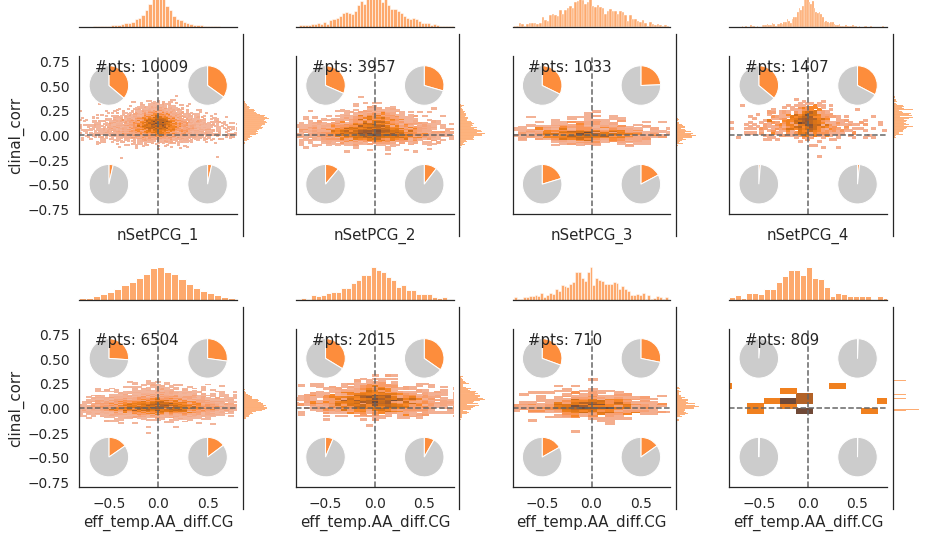

In [175]:
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(2, 4)

axes = {}
for ef in range(8):
    ef_data = cross_data_temp_effects.loc[cross_data_temp_effects['ChromatinSetPCG'] == "nSetPCG_" + str(ef + 1)]
    p = plotting.quadrant_plot( ef_data['eff_temp.AA_diff.CG'], ef_data['clinal_corr'], plt_limits={"xlim": 0.8, "ylim": 0.8, 'xpie': 0.5, 'ypie': 0.5, 'pie_rad': 0.2}, plt_options= {'color': cb.sequential.Oranges_5.hex_colors[2]}, kind = "hist")
    if ef in [0, 1, 2, 3]:
        p.ax_joint.set_xlabel("nSetPCG_" + str(ef + 1))
        p.ax_joint.set_xticklabels([""])
    if ef in [1, 2, 3, 5, 6, 7]:
        p.ax_joint.set_ylabel("")
        p.ax_joint.set_yticklabels([""])
    axes[ef] = plotting.SeabornFig2Grid(p, fig, gs[ef])

gs.tight_layout(fig)

#gs.update(top=0.7)

plt.show()

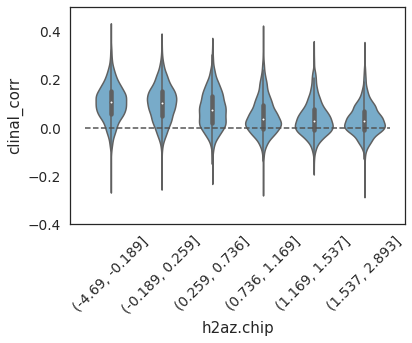

In [169]:
p = sns.violinplot( x = pd.qcut( cross_data_temp_effects['h2az.chip'], 6 ), y = cross_data_temp_effects['clinal_corr'], color = cb.sequential.Blues_5.hex_colors[2])

p.plot((-0.5, 5.5), (0, 0), '--', color = "#525252" )

plt.setp(p.axes.get_xticklabels(), ha="center", rotation=45)

plt.ylim((-0.4, 0.5))

plt.show()

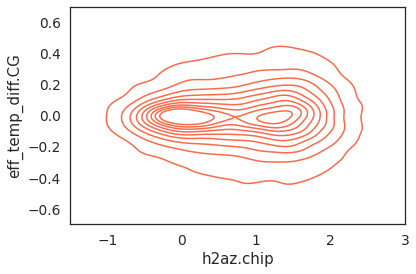

In [199]:
sns.kdeplot(data = cross_data_temp_effects.dropna(), x = 'h2az.chip', y = 'eff_temp_diff.CG', color=cb.sequential.Reds_5.hex_colors[2])
plt.ylim((-0.7, 0.7))
plt.xlim((-1.5, 3))

plt.show()

In [37]:
cross_data_temp_effects_noLogit.columns

Index(['counts_AA_T16', 'counts_BB_T16', 'meths_mean.CG', 'meths_std.CG',
       'ss_temp.CG', 'ss_cis.CG', 'ss_residual.CG', 'pval_temp.CG',
       'pval_cis.CG', 'eff_temp_diff.CG', 'eff_temp_lwr.CG', 'eff_temp_upr.CG',
       'eff_AA.BB_diff.CG', 'eff_AA.BB_lwr.CG', 'eff_AA.BB_upr.CG',
       'meths_AA_T16.mean.CG', 'meths_AA_T16.std.CG', 'eff_temp.AA_diff.CG',
       'eff_temp.AA_lwr.CG', 'eff_temp.AA_upr.CG', 'meths_BB_T16.mean.CG',
       'meths_BB_T16.std.CG', 'eff_temp.BB_diff.CG', 'eff_temp.BB_lwr.CG',
       'eff_temp.BB_upr.CG', 'meths_mean.CHG', 'meths_std.CHG', 'ss_temp.CHG',
       'ss_cis.CHG', 'ss_residual.CHG', 'pval_temp.CHG', 'pval_cis.CHG',
       'eff_temp_diff.CHG', 'eff_temp_lwr.CHG', 'eff_temp_upr.CHG',
       'eff_AA.BB_diff.CHG', 'eff_AA.BB_lwr.CHG', 'eff_AA.BB_upr.CHG',
       'meths_AA_T16.mean.CHG', 'meths_AA_T16.std.CHG', 'eff_temp.AA_diff.CHG',
       'eff_temp.AA_lwr.CHG', 'eff_temp.AA_upr.CHG', 'meths_BB_T16.mean.CHG',
       'meths_BB_T16.std.CHG', 'ef

(26444, 5)
(11501, 5)
(10610, 5)


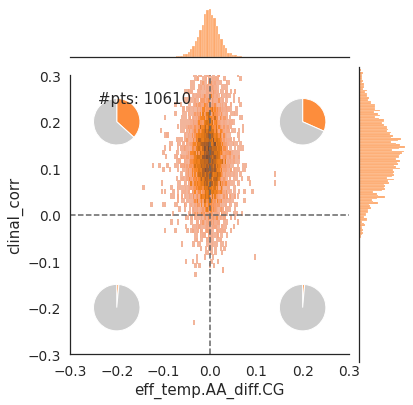

In [65]:
ef_data = cross_data_temp_effects_noLogit.loc[:,['eff_temp.AA_diff.CG', 'clinal_corr', 'meths_AA_T16.mean.CG', 'meths_AA_T16.mean.CHG', 'meths_AA_T16.std.CG' ]].copy()
print(ef_data.shape)
ef_data = ef_data[ef_data['meths_AA_T16.mean.CG'] > 0.1]
print(ef_data.shape)
ef_data = ef_data[ef_data['meths_AA_T16.mean.CHG'] < 0.05]
print(ef_data.shape)
# ef_data = ef_data[ef_data['meths_AA_T16.std.CG'] > 0.02]
# print(ef_data.shape)

plotting.quadrant_plot( ef_data['eff_temp.AA_diff.CG'], ef_data['clinal_corr'], plt_limits={"xlim": 0.3, "ylim": 0.3, 'xpie': 0.2, 'ypie': 0.2, 'pie_rad': 0.05}, plt_options= {'color': cb.sequential.Oranges_5.hex_colors[2]}, kind = "hist")

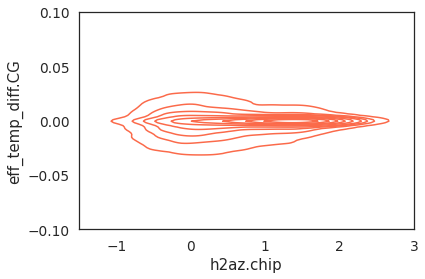

In [30]:
sns.kdeplot(data = cross_data_temp_effects_noLogit.dropna(), x = 'h2az.chip', y = 'eff_temp_diff.CG', color=cb.sequential.Reds_5.hex_colors[2])
plt.ylim((-0.1, 0.1))
plt.xlim((-1.5, 3))

plt.show()

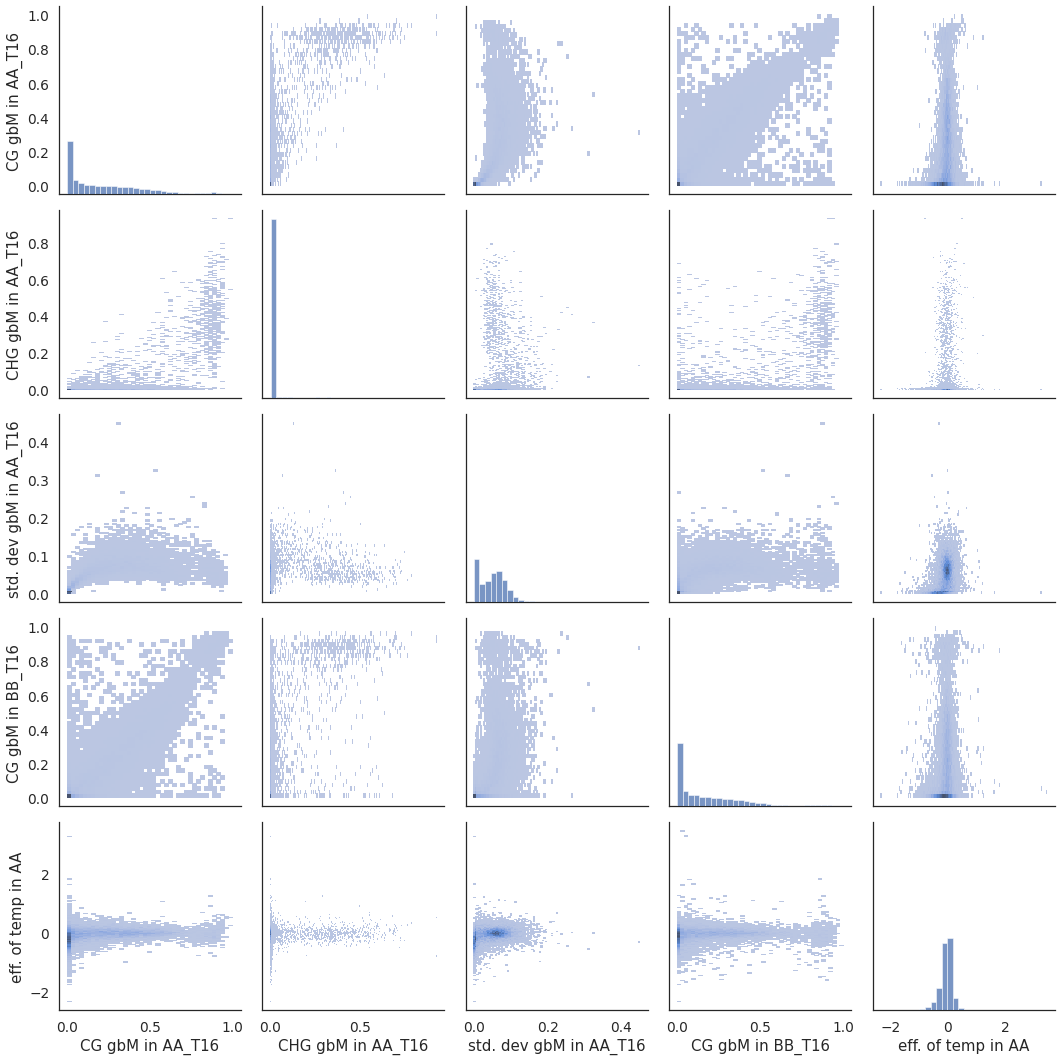

In [63]:
vars_to_plot = ["meths_AA_T16.mean.CG", "meths_AA_T16.mean.CHG", "meths_AA_T16.std.CG", "meths_BB_T16.mean.CG", "eff_temp.AA_diff"]
ef_data = cross_data_temp_effects_noLogit.loc[:,vars_to_plot]
# ef_data.iloc[:,0] = utils.logit( utils.transform_beta(ef_data.iloc[:,0]) )
ef_data.columns = ["CG gbM in AA_T16", "CHG gbM in AA_T16", "std. dev gbM in AA_T16", "CG gbM in BB_T16", "eff. of temp in AA" ]


sns.pairplot(data = ef_data, kind = "hist", height=3, corner=False, diag_kws=dict(bins=30))

plt.tight_layout()

# plt.savefig("meths.F2s.pdf")
plt.show()

In [ ]:
low_to_no_meth_thres = -5.5
# low_to_no_meth_thres = 0.01

sns.histplot(cross_data_temp_effects['meths_AA_T16.mean.CG'] )
plt.plot((low_to_no_meth_thres, low_to_no_meth_thres), (0, 3000), 'r-')
plt.show()

cross_data_temp_effects['note_AA'] = "NA"
cross_data_temp_effects['note_BB'] = "NA"
for ef_gene in cross_data_temp_effects.iterrows():
    if (ef_gene[1]["meths_AA_T16.mean.CG"] < low_to_no_meth_thres) & (ef_gene[1]["meths_BB_T16.mean.CG"] > low_to_no_meth_thres):
        cross_data_temp_effects.loc[ef_gene[0], "info"] = "only_BB"
    elif (ef_gene[1]["meths_AA_T16.mean.CG"] > low_to_no_meth_thres) & (ef_gene[1]["meths_BB_T16.mean.CG"] < low_to_no_meth_thres):
        cross_data_temp_effects.loc[ef_gene[0], "info"] = "only_AA"
    elif (ef_gene[1]["meths_AA_T16.mean.CG"] < low_to_no_meth_thres) & (ef_gene[1]["meths_BB_T16.mean.CG"] < low_to_no_meth_thres):
        cross_data_temp_effects.loc[ef_gene[0], "info"] = "noGBM"
    elif ef_gene[1]["meths_AA_T16.mean.CG"] > ef_gene[1]["meths_BB_T16.mean.CG"]:
        cross_data_temp_effects.loc[ef_gene[0], "info"] = "high_AA"
    elif ef_gene[1]["meths_AA_T16.mean.CG"] < ef_gene[1]["meths_BB_T16.mean.CG"]:
        cross_data_temp_effects.loc[ef_gene[0], "info"] = "high_BB"
        
print(cross_data_temp_effects['info'].value_counts())

In [6]:
from sklearn.linear_model import LinearRegression

(277, 7)


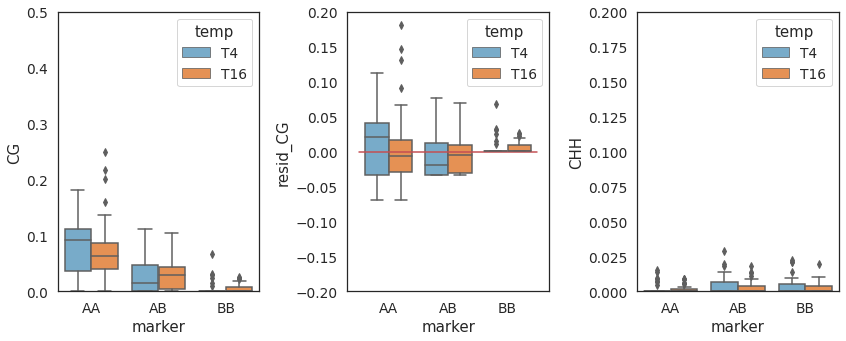

In [8]:
ef_data = get_temperature_effects( req_meths, 15389, return_pheno=True, logit=False )
ef_data = ef_data.sort_values(['marker', 'temp'])
ef_data['resid_CG'] = ef_data['CG'] - LinearRegression( ).fit(pyqtlparser.marker_to_int( ef_data['marker'] , ['AA', 'AB', 'BB'] ).values.reshape(-1, 1), ef_data['CG'].values ).predict( pyqtlparser.marker_to_int( ef_data['marker'] , ['AA', 'AB', 'BB'] ).values.reshape(-1, 1) )
# pyqtlparser.marker_to_int( ef_data[['marker', 'temp']], ['AA', 'AB', 'BB', 'T16', 'T4'] )



# print( get_temperature_effects( req_meths, 15389, logit=False ).loc[["eff_temp.AA_diff.CG", "eff_temp.BB_diff.CG"]] )

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
plt_lims = [[0, 0.5], [0, 0.2], [0, 0.2]]
# plt_lims = [[-9, 3], [-9, -2], [-9, 2]]

print(ef_data.shape)
p1 = sns.boxplot( data = ef_data, x = "marker", y = "CG", hue = "temp", ax=axes[0], palette=temp_color, hue_order = ['T4', 'T16'])
p1.set_ylim(plt_lims[0])
p2 = sns.boxplot( data = ef_data, x = "marker", y = "resid_CG", hue = "temp", ax=axes[1], palette=temp_color, hue_order = ['T4', 'T16'])
axes[1].plot((-0.5, 2.5), (0, 0), 'r-')
p2.set_ylim( [-0.2, 0.2] )
p3 = sns.boxplot( data = ef_data, x = "marker", y = "CHH", hue = "temp", ax=axes[2], palette=temp_color, hue_order = ['T4', 'T16'])
p3.set_ylim(plt_lims[2])

plt.tight_layout()
plt.show()

eff_temp.AA_diff.CG   -0.0041
eff_temp.BB_diff.CG    0.0008
dtype: float64
(276, 6)


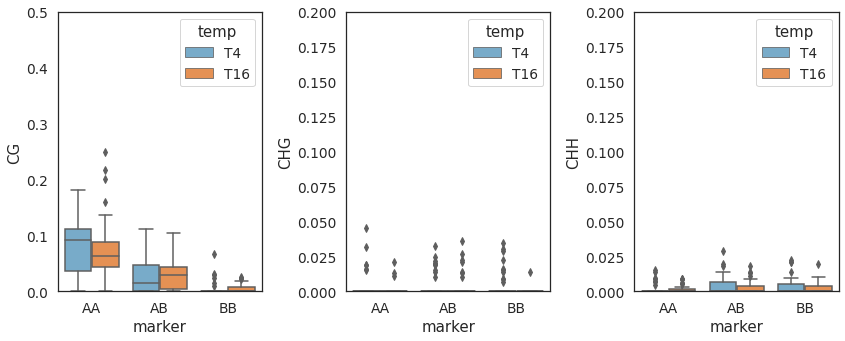

In [9]:
ef_data = get_temperature_effects( req_meths, 15389, return_pheno=True, logit=False )
ef_data = ef_data.sort_values(['marker', 'temp'])

print( get_temperature_effects( req_meths, 15389, logit=False ).loc[["eff_temp.AA_diff.CG", "eff_temp.BB_diff.CG"]] )

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
plt_lims = [[0, 0.5], [0, 0.2], [0, 0.2]]
# plt_lims = [[-9, 3], [-9, -2], [-9, 2]]

print(ef_data.shape)
p1 = sns.boxplot( data = ef_data, x = "marker", y = "CG", hue = "temp", ax=axes[0], palette=temp_color, hue_order = ['T4', 'T16'])
p1.set_ylim(plt_lims[0])
p2 = sns.boxplot( data = ef_data, x = "marker", y = "CHG", hue = "temp", ax=axes[1], palette=temp_color, hue_order = ['T4', 'T16'])
p2.set_ylim(plt_lims[1])
p3 = sns.boxplot( data = ef_data, x = "marker", y = "CHH", hue = "temp", ax=axes[2], palette=temp_color, hue_order = ['T4', 'T16'])
p3.set_ylim(plt_lims[2])

plt.tight_layout()
plt.show()

eff_temp.AA_diff.CG   -0.0557
eff_temp.BB_diff.CG    0.5292
dtype: float64
(276, 6)


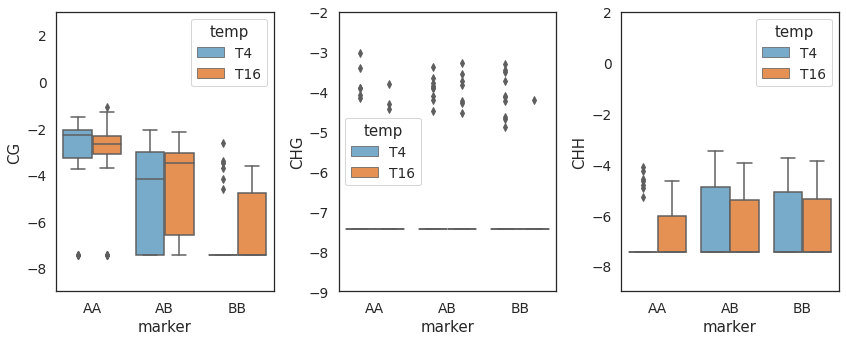

In [11]:
ef_data = get_temperature_effects( req_meths, 15389, return_pheno=True, logit=True )
ef_data = ef_data.sort_values(['marker', 'temp'])

print( get_temperature_effects( req_meths, 15389, logit=True ).loc[["eff_temp.AA_diff.CG", "eff_temp.BB_diff.CG"]] )

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
# plt_lims = [[0, 0.5], [0, 0.2], [0, 0.2]]
plt_lims = [[-9, 3], [-9, -2], [-9, 2]]

print(ef_data.shape)
p1 = sns.boxplot( data = ef_data, x = "marker", y = "CG", hue = "temp", ax=axes[0], palette=temp_color, hue_order = ['T4', 'T16'])
p1.set_ylim(plt_lims[0])
p2 = sns.boxplot( data = ef_data, x = "marker", y = "CHG", hue = "temp", ax=axes[1], palette=temp_color, hue_order = ['T4', 'T16'])
p2.set_ylim(plt_lims[1])
p3 = sns.boxplot( data = ef_data, x = "marker", y = "CHH", hue = "temp", ax=axes[2], palette=temp_color, hue_order = ['T4', 'T16'])
p3.set_ylim(plt_lims[2])

plt.tight_layout()
plt.show()

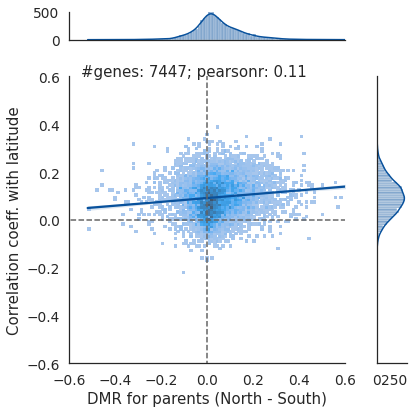

In [9]:
# loc[(genes_env_effects['pval'] < 0.01) & (genes_env_effects['pval_temp'] < 0.01)]
ef_data = req_meths_parents['CG'].loc[:,["DMR_T16", "corr"]].dropna()

p = sns.jointplot( x = ef_data.iloc[:,0] , y = ef_data.iloc[:,1], kind = "reg", marginal_ticks=True, color = cb.sequential.Blues_6.hex_colors[5], marker = "") 
p.plot_joint(sns.histplot, color=cb.sequential.Blues_6.hex_colors[4])
p.ax_joint.plot((0,0), (-1, 1), '--', color = cb.sequential.Greys_6.hex_colors[4])
p.ax_joint.plot((-1,1), (0, 0), '--', color = cb.sequential.Greys_6.hex_colors[4])


t_anno = "#genes: %s; pearsonr: %.2f" % (len(p.x), sp.stats.pearsonr(p.x, p.y)[0] )
p.ax_joint.set_ylim((-0.6, 0.6)) 
p.ax_joint.set_xlim((-0.6, 0.6)) 
p.ax_joint.text(-0.55, 0.6, t_anno, size = 15 )

p.ax_marg_x.set_ylim((0, 500))
p.ax_joint.set_ylabel( "Correlation coeff. with latitude" )
p.ax_joint.set_xlabel( "DMR for parents (North - South)" )
plt.tight_layout()

# plt.savefig( "cline_corr_with_eff_temp.png" )

plt.show()

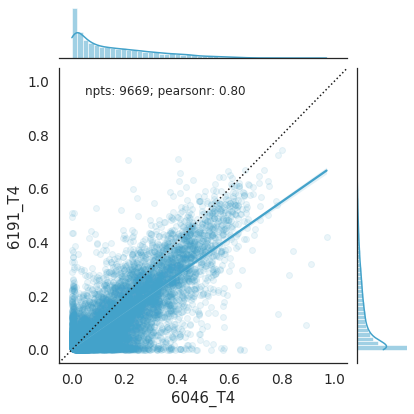

In [86]:
# methylation of parents at two different temperatures
ef_data = req_meths_parents['CG'].loc[:,["6046_T4", "6191_T4"]]

p = plotting.meths_jointplot(x= ef_data.dropna()["6046_T4"], y = ef_data.dropna()["6191_T4"], reqcond = {"annotate": True}, kde = False, hexplt = False, min_sum = 0.01)

plt.show()

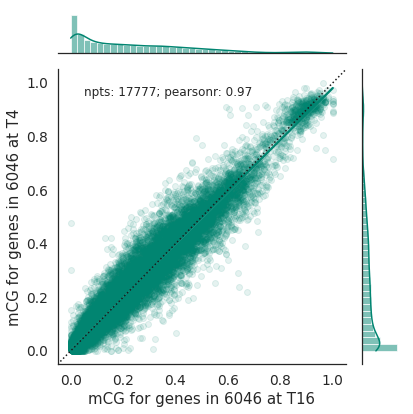

In [12]:
# methylation of parents at two different temperatures
ef_data = req_meths_parents['CG'].loc[:,["6046_T16", "6046_T4"]]

p = plotting.meths_jointplot(x= ef_data.dropna()["6046_T16"], y = ef_data.dropna()["6046_T4"], reqcond = {"annotate": True, 'color': cb.diverging.BrBG_5.hex_colors[4] }, kde = False, hexplt = False, min_sum = 0.01)


p.ax_joint.set_xlabel("mCG for genes in 6046 at T16")
p.ax_joint.set_ylabel("mCG for genes in 6046 at T4")

plt.tight_layout()

plt.savefig( "parent6046_gbm.png" )

plt.show()

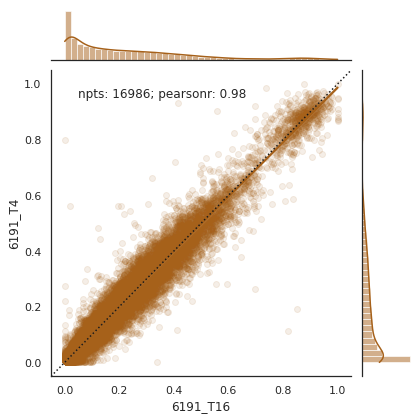

In [11]:
# methylation of parents at two different temperatures
ef_data = req_meths_parents['CG'].loc[:,["6191_T16", "6191_T4"]]

p = plotting.meths_jointplot(x= ef_data.dropna()["6191_T16"], y = ef_data.dropna()["6191_T4"], reqcond = {"annotate": True, 'color': cb.diverging.BrBG_5.hex_colors[0] }, kde = False, hexplt = False, min_sum = 0.01)

plt.show()

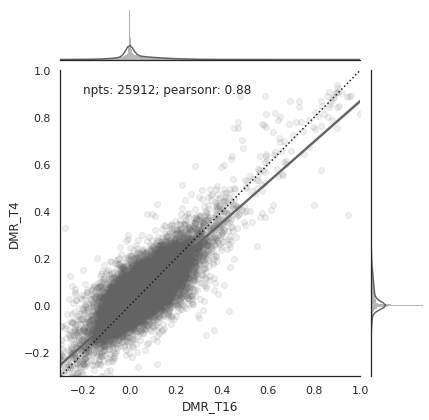

In [8]:
# methylation of parents at two different temperatures
ef_data = req_meths_parents['CG'].loc[:,["DMR_T16", "DMR_T4"]].dropna()

p = plotting.meths_jointplot(x= ef_data.iloc[:,0], y = ef_data.iloc[:,1], reqcond = {"plt_limits": (-0.3, 1), "annotate": True, 'color': cb.sequential.Greys_6.hex_colors[4] }, kde = False, hexplt = False)

plt.show()

In [104]:
req_meths_parents['CG']['eff_temp_diff'].describe()

count    11591.000000
mean        -0.019589
std          0.031856
min         -0.234305
25%         -0.038618
50%         -0.014731
75%          0.002813
max          0.137736
Name: eff_temp_diff, dtype: float64

In [108]:
(req_meths_parents['CG']['pval_temp'] < 0.01).sum()

411

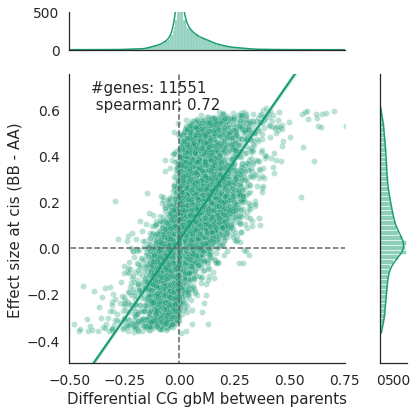

In [103]:
ef_data = req_meths_parents['CG'].loc[:,["DMR_T16", "eff_BB.AA_diff", "pval_cis_geno"]]
with pd.option_context('mode.use_inf_as_null', True):
   ef_data = ef_data.dropna()
ef_data.iloc[:,1] =  -ef_data.iloc[:,1]
ef_data['pval_cis_geno'][ef_data['pval_cis_geno'] > 30] = 30


p = sns.jointplot( y = ef_data.iloc[:,1], x = ef_data.iloc[:,0], marginal_ticks=True, color = cb.qualitative.Dark2_4.hex_colors[0], kind = "reg", marker = "") 
# sns.scatterplot(y = ef_data.iloc[:,1], x = ef_data.iloc[:,0], c =  plotting.np_scale_colors( minval = 0, maxval = 30, val = ef_data['pval_cis_geno'].values ), ax = p.ax_joint ) 
p.plot_joint(sns.scatterplot, color=cb.qualitative.Dark2_4.hex_colors[0], alpha = 0.3)

# p = sns.jointplot( y = ef_data.iloc[:,1], x = ef_data.iloc[:,0], marginal_ticks=True, color = cb.sequential.Blues_6.hex_colors[5], marker = "", kind = "reg") 
# p.plot_joint(sns.histplot, color=cb.sequential.Blues_6.hex_colors[4])
p.ax_joint.plot((0,0), (-10, 10), '--', color = cb.sequential.Greys_6.hex_colors[4])
p.ax_joint.plot((-10,10), (0, 0), '--', color = cb.sequential.Greys_6.hex_colors[4])

t_anno = "#genes: %s\n spearmanr: %.2f" % (len(p.x), sp.stats.spearmanr(p.x, p.y)[0] )
p.ax_joint.text(-0.4, 0.6, t_anno, size = 15 )


p.ax_joint.set_xlim((-0.5, 0.75)) 
p.ax_joint.set_ylim((-0.5, 0.75)) 

p.ax_marg_x.set_ylim((0, 500))

p.ax_joint.set_xlabel( "Differential CG gbM between parents" )
p.ax_joint.set_ylabel( "Effect size at cis (BB - AA)" )
plt.tight_layout()


plt.show()

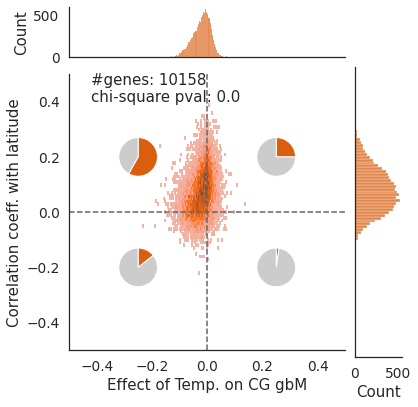

In [122]:
# loc[(genes_env_effects['pval'] < 0.01) & (genes_env_effects['pval_temp'] < 0.01)]
def plot_pie(x, ax, r=0.07, colors=['#3182bd', '#bdbdbd']): 
    # radius for pieplot size on a scatterplot
    ax.pie([x['prop'], 1 - x['prop']], center=(x['x'],x['y']), radius=r, colors=colors, startangle = 90, counterclock = False, frame = True)


xlim_to_joint = 0.5
ylim_to_joint = 0.5
xpos_to_pie = 0.25
ypos_to_pie = 0.2

ef_data = req_meths_parents['CG'].loc[:,["eff_temp_diff", "corr"]].dropna()

p = sns.jointplot( y = ef_data.iloc[:,1], x = ef_data.iloc[:,0], marginal_ticks=True, xlim = [-xlim_to_joint, xlim_to_joint], ylim = [-ylim_to_joint, ylim_to_joint], color = cb.sequential.YlOrBr_6.hex_colors[4], kind = "hist")
p.ax_joint.plot((0,0), (-ylim_to_joint, ylim_to_joint), '--', color = cb.sequential.Greys_5.hex_colors[3])
p.ax_joint.plot((-xlim_to_joint,xlim_to_joint), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3])


t_effects = pd.Series(classify_array(ef_data.iloc[:,0])) + "_" + pd.Series(classify_array(ef_data.iloc[:,1]))
t_effects = t_effects.value_counts()


plot_pie( {"prop": t_effects['neg_pos']/float(ef_data.shape[0]), 'x': -xpos_to_pie, 'y': ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_pos']/float(ef_data.shape[0]), 'x': xpos_to_pie, 'y': ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['neg_neg']/float(ef_data.shape[0]), 'x': -xpos_to_pie, 'y': -ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_neg']/float(ef_data.shape[0]), 'x': xpos_to_pie, 'y': -ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )

t_anno = "#genes: %s\nchi-square pval: %s" % (ef_data.shape[0], sp.stats.chisquare(t_effects.values, ef_data.shape[0] * np.repeat(0.25, 4))[1]) # ; pearsonr: %.2f, sp.stats.pearsonr(p.x, p.y)[0] )
p.ax_joint.text(-xlim_to_joint + 0.08, ylim_to_joint-0.1, t_anno, size = 15 )

p.ax_joint.set_ylabel( "Correlation coeff. with latitude" )
p.ax_joint.set_xlabel( "Effect of Temp. on CG gbM" )

# plt.savefig( "cline_corr_with_eff_temp.png" )

plt.show()

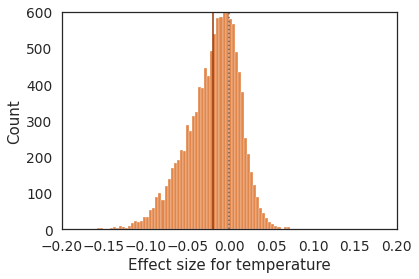

In [169]:
p = sns.histplot( req_meths_parents['CG'], x = "eff_temp_diff", color = cb.sequential.YlOrBr_6.hex_colors[4])

plt.plot( ( req_meths_parents['CG']["eff_temp_diff"].describe()['mean'],  req_meths_parents['CG']["eff_temp_diff"].describe()['mean']), (0, 10000), '-', color = cb.sequential.YlOrBr_6.hex_colors[5] )
plt.plot((0,0), (0, 10000), ':', color = cb.sequential.Greys_6.hex_colors[4])
plt.ylim((0, 600))
plt.xlim((-0.2, 0.2))

plt.xlabel( "Effect size for temperature" )

plt.show()

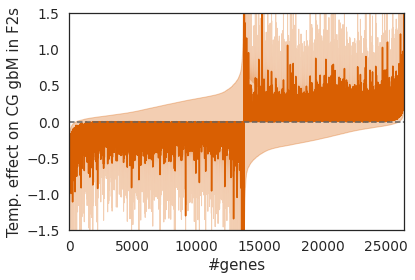

In [39]:
def sort_df(df, columns_to_sort):
    if len(columns_to_sort) == 1:
        return( df.sort_values( columns_to_sort ) )
    df_sorted_index = df.loc[:,columns_to_sort].sum(axis = 1).argsort().sort_values()
    return( df.loc[df_sorted_index.index,:] )

ef_str = "eff_temp_"

ef_data = sort_df(cross_data_temp_effects.loc[cross_data_temp_effects[ef_str + 'diff.CG'] < 0], [ef_str + 'upr.CG']).loc[:,[ef_str + "lwr.CG", ef_str + "diff.CG", ef_str + "upr.CG"]].dropna()
ef_data = ef_data.append( sort_df(cross_data_temp_effects.loc[cross_data_temp_effects[ef_str + 'diff.CG'] > 0], [ef_str + "lwr.CG"] ).loc[:,[ef_str + "lwr.CG", ef_str + "diff.CG", ef_str + "upr.CG"]].dropna() )

p = sns.scatterplot( x = np.arange(ef_data.shape[0]), y = 1, marker = "" )
p.axes.fill_between( np.arange(ef_data.shape[0]), ef_data.iloc[:,0].values, ef_data.iloc[:,2].values, interpolate=False, color = cb.qualitative.Dark2_5.hex_colors[1], alpha = 0.3 )
p.plot( np.arange(ef_data.shape[0]), ef_data.iloc[:,1].values, '-', color = cb.qualitative.Dark2_5.hex_colors[1])

p.set_ylim( (-1.5, 1.5) )
p.set_xlim( (0, ef_data.shape[0]) )
plt.plot((0, ef_data.shape[0]), (0, 0), '--', c = cb.sequential.Greys_5.hex_colors[3])

plt.xlabel("#genes")
plt.ylabel("Temp. effect on CG gbM in F2s")

plt.show()

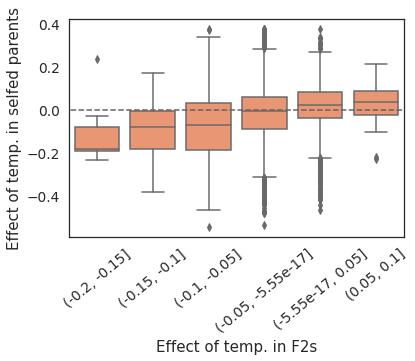

In [74]:
ef_data = req_meths_parents['CG'].loc[ :, ['eff_temp_diff', 'eff_temp.6046.diff'] ]
sns.boxplot( x = pd.cut(ef_data.iloc[:,0], bins=np.arange(-0.2, 0.15, step = 0.05)), y = ef_data.iloc[:,1], color = cb.qualitative.Set2_5.hex_colors[1] )
plt.plot( (-10, 10), (0, 0), '--', c = cb.sequential.Greys_5.hex_colors[3])
plt.xlim(-0.5, 5.5)

plt.xticks(rotation=40)
plt.xlabel("Effect of temp. in F2s")
plt.ylabel("Effect of temp. in selfed parents")


plt.show()

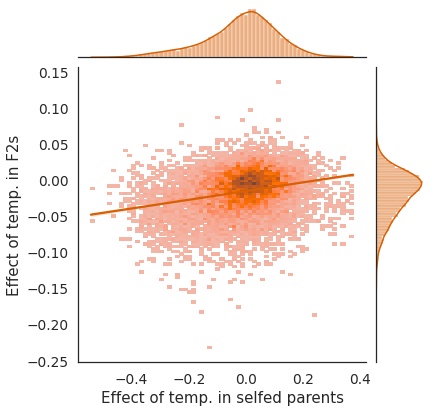

In [76]:
ef_data = req_meths_parents['CG'].loc[ :, ['eff_temp_diff', 'eff_temp.6046.diff'] ]
# sns.boxplot( x = pd.cut(, bins=[-0.5, -0.03, 0, 0.001, 0.5]), y = ef_data.iloc[:,1], color = cb.sequential.Blues_5.hex_colors[2] )
xlim_to_joint = 0.5
ylim_to_joint = 0.4

p = sns.jointplot( y = ef_data.iloc[:,0], x= ef_data.iloc[:,1], kind = "reg", marker = "", color = cb.qualitative.Dark2_5.hex_colors[1])
p.plot_joint(sns.histplot, color= cb.qualitative.Dark2_5.hex_colors[1])
# p.ax_joint.plot((0,0), (-ylim_to_joint, ylim_to_joint), '--', color = cb.sequential.Greys_5.hex_colors[3])
# p.ax_joint.plot((-xlim_to_joint,xlim_to_joint), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3])


p.ax_joint.set_ylabel("Effect of temp. in F2s")
p.ax_joint.set_xlabel("Effect of temp. in selfed parents")

plt.show()

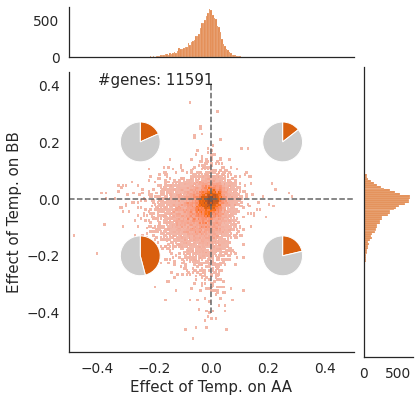

In [124]:
xlim_to_joint = 0.5
ylim_to_joint = 0.4
xpos_to_pie = 0.25
ypos_to_pie = 0.2


p = sns.jointplot( y = "eff_temp.BB_diff", x = "eff_temp.AA_diff", data = req_meths_parents['CG'], marginal_ticks=True, xlim = [-xlim_to_joint, xlim_to_joint], marker = "", color = cb.sequential.YlOrBr_6.hex_colors[4])
# p.plot(sns.histplot, sns.histplot )
p.ax_joint.plot((0,0), (-ylim_to_joint, ylim_to_joint), '--', color = cb.sequential.Greys_5.hex_colors[3])
p.ax_joint.plot((-xlim_to_joint,xlim_to_joint), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3])
p.plot_joint(sns.histplot, color= cb.sequential.YlOrBr_6.hex_colors[4])


t_effects = pd.Series(classify_array(p.x)) + "_" + pd.Series(classify_array(p.y))
t_effects = (t_effects.value_counts() / t_effects.shape[0])


plot_pie( {"prop": t_effects['neg_pos'], 'x': -xpos_to_pie, 'y': ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_pos'], 'x': xpos_to_pie, 'y': ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['neg_neg'], 'x': -xpos_to_pie, 'y': -ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_neg'], 'x': xpos_to_pie, 'y': -ypos_to_pie }, p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )

t_anno = "#genes: %s" % len(p.x) # ; pearsonr: %.2f, sp.stats.pearsonr(p.x, p.y)[0] )
p.ax_joint.text(-xlim_to_joint + 0.1, ylim_to_joint, t_anno, size = 15 )

# _ = p.ax_joint.yaxis.set_ticks(np.arange(-ylim_to_joint, ylim_to_joint + 0.2, step = 0.20))
# _ = p.ax_joint.xaxis.set_ticks(np.arange(-xlim_to_joint, xlim_to_joint + 0.1, step = 0.10))
# p.ax_joint.set_xlim( (-xlim_to_joint, xlim_to_joint) )
# p.ax_joint.set_ylim( (-ylim_to_joint, ylim_to_joint) )
# p.ax_joint.set_frame_on(True)

p.ax_joint.set_ylabel( "Effect of Temp. on BB" )
p.ax_joint.set_xlabel( "Effect of Temp. on AA" )
# plt.tight_layout()

# plt.savefig( "cline_corr_with_eff_temp.png" )

plt.show()

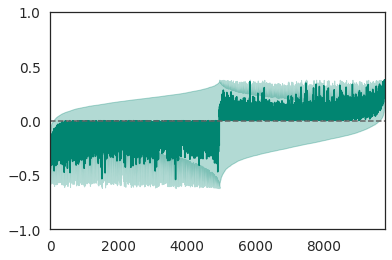

In [18]:
def sort_df(df, columns_to_sort):
    if len(columns_to_sort) == 1:
        return( df.sort_values( columns_to_sort ) )
    df_sorted_index = df.loc[:,columns_to_sort].sum(axis = 1).argsort().sort_values()
    return( df.loc[df_sorted_index.index,:] )

ef_str = "eff_temp.6046."

ef_data = sort_df(req_meths_parents['CG'].loc[req_meths_parents['CG'][ef_str + 'diff'] < 0], [ef_str + 'upr']).loc[:,[ef_str + "lwr", ef_str + "diff", ef_str + "upr"]].dropna()
ef_data = ef_data.append( sort_df(req_meths_parents['CG'].loc[req_meths_parents['CG'][ef_str + 'diff'] > 0], [ef_str + "lwr"] ).loc[:,[ef_str + "lwr", ef_str + "diff", ef_str + "upr"]].dropna() )


p = sns.scatterplot( x = np.arange(ef_data.shape[0]), y = 1, marker = "" )
p.axes.fill_between( np.arange(ef_data.shape[0]), ef_data.iloc[:,0].values, ef_data.iloc[:,2].values, interpolate=False, color = cb.diverging.BrBG_5.hex_colors[4], alpha = 0.3 )
p.plot( np.arange(ef_data.shape[0]), ef_data.iloc[:,1].values, '-', color = cb.diverging.BrBG_5.hex_colors[4])


p.set_ylim( (-1, 1) )
p.set_xlim( (0, ef_data.shape[0]) )
plt.plot((0, ef_data.shape[0]), (0, 0), '--', c = cb.sequential.Greys_5.hex_colors[3])


plt.show()

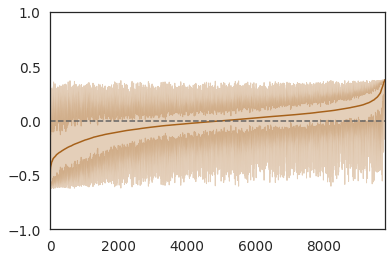

In [64]:
ef_str = "eff_temp.6191."
ef_data = req_meths_parents['CG'].loc[req_meths_parents['CG'][ef_str + 'diff'] < 0].sort_values( [ef_str + "diff"] ).loc[:,[ef_str + "lwr", ef_str + "diff", ef_str + "upr"]].dropna()
ef_data = ef_data.append( req_meths_parents['CG'].loc[req_meths_parents['CG'][ef_str + 'diff'] > 0].sort_values( [ef_str + "diff"] ).loc[:,[ef_str + "lwr", ef_str + "diff", ef_str + "upr"]].dropna() )

p = sns.scatterplot( x = np.arange(ef_data.shape[0]), y = 1, marker = "" )
p.axes.fill_between( np.arange(ef_data.shape[0]), ef_data.iloc[:,0].values, ef_data.iloc[:,2].values, interpolate=False, color = cb.diverging.BrBG_5.hex_colors[0], alpha = 0.3 )
p.plot( np.arange(ef_data.shape[0]), ef_data.iloc[:,1].values, '-', color = cb.diverging.BrBG_5.hex_colors[0])


p.set_ylim( (-1, 1) )
p.set_xlim( (0, ef_data.shape[0]) )
plt.plot((0, ef_data.shape[0]), (0, 0), '--', c = cb.sequential.Greys_5.hex_colors[3])


plt.show()

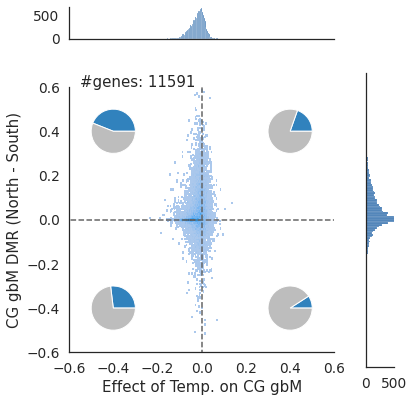

In [126]:
# loc[req_meths['stats_nonCG'].index,["DMR_T16", "corr"]].dropna()
p = sns.jointplot( data = req_meths_parents['CG'], y = "DMR_T16", x = "eff_temp_diff", marginal_ticks=True, color = cb.sequential.Blues_6.hex_colors[5], marker = "") 
p.plot_joint(sns.histplot, color=cb.sequential.Blues_6.hex_colors[4])
p.ax_joint.plot((0,0), (-1, 1), '--', color = cb.sequential.Greys_6.hex_colors[4])
p.ax_joint.plot((-1,1), (0, 0), '--', color = cb.sequential.Greys_6.hex_colors[4])

t_effects = pd.Series(classify_array(p.x)) + "_" + pd.Series(classify_array(p.y))
t_effects = (t_effects.value_counts() / t_effects.shape[0])

plot_pie( {"prop": t_effects['neg_pos'], 'x': -0.4, 'y': 0.4 }, p.ax_joint, r =0.1 )
plot_pie( {"prop": t_effects['pos_pos'], 'x': 0.4, 'y': 0.4 }, p.ax_joint, r =0.1 )
plot_pie( {"prop": t_effects['neg_neg'], 'x': -0.4, 'y': -0.4 }, p.ax_joint, r =0.1 )
plot_pie( {"prop": t_effects['pos_neg'], 'x': 0.4, 'y': -0.4 }, p.ax_joint, r =0.1 )


t_anno = "#genes: %s" % len(p.x) # ; pearsonr: %.2f, sp.stats.pearsonr(p.x, p.y)[0] )
_ = p.ax_joint.yaxis.set_ticks(np.arange(-0.6, 0.8, step = 0.20))
p.ax_joint.set_ylim((-0.6, 0.6)) 
_ = p.ax_joint.xaxis.set_ticks(np.arange(-0.6, 0.8, step = 0.20))
p.ax_joint.set_xlim((-0.6, 0.6)) 
p.ax_joint.text(-0.55, 0.6, t_anno, size = 15 )

p.ax_marg_y.set_xlim((0, 500))

p.ax_joint.set_frame_on(True)

p.ax_joint.set_ylabel( "CG gbM DMR (North - South)" )
p.ax_joint.set_xlabel( "Effect of Temp. on CG gbM" )
plt.tight_layout()

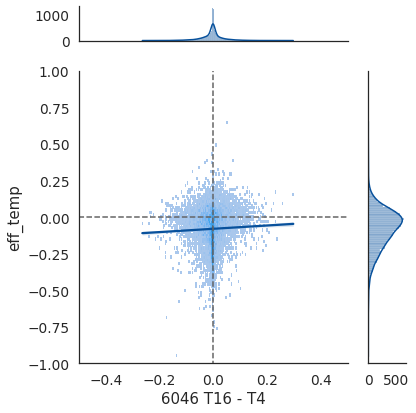

In [49]:
ef_data = req_meths_parents['CG'].loc[:,["DMR_6046", "eff_temp"]]
with pd.option_context('mode.use_inf_as_null', True):
   ef_data = ef_data.dropna()
# ef_data.iloc[:,1] =  -ef_data.iloc[:,1]
    
# sns.jointplot( y = ef_data.iloc[:,1], x = ef_data.iloc[:,0], marginal_ticks=True, color = cb.sequential.Blues_6.hex_colors[5], kind = "reg") 
def plot_pie(x, ax, r=1): 
    # radius for pieplot size on a scatterplot
    ax.pie([x['prop'], 1 - x['prop']], center=(x['x'],x['y']), radius=r, colors=['#3182bd', '#bdbdbd'])

p = sns.jointplot( y = ef_data.iloc[:,1], x = ef_data.iloc[:,0], marginal_ticks=True, color = cb.sequential.Blues_6.hex_colors[5], marker = "", kind = "reg") 
p.plot_joint(sns.histplot, color=cb.sequential.Blues_6.hex_colors[4])
p.ax_joint.plot((0,0), (-10, 10), '--', color = cb.sequential.Greys_6.hex_colors[4])
p.ax_joint.plot((-10,10), (0, 0), '--', color = cb.sequential.Greys_6.hex_colors[4])

t_effects = pd.cut(ef_data.iloc[:,0], bins = [-100, 0, 100], labels=["neg", "pos"]).astype(str) + "_" + pd.cut(ef_data.iloc[:,1], bins = [-100, 0, 100], labels=["neg", "pos"]).astype(str)
t_effects = (t_effects.value_counts() / t_effects.shape[0])

# plot_pie( {"prop": t_effects['neg_pos'], 'x': -0.4, 'y': 3 }, p.ax_joint, r =0.1 )
# plot_pie( {"prop": t_effects['pos_pos'], 'x': 0.4, 'y': 3 }, p.ax_joint, r =0.1 )
# plot_pie( {"prop": t_effects['neg_neg'], 'x': -0.4, 'y': -3 }, p.ax_joint, r =0.1 )
# plot_pie( {"prop": t_effects['pos_neg'], 'x': 0.4, 'y': -3 }, p.ax_joint, r =0.1 )

# t_anno = "#genes: %s" % len(p.x) # ; pearsonr: %.2f, sp.stats.pearsonr(p.x, p.y)[0] )
# _ = p.ax_joint.yaxis.set_ticks(np.arange(-0.6, 0.8, step = 0.20))
# _ = p.ax_joint.xaxis.set_ticks(np.arange(-0.6, 0.8, step = 0.20))
# p.ax_joint.text(-0.55, 0.6, t_anno, size = 15 )

p.ax_joint.set_frame_on(True)
p.ax_joint.set_xlim((-0.5, 0.5)) 
p.ax_joint.set_ylim((-1, 1)) 

# # p.ax_marg_y.set_xlim((0, 500))

# p.ax_joint.set_ylabel( "" )
p.ax_joint.set_xlabel( "6046 T16 - T4" )
plt.tight_layout()


plt.show()

# Does epimutations results in nonCG change?

In [30]:
cross_data = pyqtlparser.readRqtlMaps( {'d1_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D1.csv", 'd2_2020':  proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/snps_bcftools/genotyper_final_D2.csv" } )

cross_data.pheno = the1001g.ContextsHDF51001gTable( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/wmas_cds_genes/" )
cross_data.pheno_200bp = the1001g.ContextsHDF51001gTable( proj_dir + "/epiclines/005.manu.crosses.2020/004.design_resolved/wmas_200bp/" )


cross_data.parent_ids = pyqtlparser.split_ids(cross_data.pheno.cg.accessions).iloc[pd.Series(cross_data.pheno.cg.accessions).str.contains( "P_" ).values,:].sort_values( "dir_temp_plate" )


windows_within_exons = run_bedtools.get_intersect_bed_ix(reference_bed=tair10.gene_exon.loc[:,[0,1,2]], query_bed=cross_data.pheno_200bp.cg.get_bed_df(None), just_names=False )

meths_in_exon_windows = cross_data.pheno_200bp.group_sample_methylation( cross_data.parent_ids['dir_temp'], filter_pos_ix = np.unique(windows_within_exons['query_ix']) )

# aragenes_closest_marker = pd.read_csv("cache_data/araport.genes.closest.marker.csv", sep = "\t", index_col=0)

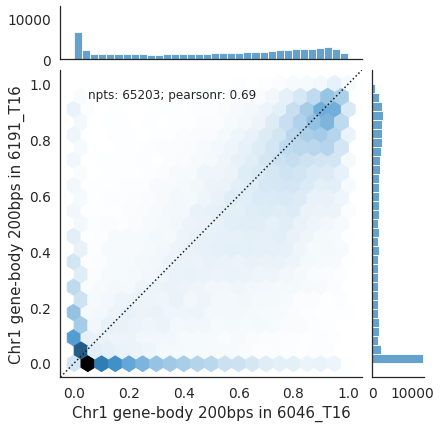

In [145]:
ef_data = meths_in_exon_windows['CG'].loc[:,['6046_T16', '6191_T16']].dropna()

p = plotting.meths_jointplot(x = ef_data.iloc[:,0].values, y = ef_data.iloc[:,1].values, reqcond = {"annotate": True, "kind": "hex", "color": cb.sequential.Blues_5.hex_colors[3], "size": 20}, min_sum = 0.03)

p.ax_joint.set_xlabel( "Chr1 gene-body 200bps in 6046_T16")
p.ax_joint.set_ylabel( "Chr1 gene-body 200bps in 6191_T16")

plt.show()

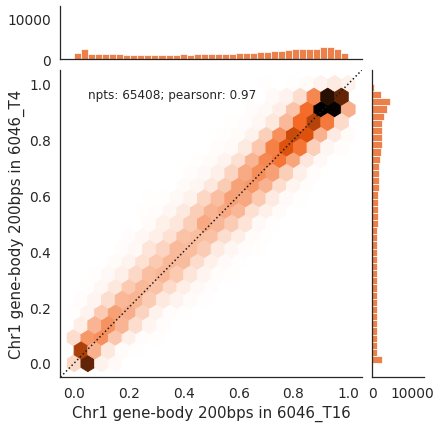

In [144]:
ef_data = meths_in_exon_windows['CG'].loc[:,['6046_T16', '6046_T4']].dropna()

p = plotting.meths_jointplot(x = ef_data.iloc[:,0].values, y = ef_data.iloc[:,1].values, reqcond = {"annotate": True, "kind": "hex", "color": cb.sequential.Oranges_5.hex_colors[3], "size": 20}, min_sum = 0.03)

p.ax_joint.set_xlabel( "Chr1 gene-body 200bps in 6046_T16")
p.ax_joint.set_ylabel( "Chr1 gene-body 200bps in 6046_T4")

plt.show()

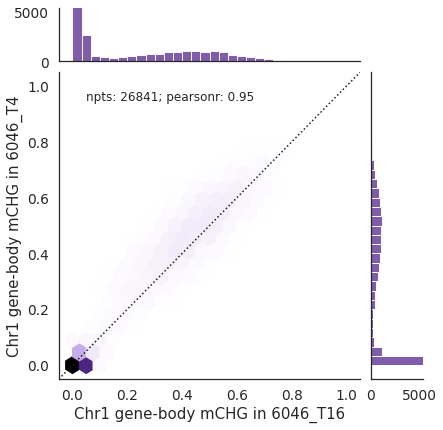

In [143]:
ef_data = meths_in_exon_windows['CHG'].loc[:,['6046_T16', '6046_T4']].dropna()

p = plotting.meths_jointplot(x = ef_data.iloc[:,0].values, y = ef_data.iloc[:,1].values, reqcond = {"annotate": True, "kind": "hex", "color": cb.sequential.Purples_5.hex_colors[4], "size": 20}, min_sum = 0.02, marginal_kws = {"bins": 30})

p.ax_joint.set_xlabel( "Chr1 gene-body mCHG in 6046_T16")
p.ax_joint.set_ylabel( "Chr1 gene-body mCHG in 6046_T4")

plt.show()

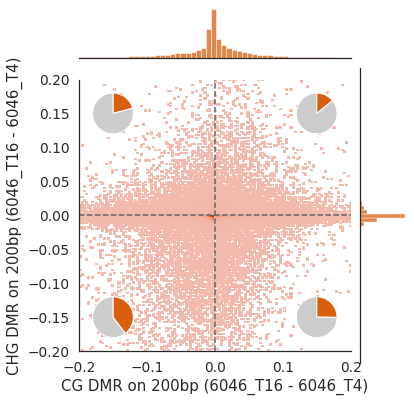

In [116]:
ef_data = pd.DataFrame( {"cg_dmr": meths_in_exon_windows['CG']['6046_T16'] - meths_in_exon_windows['CG']['6046_T4']} ) 
ef_data['chg_dmr'] = meths_in_exon_windows['CHG']['6046_T16'] - meths_in_exon_windows['CHG']['6046_T4']
ef_data['chh_dmr'] = meths_in_exon_windows['CHH']['6046_T16'] - meths_in_exon_windows['CHH']['6046_T4']
ef_data = ef_data.dropna()
ef_data = ef_data.loc[np.abs(ef_data['cg_dmr']) > 0.001]


xlim_to_joint = 0.2
ylim_to_joint = 0.2
xpos_to_pie = 0.15
ypos_to_pie = 0.15

p = sns.jointplot( x=ef_data.iloc[:,0], y = ef_data.iloc[:,1], kind = "hex", marginal_kws={"bins": 200}, xlim=(-xlim_to_joint, xlim_to_joint), ylim=(-ylim_to_joint, ylim_to_joint), color=cb.sequential.YlOrBr_6.hex_colors[4])
p.plot_joint(sns.histplot, bins = 500, color = cb.sequential.YlOrBr_6.hex_colors[4])

p.ax_joint.plot((0,0), (-ylim_to_joint, ylim_to_joint), '--', color = cb.sequential.Greys_5.hex_colors[3])
p.ax_joint.plot((-xlim_to_joint,xlim_to_joint), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3])


t_effects = pd.Series(classify_array(ef_data.iloc[:,0])) + "_" + pd.Series(classify_array(ef_data.iloc[:,1]))
t_effects = t_effects.value_counts()

plot_pie( {"prop": t_effects['neg_pos']/float(ef_data.shape[0]), 'x': -xpos_to_pie, 'y': ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_pos']/float(ef_data.shape[0]), 'x': xpos_to_pie, 'y': ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['neg_neg']/float(ef_data.shape[0]), 'x': -xpos_to_pie, 'y': -ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_neg']/float(ef_data.shape[0]), 'x': xpos_to_pie, 'y': -ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )

# t_anno = "#genes: %s\nchi-square pval: %s" % (ef_data.shape[0], sp.stats.chisquare(t_effects.values, ef_data.shape[0] * np.repeat(0.25, 4))[1]) # ; pearsonr: %.2f, sp.stats.pearsonr(p.x, p.y)[0] )
# p.ax_joint.text(-xlim_to_joint + 0.08, ylim_to_joint-0.1, t_anno, size = 15 )

p.ax_joint.set_xlabel( "CG DMR on 200bp (6046_T16 - 6046_T4)" )
p.ax_joint.set_ylabel( "CHG DMR on 200bp (6046_T16 - 6046_T4)" )

# # plt.savefig( "cline_corr_with_eff_temp.png" )

plt.show()

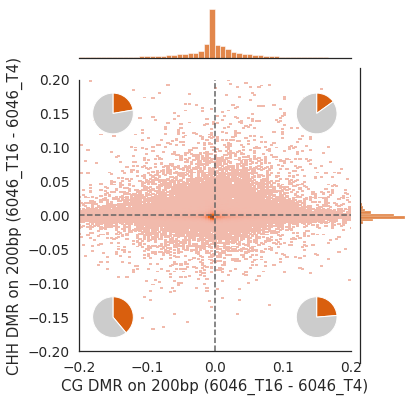

In [118]:
ef_data = pd.DataFrame( {"cg_dmr": meths_in_exon_windows['CG']['6046_T16'] - meths_in_exon_windows['CG']['6046_T4']} ) 
# ef_data['chg_dmr'] = meths_in_exon_windows['CHG']['6046_T16'] - meths_in_exon_windows['CHG']['6046_T4']
ef_data['chh_dmr'] = meths_in_exon_windows['CHH']['6046_T16'] - meths_in_exon_windows['CHH']['6046_T4']
ef_data = ef_data.dropna()
ef_data = ef_data.loc[np.abs(ef_data['cg_dmr']) > 0.001]


xlim_to_joint = 0.2
ylim_to_joint = 0.2
xpos_to_pie = 0.15
ypos_to_pie = 0.15

p = sns.jointplot( x=ef_data.iloc[:,0], y = ef_data.iloc[:,1], kind = "hex", marginal_kws={"bins": 200}, xlim=(-xlim_to_joint, xlim_to_joint), ylim=(-ylim_to_joint, ylim_to_joint), color=cb.sequential.YlOrBr_6.hex_colors[4])
p.plot_joint(sns.histplot, bins = 500, color = cb.sequential.YlOrBr_6.hex_colors[4])

p.ax_joint.plot((0,0), (-ylim_to_joint, ylim_to_joint), '--', color = cb.sequential.Greys_5.hex_colors[3])
p.ax_joint.plot((-xlim_to_joint,xlim_to_joint), (0, 0), '--', color = cb.sequential.Greys_5.hex_colors[3])


t_effects = pd.Series(classify_array(ef_data.iloc[:,0])) + "_" + pd.Series(classify_array(ef_data.iloc[:,1]))
t_effects = t_effects.value_counts()

plot_pie( {"prop": t_effects['neg_pos']/float(ef_data.shape[0]), 'x': -xpos_to_pie, 'y': ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_pos']/float(ef_data.shape[0]), 'x': xpos_to_pie, 'y': ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['neg_neg']/float(ef_data.shape[0]), 'x': -xpos_to_pie, 'y': -ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )
plot_pie( {"prop": t_effects['pos_neg']/float(ef_data.shape[0]), 'x': xpos_to_pie, 'y': -ypos_to_pie }, r = 0.03, ax = p.ax_joint, colors = [cb.sequential.YlOrBr_6.hex_colors[4], cb.sequential.Greys_5.hex_colors[1]] )

# t_anno = "#genes: %s\nchi-square pval: %s" % (ef_data.shape[0], sp.stats.chisquare(t_effects.values, ef_data.shape[0] * np.repeat(0.25, 4))[1]) # ; pearsonr: %.2f, sp.stats.pearsonr(p.x, p.y)[0] )
# p.ax_joint.text(-xlim_to_joint + 0.08, ylim_to_joint-0.1, t_anno, size = 15 )

p.ax_joint.set_xlabel( "CG DMR on 200bp (6046_T16 - 6046_T4)" )
p.ax_joint.set_ylabel( "CHH DMR on 200bp (6046_T16 - 6046_T4)" )

# # plt.savefig( "cline_corr_with_eff_temp.png" )

plt.show()